# Hopless Beer Study

Targeting production of Linalool and Geraniol for hopless beer engineering

In [1]:
import os
import sys
sys.path.append('../../')

import warning_utils
warning_utils.filter_end_user_warnings()

import cloudpickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML

from art import plot
from art.core import RecommendationEngine
from art.utility import load_study

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Define 3 different target values for Linalool and Geraniol from commercial beers.

In [2]:
#                               Linalool      Geraniol
target_dict = {'pale ale':     [0.205484162, 0.313515363], #Pale Ale
               'hop hunter':   [1.425741149, 1.917484004], #Hop Hunter
               'torpedo':      [0.531025331, 0.569713904]} #Torpedo

Load EDD study into a dataframe:

In [3]:
# Strongly recommended workflow is to *greatly* reduce preprocessing work by loading
# standardized data from the Experiment Data Depot (EDD, https://pubs.acs.org/doi/10.1021/acssynbio.7b00204).
# To skip the EDD registration step for new ART users & support automated notebook testing,
# load a data file downloaded from EDD instead.
load_from_edd = False

if load_from_edd:
    # "Slug" is the final URL portion.  For this study, full URL is https://public-edd.agilebiofoundry.org/s/hopless-beer/
    edd_study_slug = 'hopless-beer'
    edd_server = 'public-edd.agilebiofoundry.org'
    df_1 = load_study(edd_study_slug=edd_study_slug,edd_server=edd_server, default_to_system_user=False)
else:
    df_1 = load_study(data_file= '../../data/HoplessBeerCycle1Data_ART.csv')

If the dataframe was loaded from an EDD-exported CSV file it should contain at least 'Line Name' and 'Type' columns and a column for a time point. ART will then load only measurements from the first column for time point.

In [4]:
df_1.head()

Line Name                    Measurement Type            0
0        A1  R-linalool synthase, chloroplastic  3551.334545
1        A2  R-linalool synthase, chloroplastic  7402.688783
2        A4  R-linalool synthase, chloroplastic  1362.030618
3       A10  R-linalool synthase, chloroplastic  2142.470756
4       A11  R-linalool synthase, chloroplastic  1147.474052

Next we define a dictionary that contains all of the settings that ART will use to find the recommendations.

In [5]:
output_dir = '../../results/Hopless_beer_02_19_seed10'
art_params = {
    'input_vars': [
        'R-linalool synthase, chloroplastic',
        'Geraniol synthase, chloroplastic',
        'Farnesyl pyrophosphate synthase',
        'Hydroxymethylglutaryl-CoA synthase'
    ],
    'response_vars': ['Linalool', 'GERANIOL'],
    'objective': 'target',
     # First set Pale Ale as the target beer
    'target_values': target_dict['pale ale'],
    'num_recommendations': 10,
    'verbose': 1,
    'seed': 10,
    'output_dir': output_dir,
    'build_model': False,
    'recommend': False,
    'cross_val': True,
    'last_dashes_denote_replicates': False,
    'max_mcmc_cores': 2,
}

In [6]:
# import cloudpickle
# art_1_pkl = cloudpickle.load( open( output_dir + '/art_C1.cpkl', "rb" ) )
# art_1.output_dir = output_dir

In this case we have proteomics data which will be used to determine production of linalool (L) and geraniol (G) in terms of total protein concentrations. Then target protein concentrations, aimed to hit specified values of L and G for a target commercial beer, will be reported back to the user.

Initialize ART with Cycle 1 data and the parameter dictionary generated above.

In [7]:
art_1 = RecommendationEngine(df=df_1, result_suffix='_C1', **art_params)

ART identified 19 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.


Initialize ART with Cycle 2 data, to be used as test data points

In [8]:
if load_from_edd:
    # Recommended workflow is to greatly reduce preprocessing work by loading standardized data from EDD.
    # "Slug" is the final URL portion.  For this study, full URL is https://public-edd.agilebiofoundry.org/s/hopless-beer-cycle-2/
    edd_study_slug = 'hopless-beer-cycle-2'
    edd_server = 'public-edd.agilebiofoundry.org'
    df_2 = load_study(edd_study_slug=edd_study_slug,edd_server=edd_server, default_to_system_user=False)
else:
    # To support automated notebook testing & reduce steps for new ART users, load the data from file instead.
    df_2 = load_study(data_file= '../../data/HoplessBeerCycle2Data_ART.csv')

art_2 = RecommendationEngine(df=df_2, result_suffix='_C2', **art_params)


ART identified 31 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.


How many instances/replicates?

In [9]:
print(f'Cycle 1: {len(art_1.df)}\nCycle 2: {len(art_2.df)}')


Cycle 1: 19
Cycle 2: 31


Visualize strains for both cycles

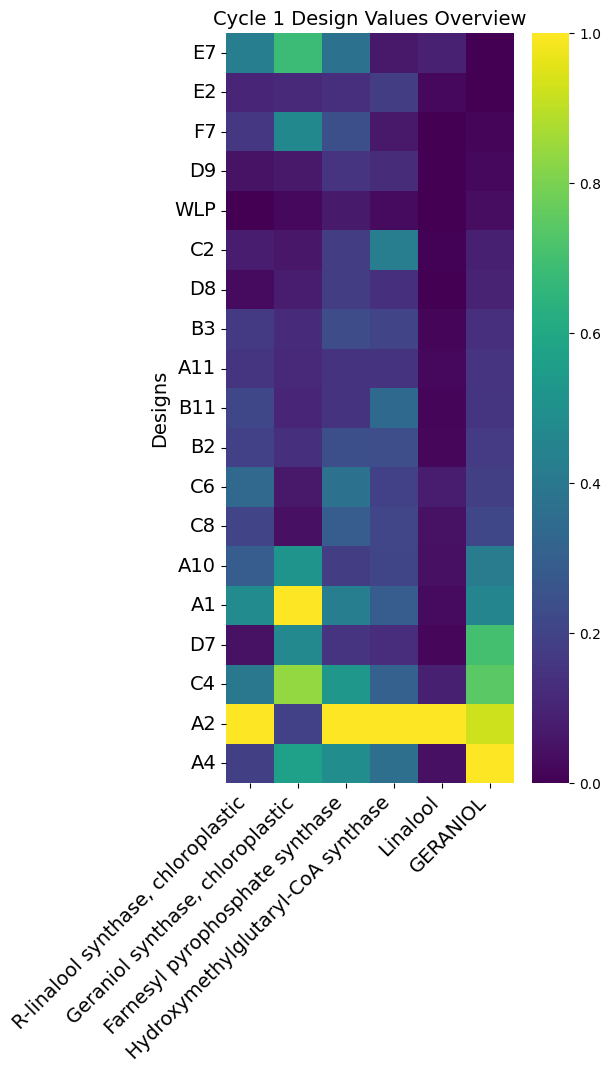

In [10]:
plot.data_overview(art_1.df,
                   art_1.output_dir,
                   sort=('Response Variables', art_1.response_vars[1]),
                   title='Cycle 1 Design Values Overview',
                   y_label='Designs',
                   filename_suffix="_C1",
                   margins=[0.3, 0.2, 0.9, 0.95])

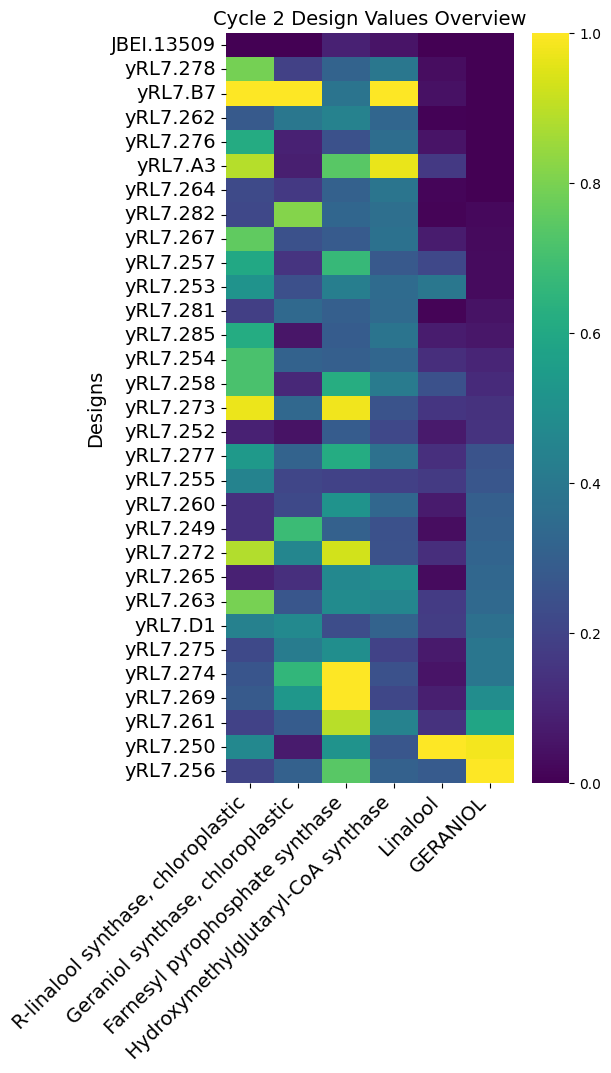

In [11]:
plot.data_overview(art_2.df,
                   art_2.output_dir,
                   sort=('Response Variables', art_2.response_vars[1]),
                   title='Cycle 2 Design Values Overview',
                   y_label='Designs',
                   filename_suffix="_C2",
                   margins=[0.3, 0.2, 0.9, 0.95])

Train the model and perform cross-validation

Cross-validating models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RidgeCV(AdaBoostRegressor(SelectFromModel(input_matrix, max_features=0.6000000000000001, n_estimators=100, threshold=0.25), learning_rate=0.001, loss=square, n_estimators=100))
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RidgeCV(MaxAbsScaler(RidgeCV(RidgeCV(RidgeCV(input_matrix)))))
Done fitting L0 models in 32.45 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 26.62 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LinearSVR(input_matrix, C=5.0, dual=True, epsilon=0.0001, loss=epsilon_insensitive, tol=0.1)
Building TPOT models…


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RidgeCV(AdaBoostRegressor(VarianceThreshold(input_matrix, threshold=0.001), learning_rate=0.1, loss=linear, n_estimators=100))
Done fitting L0 models in 41.60 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinea

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 29.17 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LinearSVR(input_matrix, C=0.0001, dual=False, epsilon=0.01, loss=squared_epsilon_insensitive, tol=0.01)
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: LinearSVR(input_matrix, C=0.001, dual=True, epsilon=0.1, loss=squared_epsilon_insensitive, tol=0.001)
Done fitting L0 models in 16.46 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinea

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 27.99 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LinearSVR(input_matrix, C=0.0001, dual=True, epsilon=0.01, loss=squared_epsilon_insensitive, tol=0.01)
Building TPOT models…


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: LinearSVR(RidgeCV(RidgeCV(RidgeCV(RidgeCV(input_matrix)))), C=20.0, dual=False, epsilon=0.1, loss=squared_epsilon_insensitive, tol=0.1)
Done fitting L0 models in 19.56 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinea

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 29.03 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LinearSVR(input_matrix, C=1.0, dual=True, epsilon=0.01, loss=epsilon_insensitive, tol=0.0001)
Building TPOT models…


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: LassoLarsCV(ZeroCount(FastICA(input_matrix, tol=0.9500000000000001)), normalize=False)
Done fitting L0 models in 31.03 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinea

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 32.39 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ElasticNetCV(Nystroem(input_matrix, gamma=1.0, kernel=polynomial, n_components=8), l1_ratio=0.45, tol=1e-05)
Building TPOT models…


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020112232423019627, tolerance: 0.00013168785129985075
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00048547986674146726, tolerance: 0.00013168785129985075
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046667502164182695, tolerance: 0.00013168785129985075
  model = cd_fast.enet_coordinate_descent_gram(
Version 0.11.7 of tpot is outdated. Version

Best pipeline: AdaBoostRegressor(PCA(input_matrix, iterated_power=2, svd_solver=randomized), learning_rate=1.0, loss=exponential, n_estimators=100)
Done fitting L0 models in 44.36 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016080121106548662, tolerance: 0.00012782541526575324
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016511804588664747, tolerance: 0.00012782541526575324
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004576626970121678, tolerance: 0.00012949415728709146
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/art/.venv/lib/python3.11/site-pac

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 103 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 124.40 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LinearSVR(MaxAbsScaler(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False)), C=5.0, dual=True, epsilon=0.01, loss=epsilon_insensitive, tol=0.01)
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=3, p=1, weights=distance)
Done fitting L0 models in 32.89 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 28.77 s
Fitting L0 models…
Building TPOT models…
Best pipeline: RidgeCV(PolynomialFeatures(PCA(input_matrix, iterated_power=10, svd_solver=randomized), degree=2, include_bias=False, interaction_only=False))
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: LassoLarsCV(SGDRegressor(input_matrix, alpha=0.001, eta0=1.0, fit_intercept=True, l1_ratio=0.0, learning_rate=invscaling, loss=huber, penalty=elasticnet, power_t=1.0), normalize=False)
Done fitting L0 models in 21.78 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 32.55 s
Fitting L0 models…
Building TPOT models…
Best pipeline: RidgeCV(Nystroem(ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.45, min_samples_leaf=8, min_samples_split=4, n_estimators=100), gamma=0.9500000000000001, kernel=additive_chi2, n_components=9))
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RidgeCV(RidgeCV(CombineDFs(input_matrix, input_matrix)))
Done fitting L0 models in 24.42 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 29.07 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ElasticNetCV(LinearSVR(SelectPercentile(RobustScaler(SelectPercentile(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), percentile=91)), percentile=91), C=10.0, dual=True, epsilon=0.001, loss=squared_epsilon_insensitive, tol=1e-05), l1_ratio=0.45, tol=1e-05)
Building TPOT models…


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.678e-03, tolerance: 1.338e-04
  model = cd_fast.enet_coordinate_descent(
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RidgeCV(ExtraTreesRegressor(RobustScaler(input_matrix), bootstrap=False, max_features=0.6000000000000001, min_samples_leaf=6, min_samples_split=7, n_estimators=100))
Done fitting L0 models in 39.96 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.309e-03, tolerance: 1.321e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap:

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 26.91 s


/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in double_scalars
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


MAE  MRAE(%)     StdAE        MSE      $R^2$
Name                                                                          
Neural Regressor             0.229663      inf  0.445427   0.251150   0.644035
Random Forest Regressor      0.254086      inf  0.788194   0.685809   0.027977
Support Vector Regressor     0.285748      inf  0.804755   0.729282  -0.033638
Kernel Ridge Regressor       0.266471      inf  0.844559   0.784286  -0.111598
K-NN Regressor               0.262984      inf  0.802293   0.712835  -0.010327
Gaussian Process Regressor   0.275059      inf  0.817766   0.744398  -0.055063
Gradient Boosting Regressor  0.259941      inf  0.788876   0.689895   0.022186
TPOT Regressor               1.428482      inf  3.464327  14.042123 -18.902424
Ensemble Model               0.277375      inf  0.781097   0.687049   0.026220

/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in double_scalars
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


MAE  MRAE(%)     StdAE       MSE     $R^2$
Name                                                                        
Neural Regressor             0.244007      inf  0.398861  0.218629 -6.491273
Random Forest Regressor      0.102085      inf  0.097535  0.019934  0.316951
Support Vector Regressor     0.107500      inf  0.093508  0.020300  0.304424
Kernel Ridge Regressor       0.105794      inf  0.132139  0.028653  0.018206
K-NN Regressor               0.106408      inf  0.120125  0.025753  0.117591
Gaussian Process Regressor   0.121221      inf  0.122588  0.029722 -0.018424
Gradient Boosting Regressor  0.106384      inf  0.096517  0.020633  0.293011
TPOT Regressor               0.154865      inf  0.173367  0.054039 -0.851647
Ensemble Model               0.093134      inf  0.097143  0.018111  0.379440

Done with 10-fold cross-validation in 1008.99 s


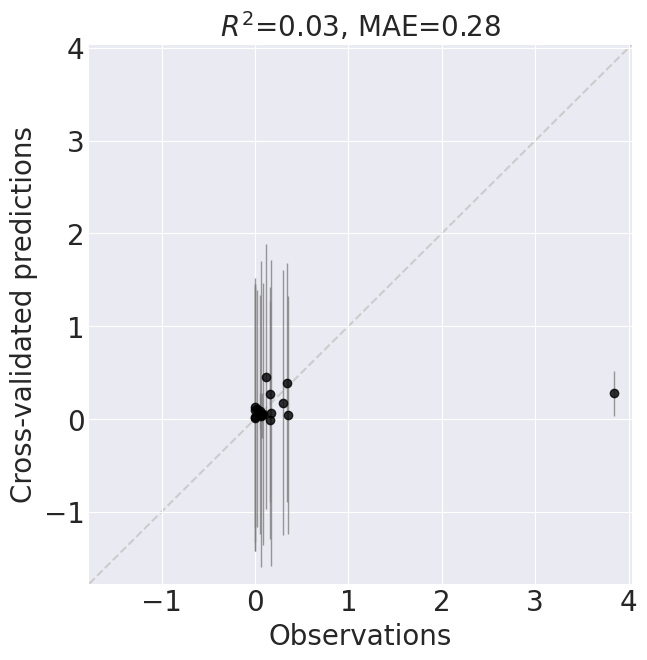

output_dir: ../../results/Hopless_beer_02_19_seed10  Exists? True
file_path: ../../results/Hopless_beer_02_19_seed10/predictions_vs_observations_cv_Linalool.png  Exists? True


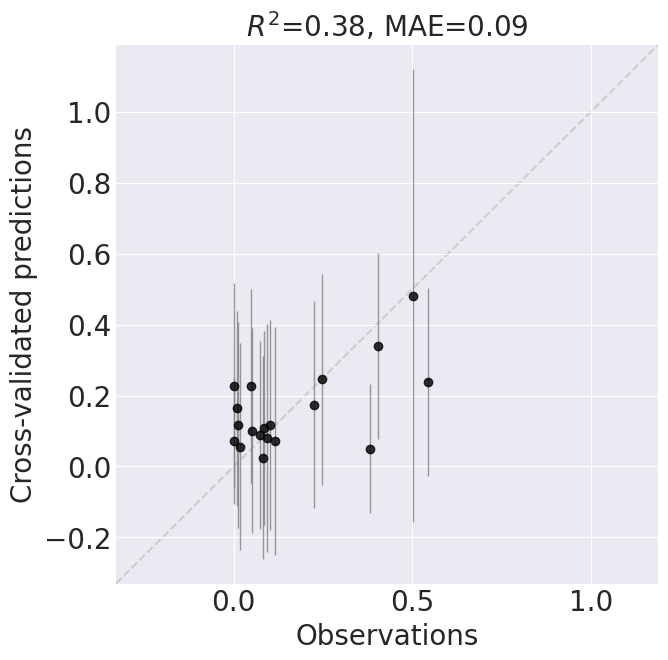

output_dir: ../../results/Hopless_beer_02_19_seed10  Exists? True
file_path: ../../results/Hopless_beer_02_19_seed10/predictions_vs_observations_cv_GERANIOL.png  Exists? False
Building models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RidgeCV(PolynomialFeatures(MaxAbsScaler(input_matrix), degree=2, include_bias=False, interaction_only=False))
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: ElasticNetCV(MinMaxScaler(input_matrix), l1_ratio=0.1, tol=0.0001)
Done fitting L0 models in 31.71 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 26.48 s


/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in double_scalars
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


MAE  MRAE(%)     StdAE           MSE  \
Name                                                                     
Neural Regressor             0.082994      inf  0.070652  1.187974e-02   
Random Forest Regressor      0.102044      inf  0.332729  1.211215e-01   
Support Vector Regressor     0.178188      inf  0.502430  2.841865e-01   
Kernel Ridge Regressor       0.112646      inf  0.276741  8.927479e-02   
K-NN Regressor               0.205556      inf  0.634916  4.453722e-01   
Gaussian Process Regressor   0.023810      inf  0.015651  8.118664e-04   
Gradient Boosting Regressor  0.000445      inf  0.000293  2.832297e-07   
TPOT Regressor               0.063697      inf  0.037924  5.495475e-03   
Ensemble Model               0.078768      inf  0.121396  2.094129e-02   

                                $R^2$  
Name                                   
Neural Regressor             0.983162  
Random Forest Regressor      0.828330  
Support Vector Regressor     0.597212  
Kernel Ridge Regressor       0.873468  
K-NN Regressor               0.368757  
Gaussian Process Regressor   0.998849  
Gradient Boosting Regressor  1.000000  
TPOT Regressor               0.992211  
Ensemble Model               0.970319

/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in double_scalars
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


MAE  MRAE(%)     StdAE           MSE  \
Name                                                                     
Neural Regressor             0.105275      inf  0.061858  1.490919e-02   
Random Forest Regressor      0.030502      inf  0.035123  2.164003e-03   
Support Vector Regressor     0.062336      inf  0.036905  5.247795e-03   
Kernel Ridge Regressor       0.066874      inf  0.066882  8.945368e-03   
K-NN Regressor               0.076300      inf  0.086717  1.334157e-02   
Gaussian Process Regressor   0.003823      inf  0.003713  2.840868e-05   
Gradient Boosting Regressor  0.000137      inf  0.000141  3.864072e-08   
TPOT Regressor               0.069739      inf  0.056621  8.069439e-03   
Ensemble Model               0.043469      inf  0.033639  3.021171e-03   

                                $R^2$  
Name                                   
Neural Regressor             0.489141  
Random Forest Regressor      0.925851  
Support Vector Regressor     0.820186  
Kernel Ridge Regressor       0.693489  
K-NN Regressor               0.542855  
Gaussian Process Regressor   0.999027  
Gradient Boosting Regressor  0.999999  
TPOT Regressor               0.723503  
Ensemble Model               0.896480

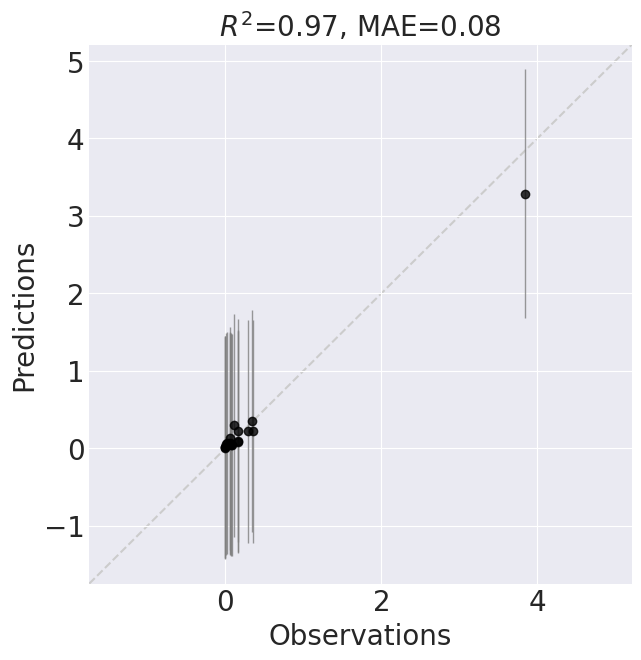

output_dir: ../../results/Hopless_beer_02_19_seed10  Exists? True
file_path: ../../results/Hopless_beer_02_19_seed10/predictions_vs_observations_Linalool.png  Exists? True


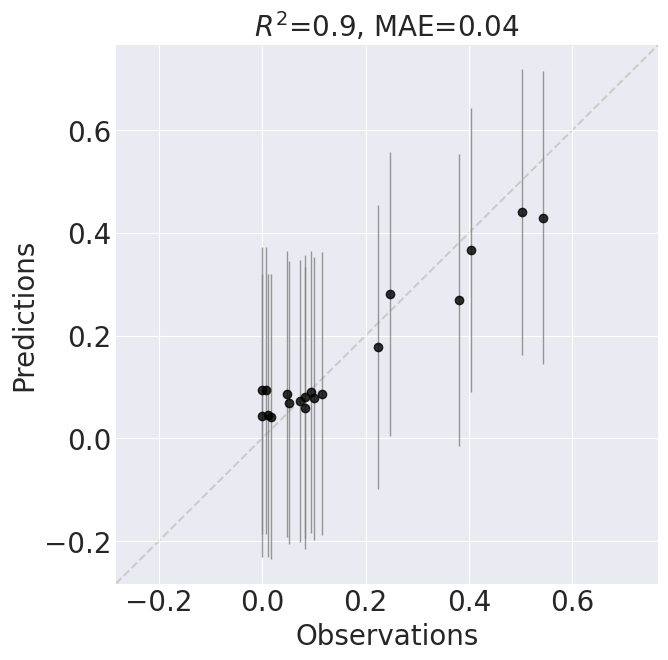

output_dir: ../../results/Hopless_beer_02_19_seed10  Exists? True
file_path: ../../results/Hopless_beer_02_19_seed10/predictions_vs_observations_GERANIOL.png  Exists? True
Done building models in 87.94 s
CPU times: user 12min 23s, sys: 12 s, total: 12min 35s
Wall time: 18min 17s


In [12]:
%%time
art_1.build_model()

Cross-validated evaluation of learned predictive models for Linalool (top) and Geraniol (bottom). Evaluation in terms of Mean Absolute Error (MAE), Mean Relative AE (MRAE), Standard Deviation of the Absolute Error (StdAE) and R$^2$ , for each individual model and the ensemble model.


In [13]:
art_1.evaluate_models_cv()


MAE  MRAE(%)     StdAE        MSE      $R^2$
Name                                                                          
Neural Regressor             0.229663      inf  0.445427   0.251150   0.644035
Random Forest Regressor      0.254086      inf  0.788194   0.685809   0.027977
Support Vector Regressor     0.285748      inf  0.804755   0.729282  -0.033638
Kernel Ridge Regressor       0.266471      inf  0.844559   0.784286  -0.111598
K-NN Regressor               0.262984      inf  0.802293   0.712835  -0.010327
Gaussian Process Regressor   0.275059      inf  0.817766   0.744398  -0.055063
Gradient Boosting Regressor  0.259941      inf  0.788876   0.689895   0.022186
TPOT Regressor               1.428482      inf  3.464327  14.042123 -18.902424
Ensemble Model               0.277375      inf  0.781097   0.687049   0.026220

MAE  MRAE(%)     StdAE       MSE     $R^2$
Name                                                                        
Neural Regressor             0.244007      inf  0.398861  0.218629 -6.491273
Random Forest Regressor      0.102085      inf  0.097535  0.019934  0.316951
Support Vector Regressor     0.107500      inf  0.093508  0.020300  0.304424
Kernel Ridge Regressor       0.105794      inf  0.132139  0.028653  0.018206
K-NN Regressor               0.106408      inf  0.120125  0.025753  0.117591
Gaussian Process Regressor   0.121221      inf  0.122588  0.029722 -0.018424
Gradient Boosting Regressor  0.106384      inf  0.096517  0.020633  0.293011
TPOT Regressor               0.154865      inf  0.173367  0.054039 -0.851647
Ensemble Model               0.093134      inf  0.097143  0.018111  0.379440

Plot observations vs. cross-validated predictions (mean values and 95% confidence interval) for the train data (black) and predictions for the test data (blue), for Linalool (top) and Geraniol (bottom)

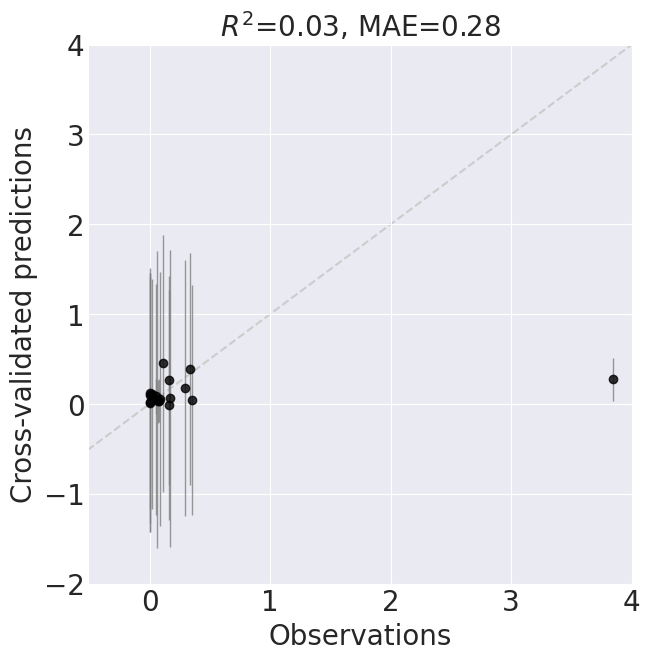

output_dir: ../../results/Hopless_beer_02_19_seed10  Exists? True
file_path: ../../results/Hopless_beer_02_19_seed10/predictions_vs_observations_cv_Linalool.png  Exists? True


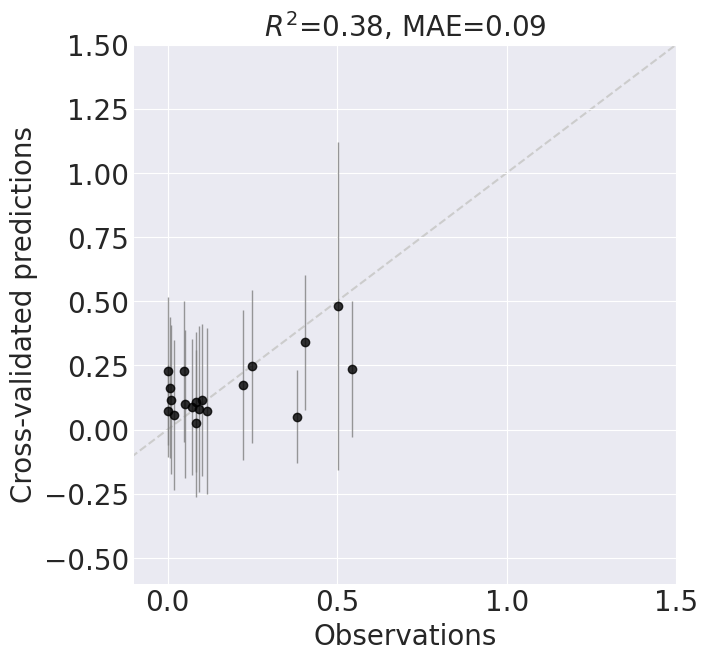

output_dir: ../../results/Hopless_beer_02_19_seed10  Exists? True
file_path: ../../results/Hopless_beer_02_19_seed10/predictions_vs_observations_cv_GERANIOL.png  Exists? True


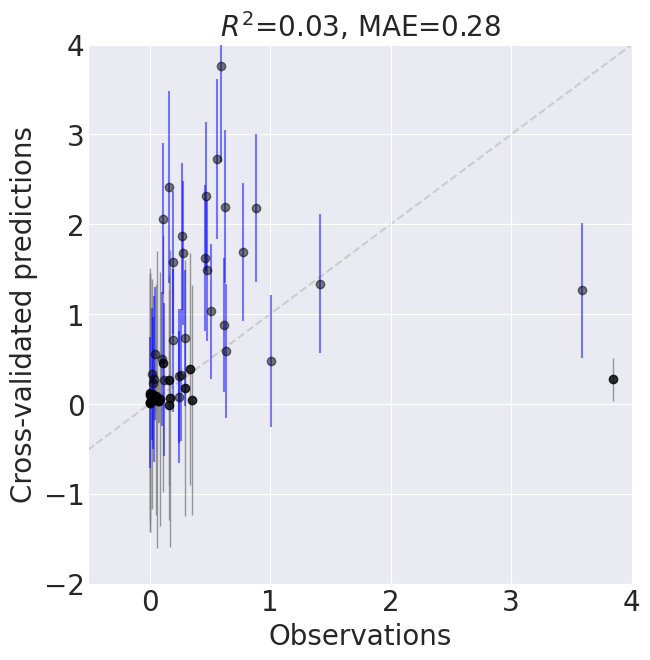

output_dir: ../../results/Hopless_beer_02_19_seed10  Exists? True
file_path: ../../results/Hopless_beer_02_19_seed10/predictions_vs_observations_cv_w_test_Linalool.png  Exists? False


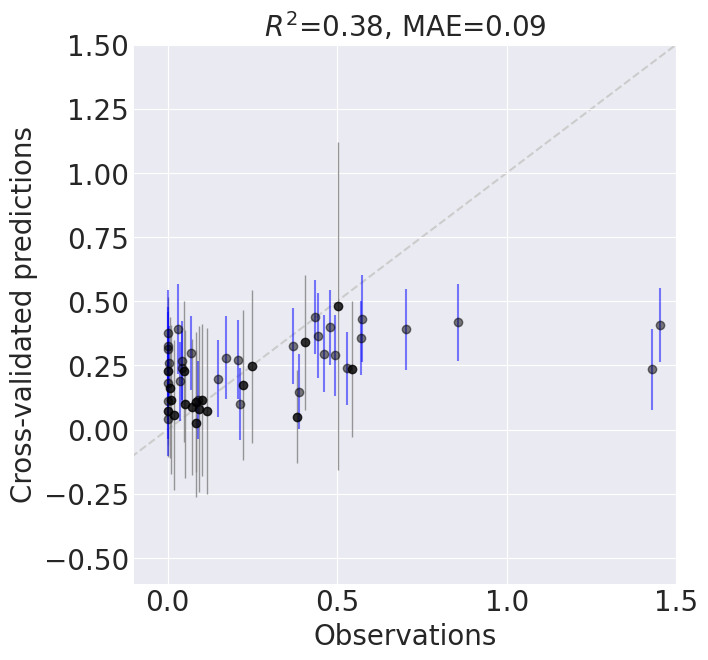

output_dir: ../../results/Hopless_beer_02_19_seed10  Exists? True
file_path: ../../results/Hopless_beer_02_19_seed10/predictions_vs_observations_cv_w_test_GERANIOL.png  Exists? False


In [14]:
xlim=[[-0.5, 4],[-0.1, 1.5]]
ylim=[[-2, 4],[-0.6, 1.5]]
plot.predictions_vs_observations(art_1, cv=True, error_bars=True,
                                 x_limits=xlim, y_limits=ylim)

X_test = art_2.X
y_test = art_2.y
plot.predictions_vs_observations(art_1, cv=True, error_bars=True, X_test=X_test, y_test=y_test,
                                 x_limits=xlim, y_limits=ylim)


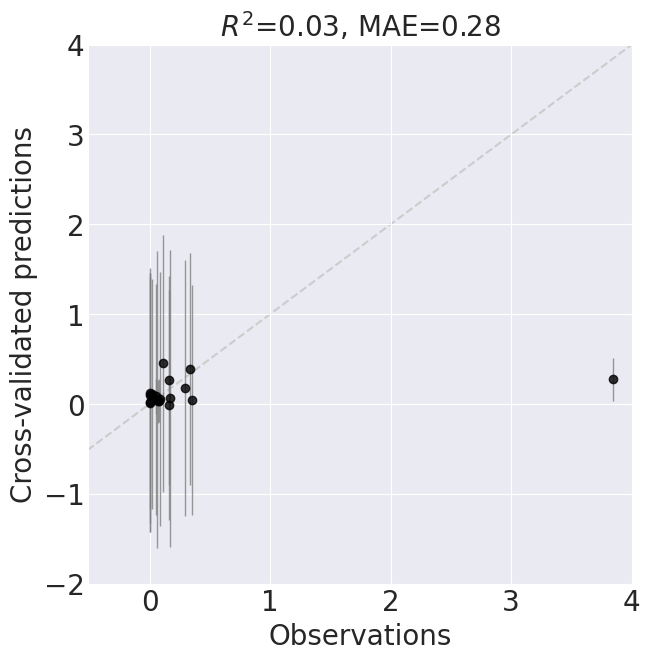

output_dir: ../../results/Hopless_beer_02_19_seed10  Exists? True
file_path: ../../results/Hopless_beer_02_19_seed10/predictions_vs_observations_cv_Linalool.png  Exists? True


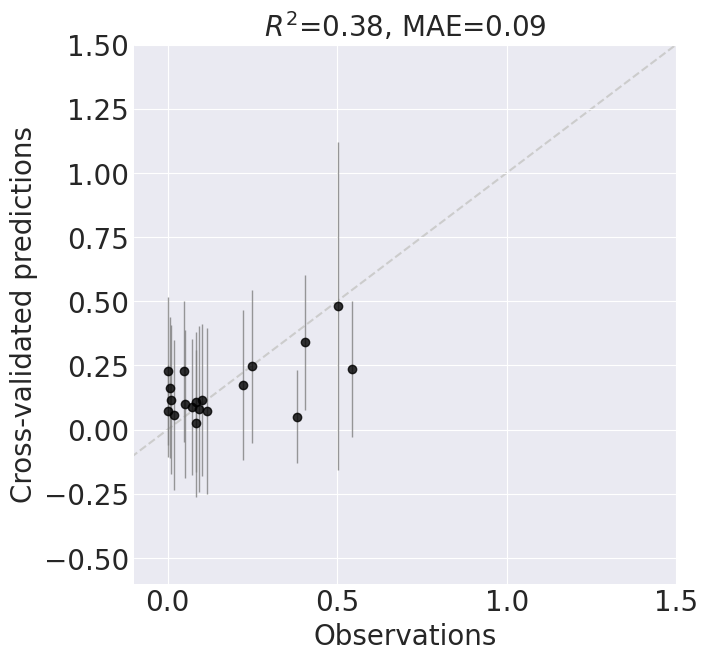

output_dir: ../../results/Hopless_beer_02_19_seed10  Exists? True
file_path: ../../results/Hopless_beer_02_19_seed10/predictions_vs_observations_cv_GERANIOL.png  Exists? True


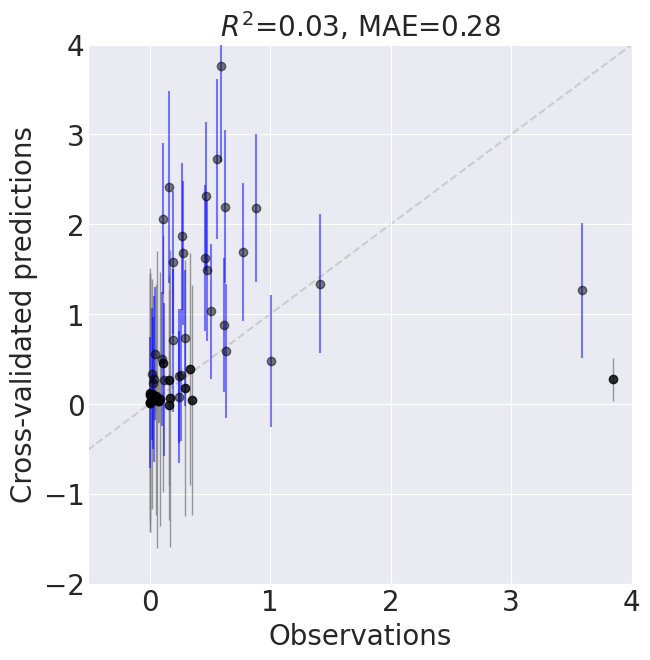

output_dir: ../../results/Hopless_beer_02_19_seed10  Exists? True
file_path: ../../results/Hopless_beer_02_19_seed10/predictions_vs_observations_cv_w_test_Linalool.png  Exists? True


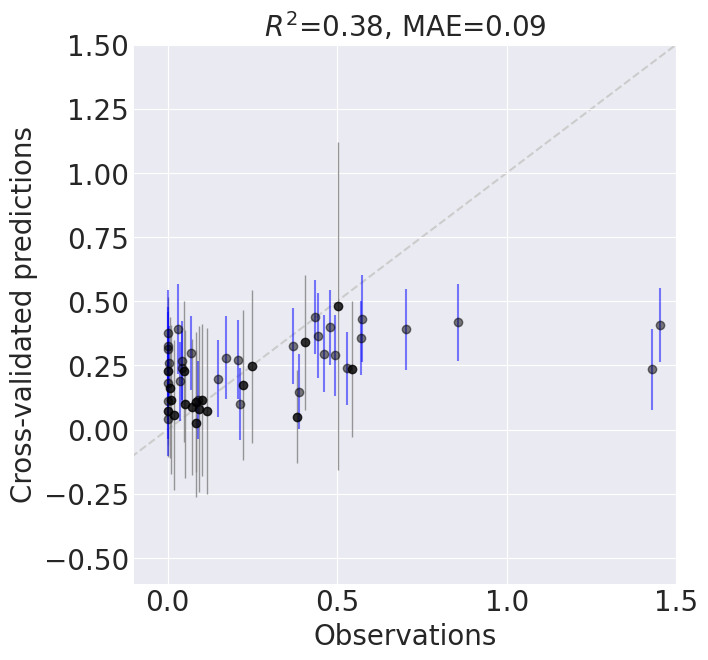

output_dir: ../../results/Hopless_beer_02_19_seed10  Exists? True
file_path: ../../results/Hopless_beer_02_19_seed10/predictions_vs_observations_cv_w_test_GERANIOL.png  Exists? True


In [15]:
xlim=[[-0.5, 4],[-0.1, 1.5]]
ylim=[[-2, 4],[-0.6, 1.5]]
plot.predictions_vs_observations(art_1, cv=True, error_bars=True,
                                 x_limits=xlim, y_limits=ylim)

X_test = art_2.X
y_test = art_2.y
plot.predictions_vs_observations(art_1, cv=True, error_bars=True, X_test=X_test, y_test=y_test,
                                 x_limits=xlim, y_limits=ylim)


Evaluation of learned predictive models for Linalool (top) and Geraniol (bottom) on train data:


In [17]:
art_1.evaluate_models()


/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in double_scalars
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


MAE  MRAE(%)     StdAE           MSE  \
Name                                                                     
Neural Regressor             0.082994      inf  0.070652  1.187974e-02   
Random Forest Regressor      0.102044      inf  0.332729  1.211215e-01   
Support Vector Regressor     0.178188      inf  0.502430  2.841865e-01   
Kernel Ridge Regressor       0.112646      inf  0.276741  8.927479e-02   
K-NN Regressor               0.205556      inf  0.634916  4.453722e-01   
Gaussian Process Regressor   0.023810      inf  0.015651  8.118664e-04   
Gradient Boosting Regressor  0.000445      inf  0.000293  2.832297e-07   
TPOT Regressor               0.063697      inf  0.037924  5.495475e-03   
Ensemble Model               0.078768      inf  0.121396  2.094129e-02   

                                $R^2$  
Name                                   
Neural Regressor             0.983162  
Random Forest Regressor      0.828330  
Support Vector Regressor     0.597212  
Kernel Ridge Regressor       0.873468  
K-NN Regressor               0.368757  
Gaussian Process Regressor   0.998849  
Gradient Boosting Regressor  1.000000  
TPOT Regressor               0.992211  
Ensemble Model               0.970319

/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in double_scalars
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


MAE  MRAE(%)     StdAE           MSE  \
Name                                                                     
Neural Regressor             0.105275      inf  0.061858  1.490919e-02   
Random Forest Regressor      0.030502      inf  0.035123  2.164003e-03   
Support Vector Regressor     0.062336      inf  0.036905  5.247795e-03   
Kernel Ridge Regressor       0.066874      inf  0.066882  8.945368e-03   
K-NN Regressor               0.076300      inf  0.086717  1.334157e-02   
Gaussian Process Regressor   0.003823      inf  0.003713  2.840868e-05   
Gradient Boosting Regressor  0.000137      inf  0.000141  3.864072e-08   
TPOT Regressor               0.069739      inf  0.056621  8.069439e-03   
Ensemble Model               0.043469      inf  0.033639  3.021171e-03   

                                $R^2$  
Name                                   
Neural Regressor             0.489141  
Random Forest Regressor      0.925851  
Support Vector Regressor     0.820186  
Kernel Ridge Regressor       0.693489  
K-NN Regressor               0.542855  
Gaussian Process Regressor   0.999027  
Gradient Boosting Regressor  0.999999  
TPOT Regressor               0.723503  
Ensemble Model               0.896480

### Optimization for **Pale Ale** beer.

Sample the space of protein expressions in search of those that hit the target L and G production.


Perform sampling-based optimization and find recommendations with default options (`niter=100000` for number of samples collected, `alpha=None` for a purely exploitative strategy, and `rel_rec_distance=20%` for relative recommendations distance):

In [19]:
art_1.target_values = target_dict['pale ale']
art_1.result_suffix = "_PA_C1"

Starting parallel tempering using 2 chains…
Done with parallel tempering in 214.38 s
Choosing recommendations (19,800 candidates)…


Done choosing recommendations in 0.00 s


R-linalool synthase, chloroplastic  Geraniol synthase, chloroplastic  \
0                         1882.562813                       3481.725329   
1                         1603.224378                       1438.946553   
2                         1953.281455                       1748.544597   
3                         1151.363447                       1091.295948   
4                         1416.932287                       3483.276020   
5                         1933.256499                       2821.571893   
6                         1837.414013                       2769.608870   
7                          875.471266                       2860.593707   
8                         1209.085286                       3349.182090   
9                         2098.600841                       3764.967822   

   Farnesyl pyrophosphate synthase  Hydroxymethylglutaryl-CoA synthase  \
0                     17544.293244                        16769.365554   
1                     33895.069566                        10147.957808   
2                     30172.326913                         9160.891349   
3                     29519.769834                        15122.969993   
4                     22507.319779                        12477.296710   
5                     21510.115438                        16316.762439   
6                     14879.609016                        21074.986074   
7                      9205.894916                        29549.475016   
8                     27061.777317                         6718.377001   
9                     14056.646819                        21481.058454   

   Linalool  GERANIOL  
0  0.203930  0.312153  
1  0.208212  0.313841  
2  0.207330  0.311395  
3  0.207217  0.316992  
4  0.207691  0.318083  
5  0.210702  0.313553  
6  0.202163  0.309086  
7  0.210956  0.315635  
8  0.199640  0.314996  
9  0.203174  0.307534

Sampling: [y]


Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 1.36 s


/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

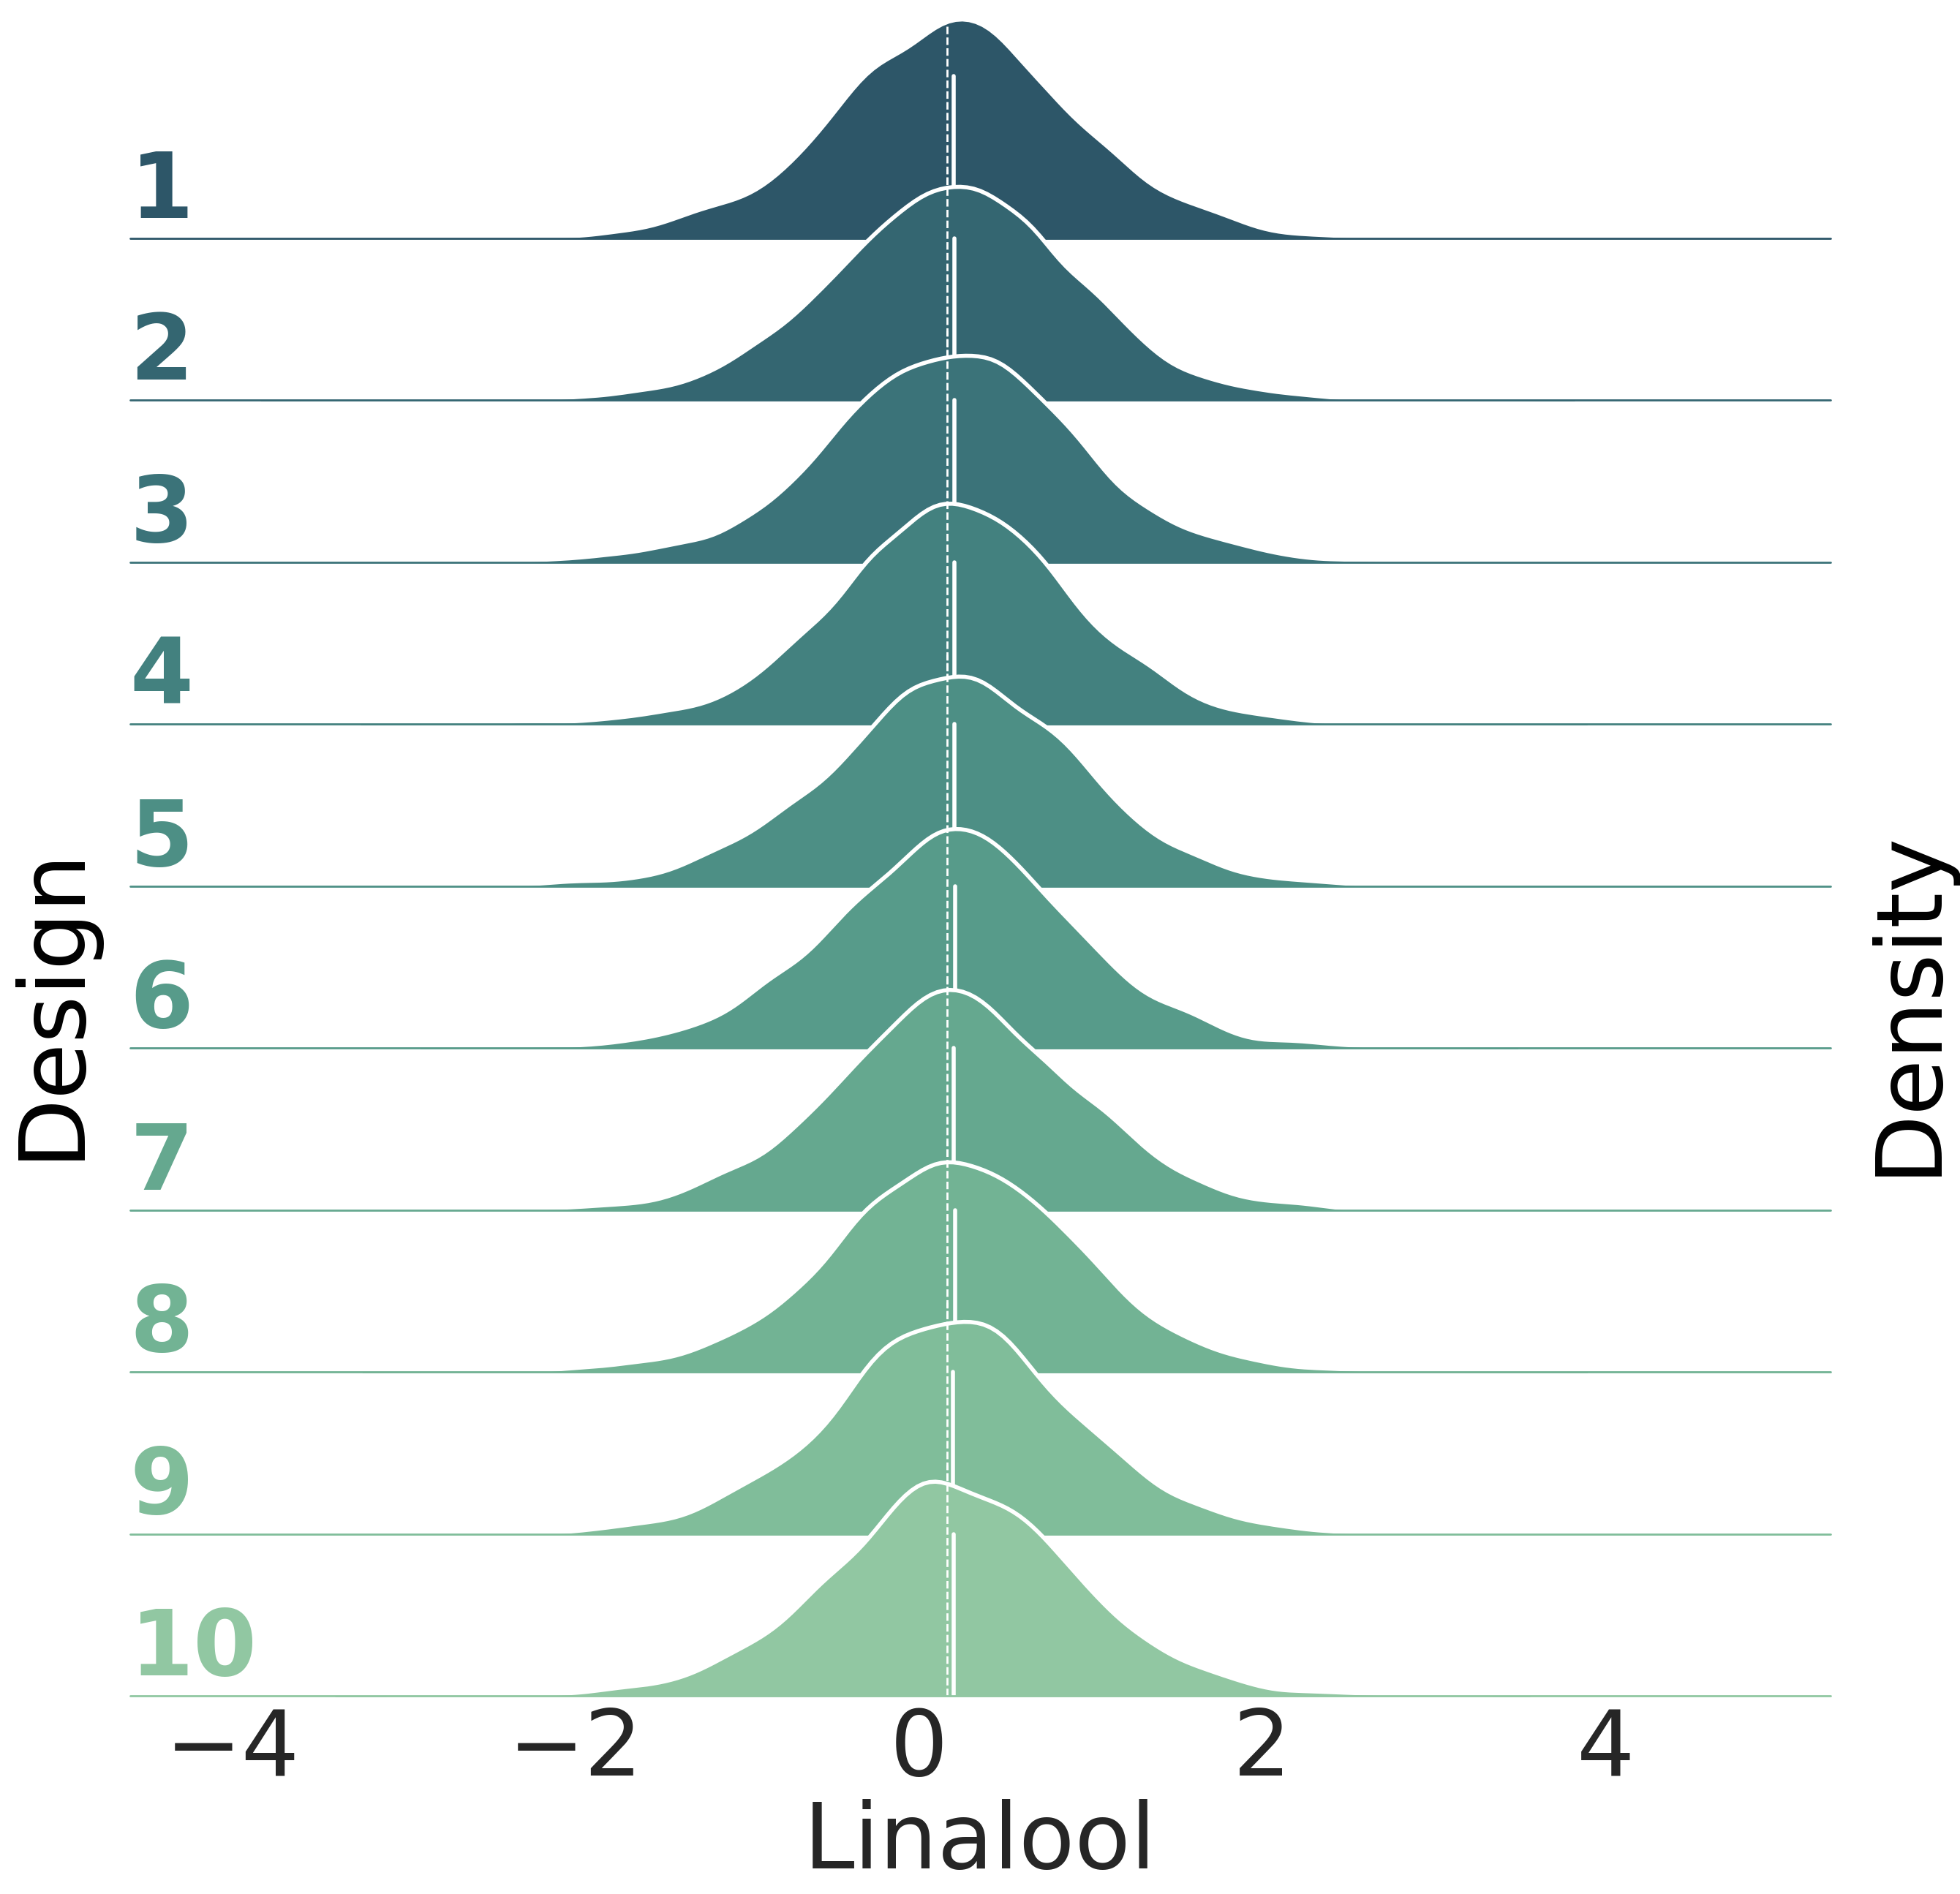

/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

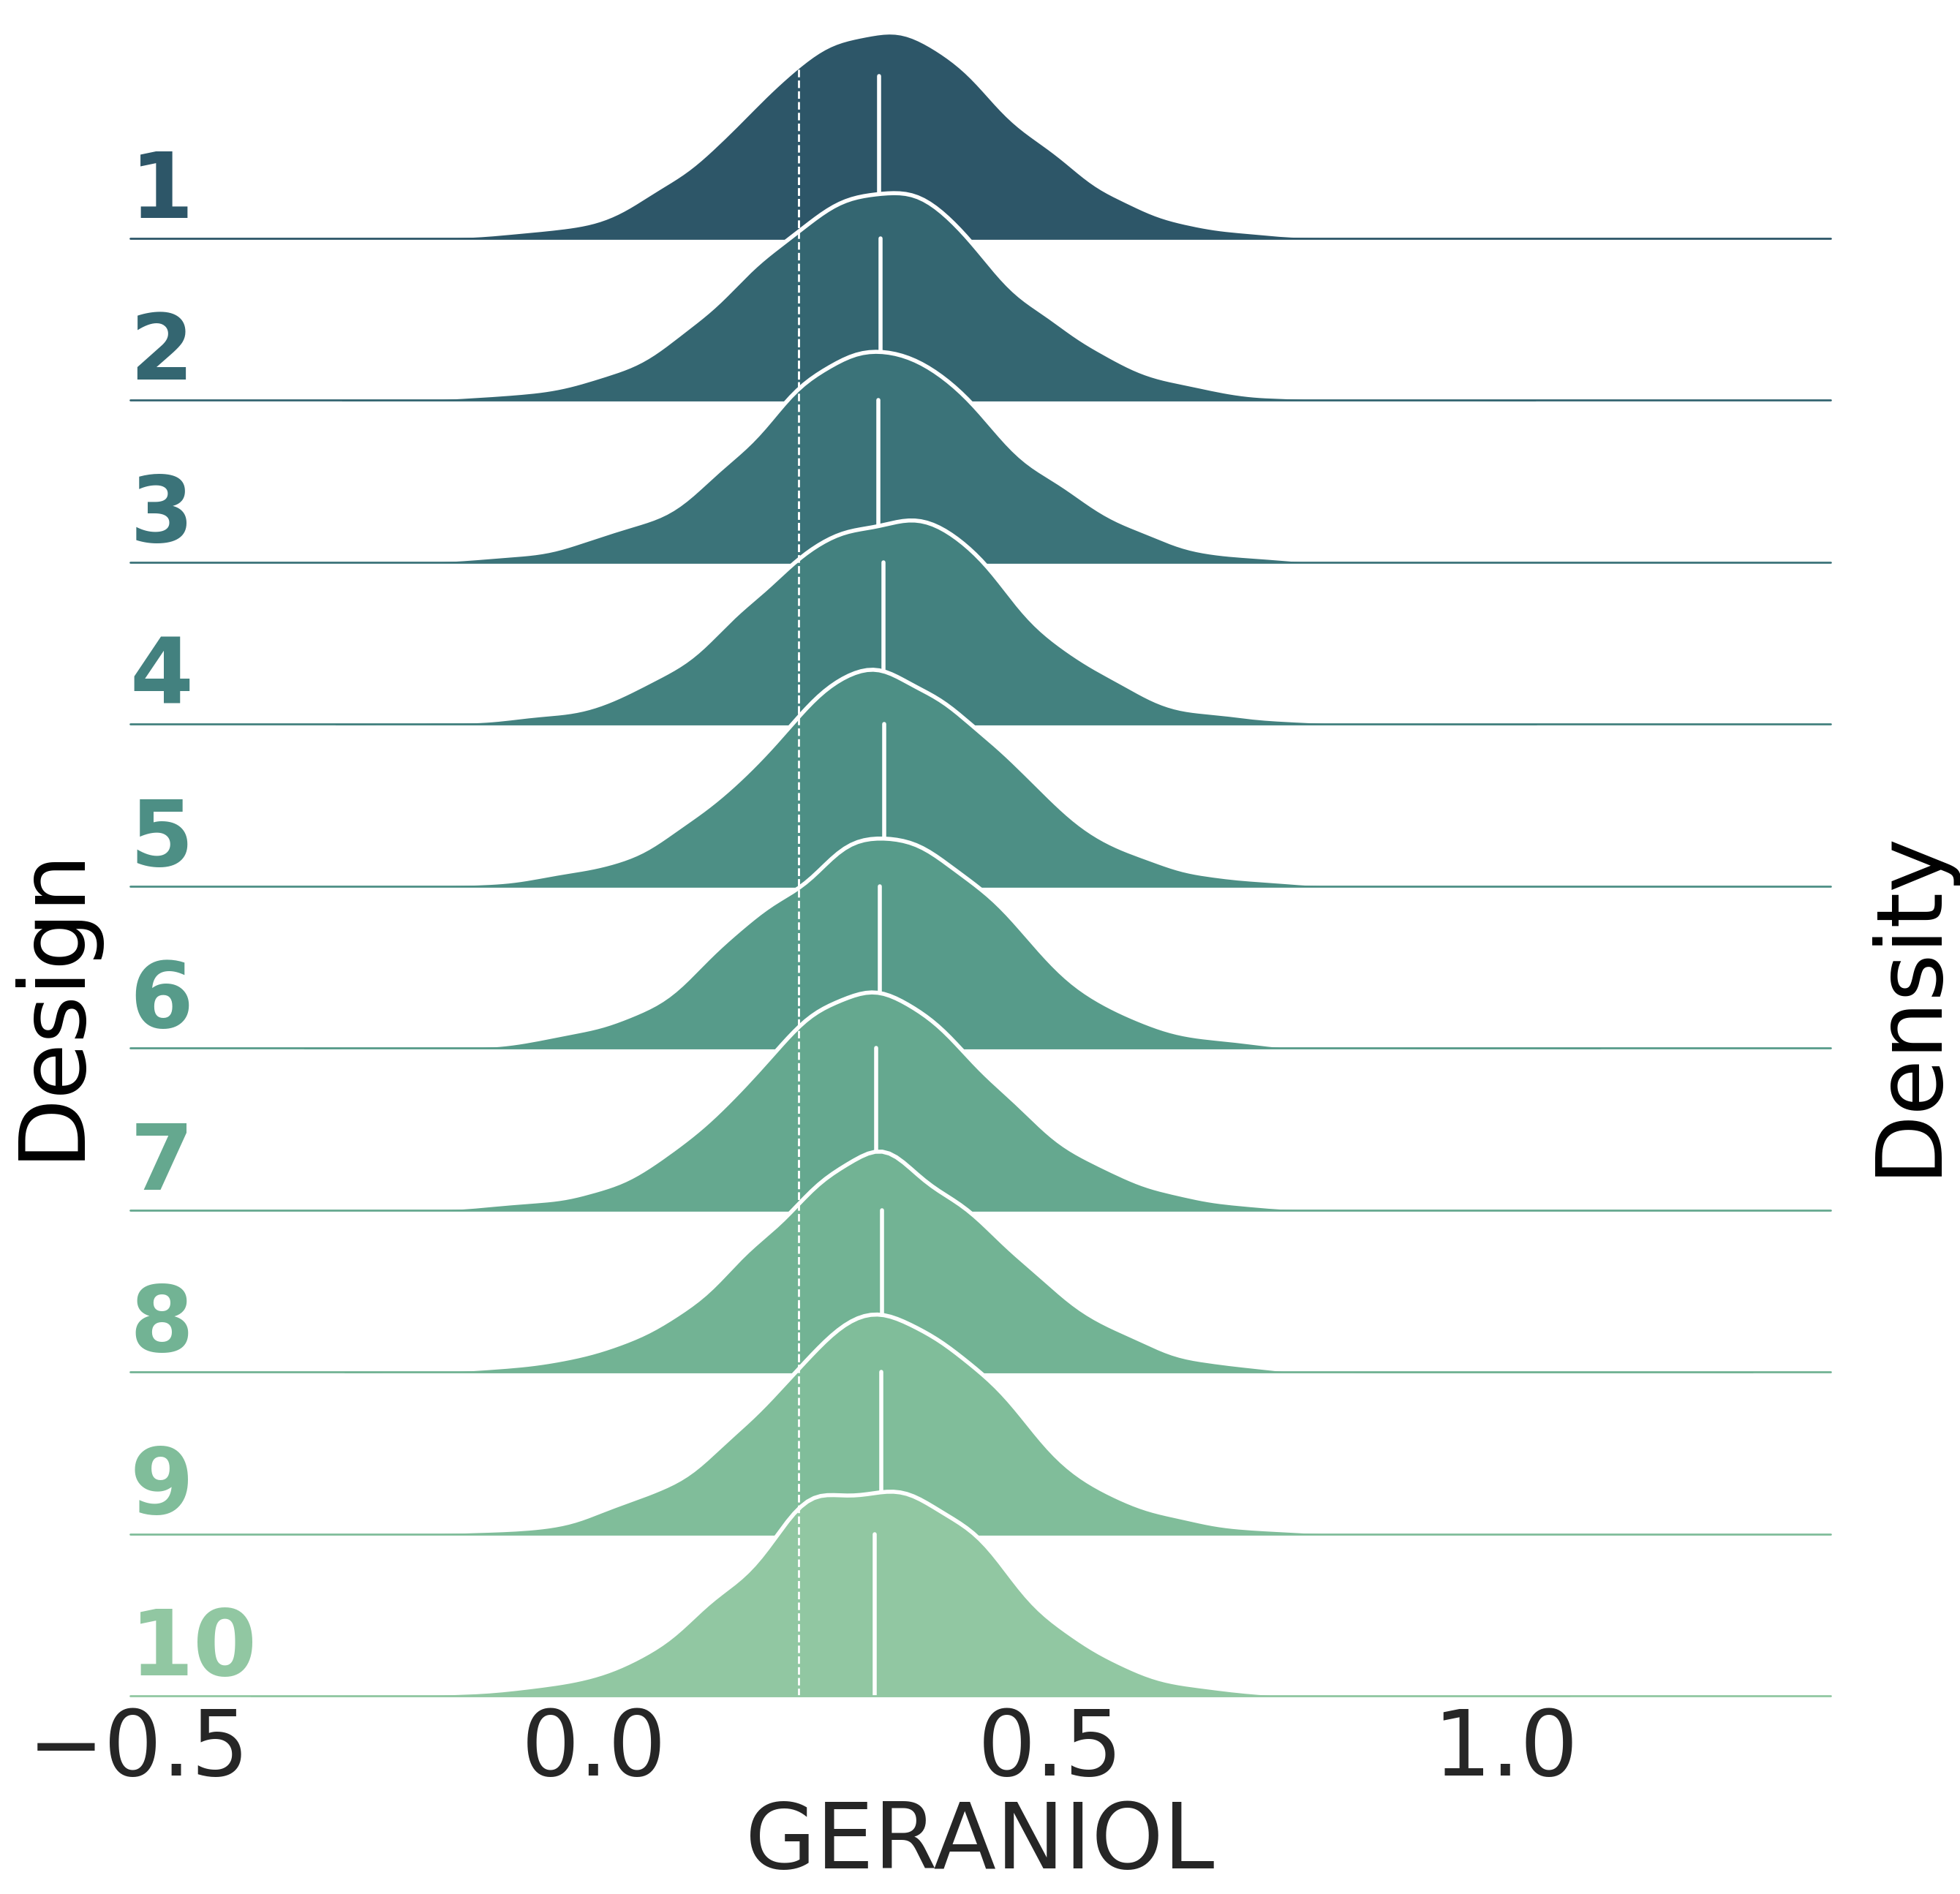

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 1.39 s
Done calculating success probabilities in 1.40 s


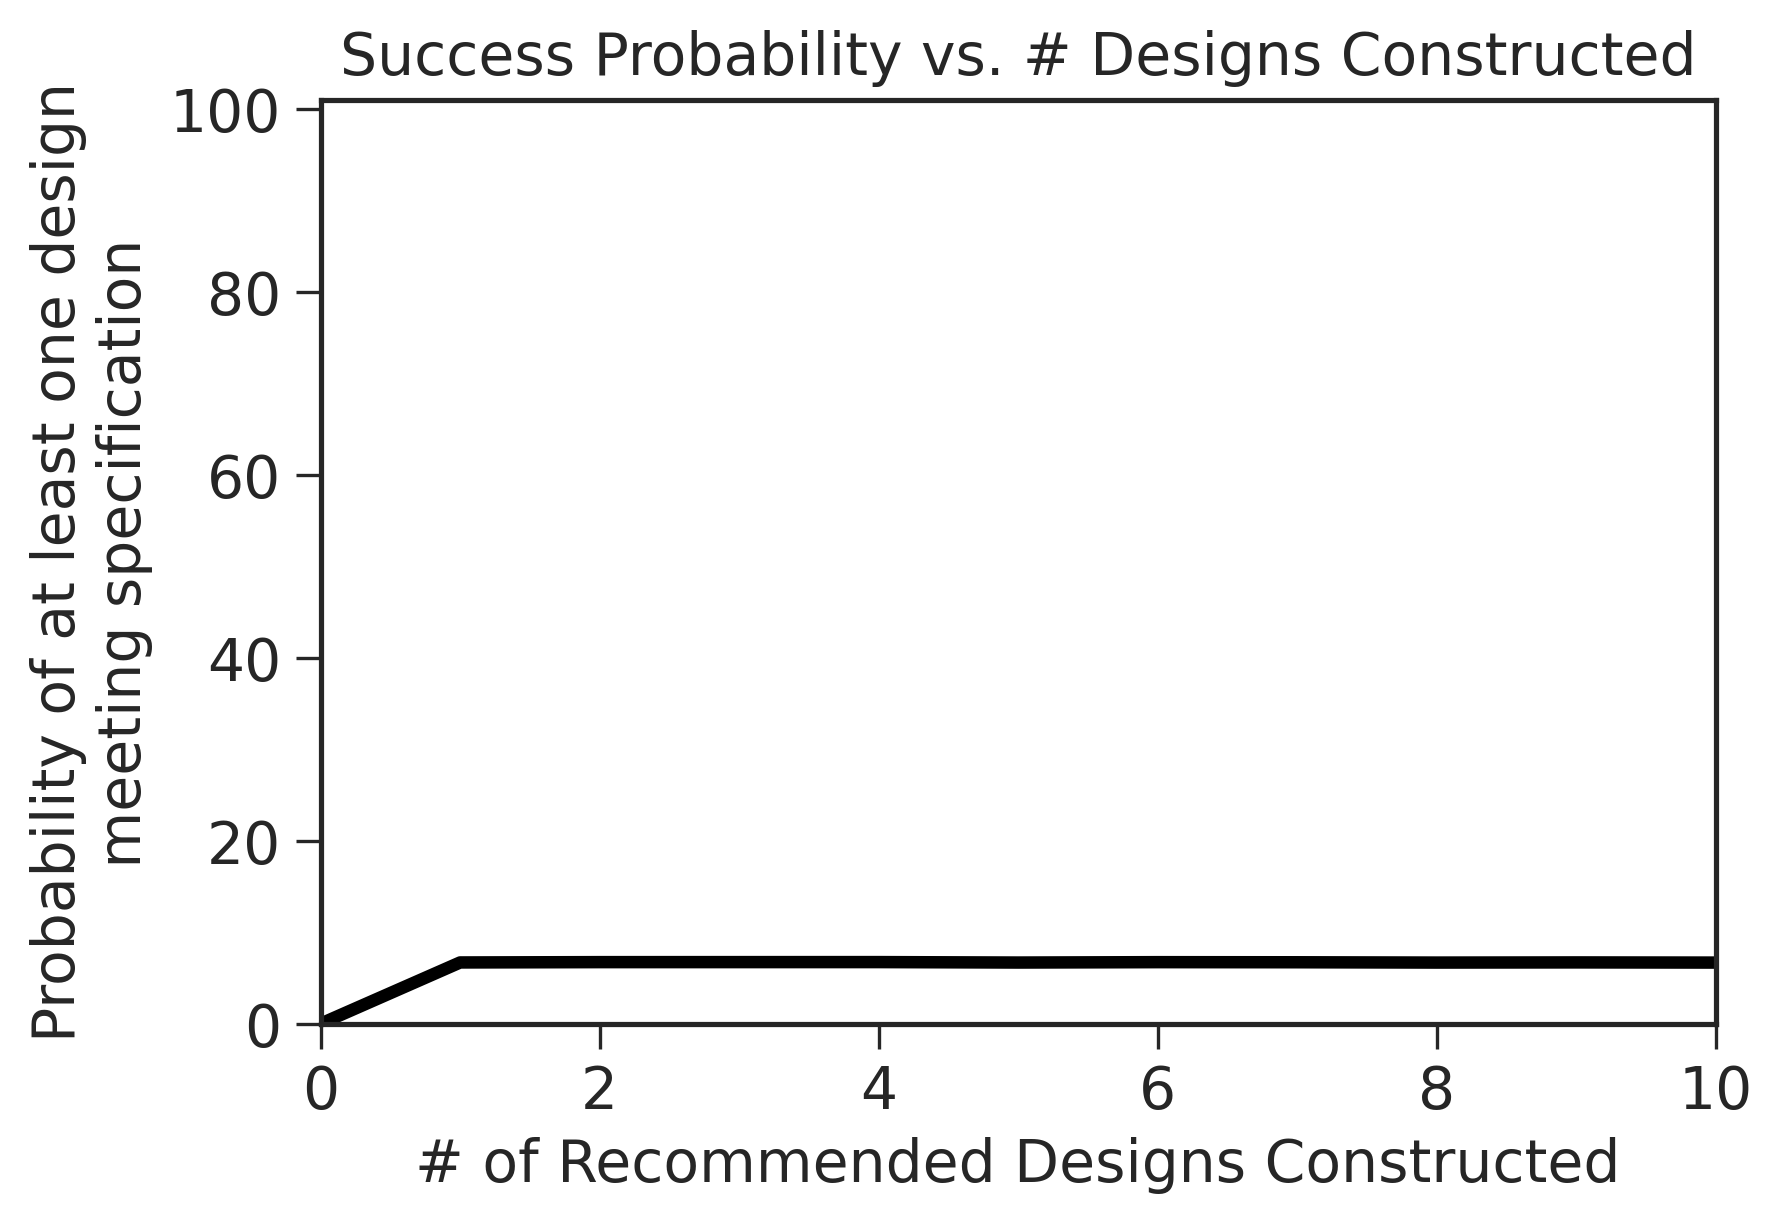

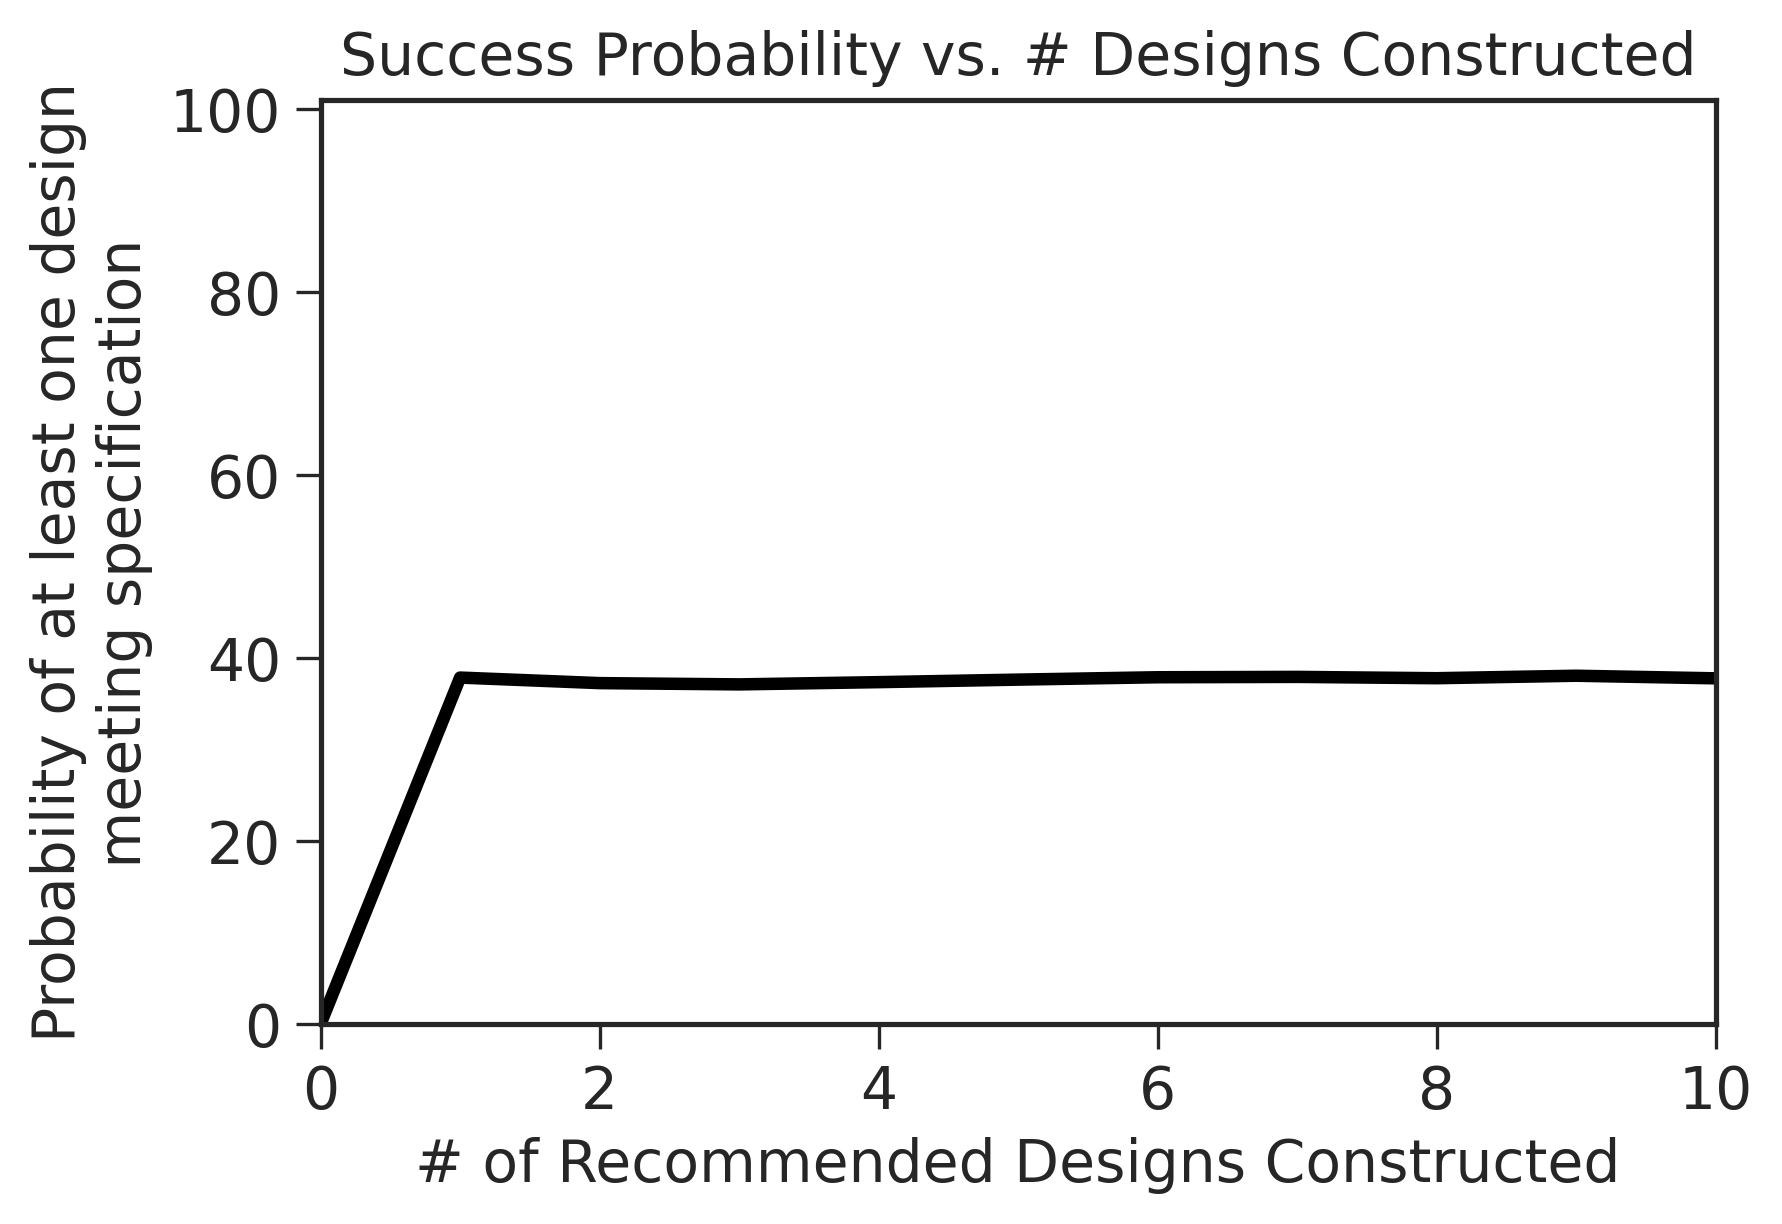

CPU times: user 8.15 s, sys: 1.2 s, total: 9.35 s
Wall time: 3min 43s


[0.205484162, 0.313515363]

In [20]:
%%time
draws = art_1.generate_recommendation_candidates()
art_1.select_recommendations(draws)
art_1.target_values

(Neglected recommendations are those that do not satisfy the relative recommendations distance requirement)

The Table above provides a set of predictions which if followed should maximize the chance of successful strain engineering.

In [22]:
rec_pale_ale_C1 = art_1.recommendations[['Linalool','GERANIOL']].values

### Optimize for **Hop Hunter** beer.

In [23]:
art_1.target_values = target_dict['hop hunter']
art_1.result_suffix = '_HH_C1'

Starting parallel tempering using 2 chains…
Done with parallel tempering in 212.43 s
Choosing recommendations (19,800 candidates)…


Done choosing recommendations in 0.02 s


R-linalool synthase, chloroplastic  Geraniol synthase, chloroplastic  \
0                          864.098039                       3655.219318   
1                         1134.886042                       3830.148086   
2                         1513.904051                       3748.441103   
3                         1501.950812                       3760.616530   
4                          819.393850                       3245.308501   
5                          967.261311                       2505.264889   
6                         1825.613870                       3796.346862   
7                         1921.544810                       3754.475354   
8                         1409.097833                       2496.116910   
9                         1096.582026                       3013.663425   

   Farnesyl pyrophosphate synthase  Hydroxymethylglutaryl-CoA synthase  \
0                     64557.147129                        43227.715344   
1                     54627.967550                        45733.865719   
2                     64253.996603                        39046.199166   
3                     49838.065021                        46067.874197   
4                     51051.674530                        48388.638251   
5                     54813.741572                        40516.350096   
6                     47379.133567                        47061.975584   
7                     64539.806567                        36683.263882   
8                     53145.263890                        38470.589594   
9                     62574.718256                        44290.446246   

   Linalool  GERANIOL  
0  1.483293  0.482758  
1  1.443630  0.475289  
2  1.471107  0.472921  
3  1.462107  0.471293  
4  1.468116  0.469590  
5  1.417782  0.467236  
6  1.510521  0.469075  
7  1.486293  0.465077  
8  1.428957  0.463691  
9  1.597995  0.470701

Sampling: [y]


Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 1.34 s


/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

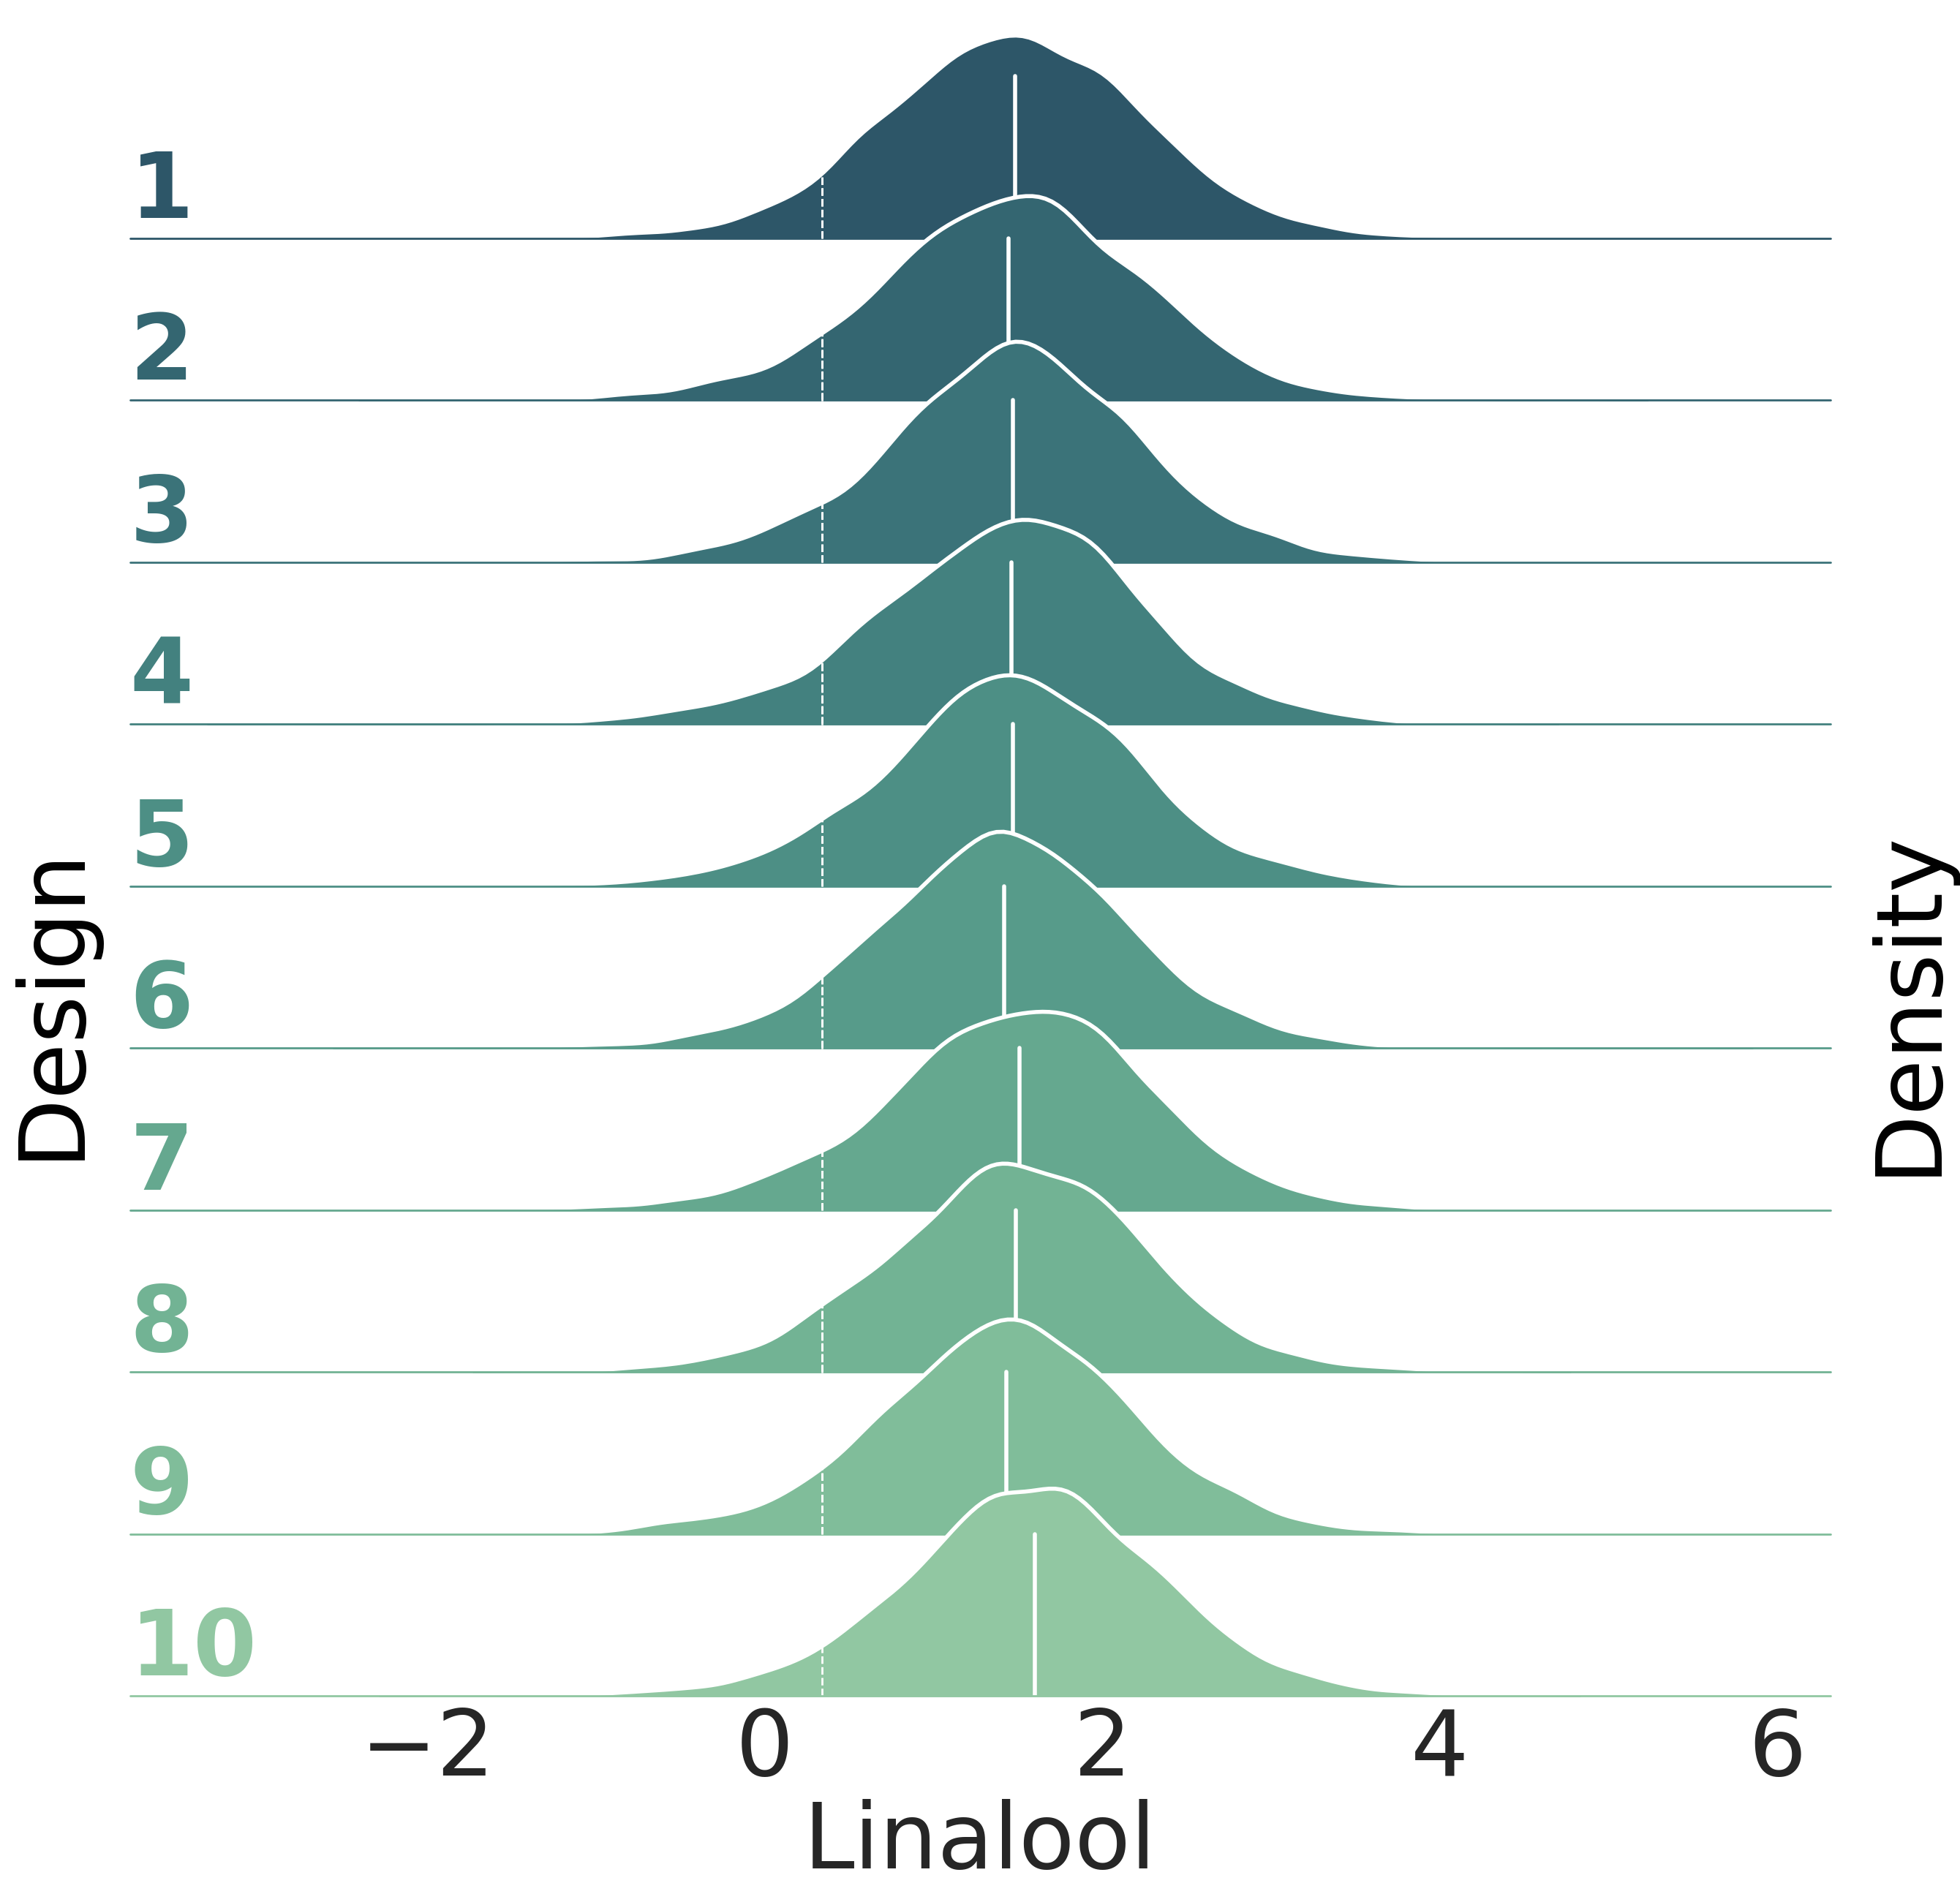

/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

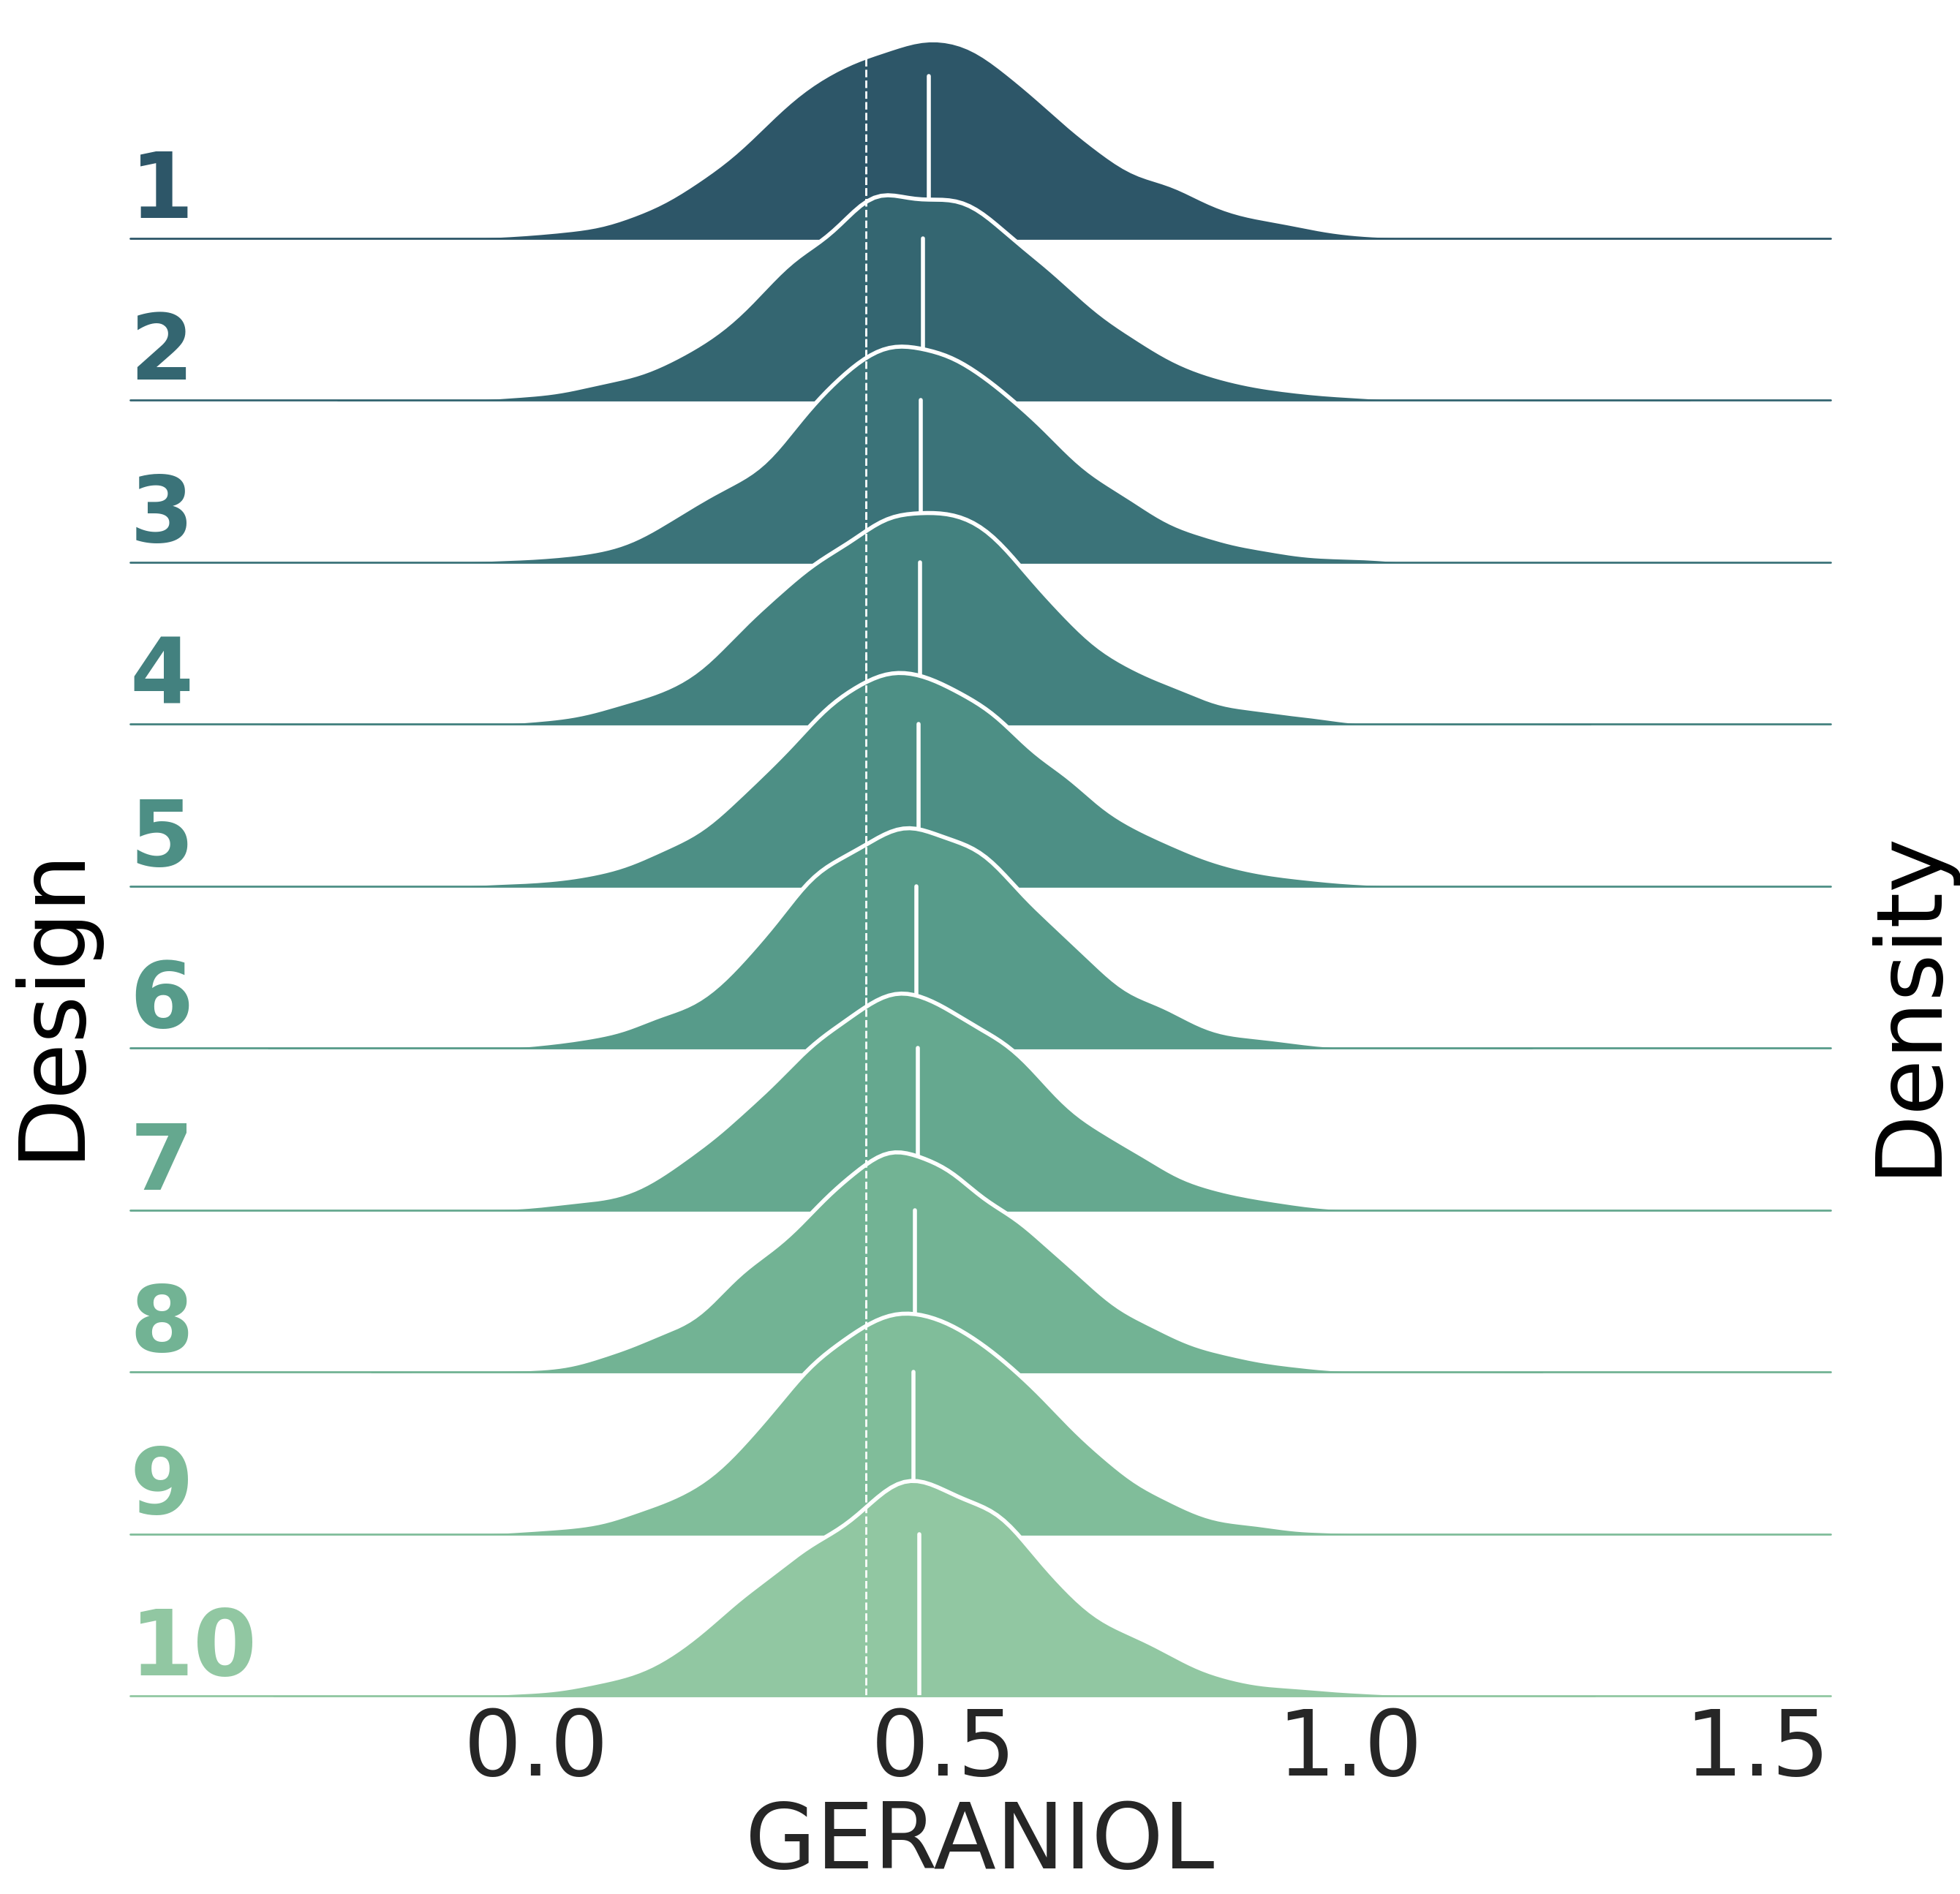

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 1.35 s
Done calculating success probabilities in 1.36 s


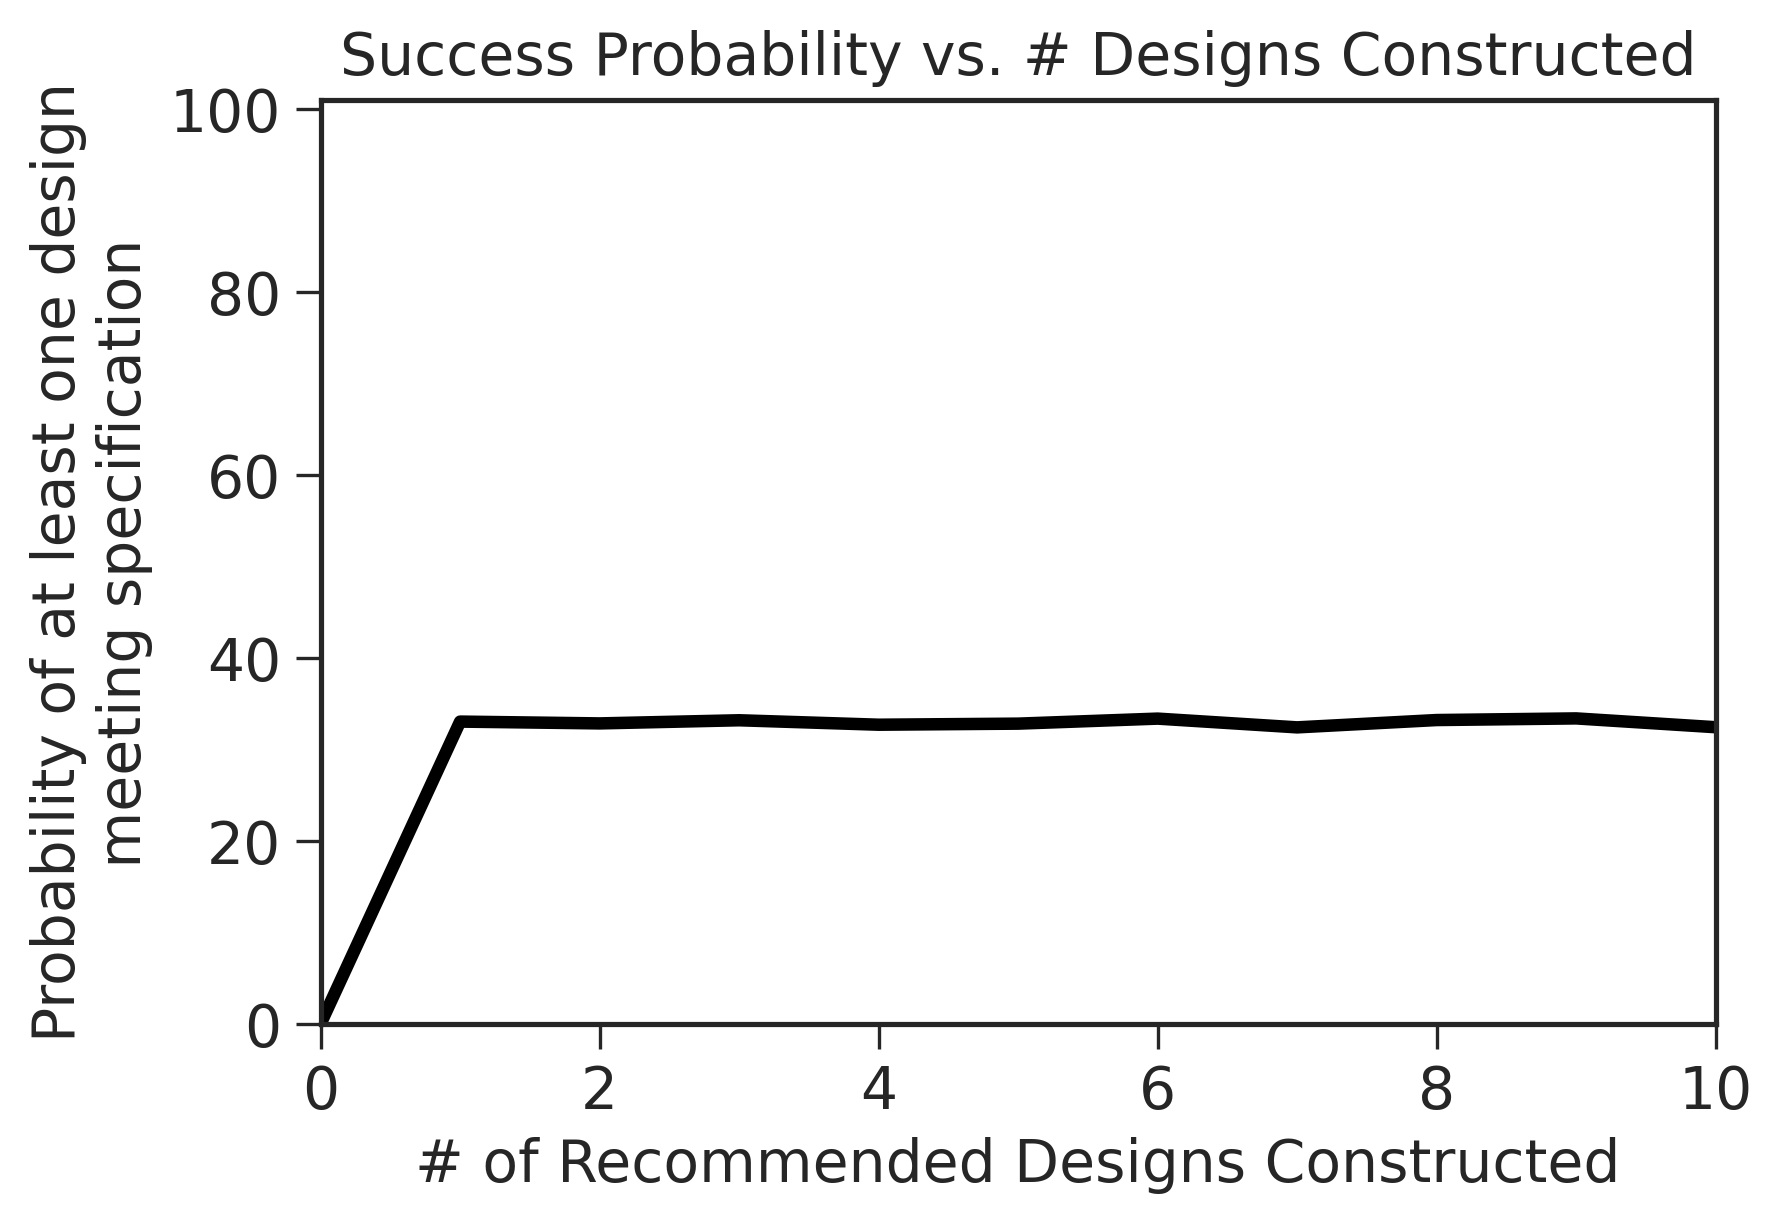

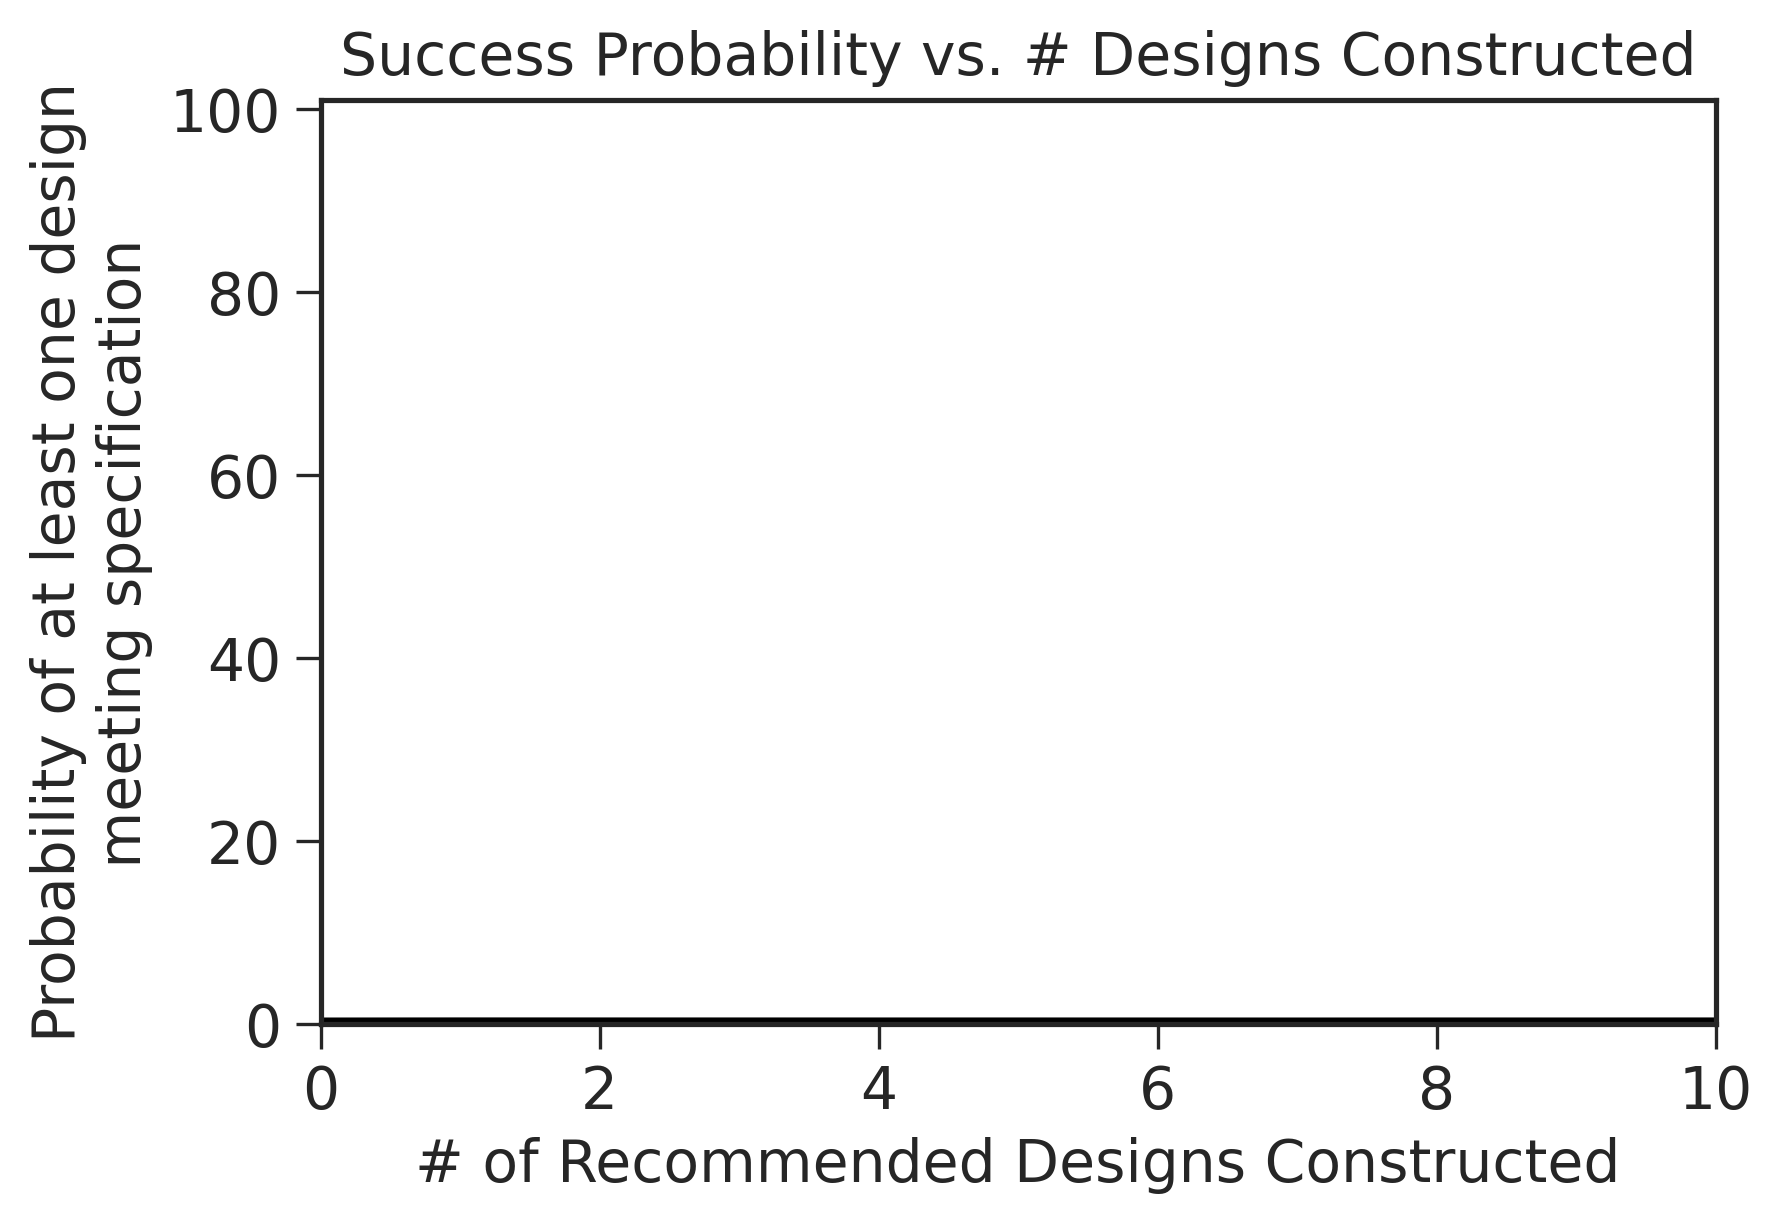

[1.425741149, 1.917484004]

In [24]:
draws = art_1.generate_recommendation_candidates()
art_1.select_recommendations(draws)
art_1.target_values

In [26]:
rec_hop_hunter_C1 = art_1.recommendations[['Linalool','GERANIOL']].values

### Optimize for **Torpedo** beer.

In [27]:
art_1.target_values = target_dict['torpedo']
art_1.result_suffix = '_T_C1'

Starting parallel tempering using 2 chains…
Done with parallel tempering in 207.51 s
Choosing recommendations (19,800 candidates)…


Done choosing recommendations in 0.01 s


R-linalool synthase, chloroplastic  Geraniol synthase, chloroplastic  \
0                         1497.884628                       2321.945608   
1                         1811.000530                       2431.464380   
2                          792.924137                       3263.847209   
3                          987.827979                       3698.078215   
4                         1208.364546                       3003.024018   
5                         1727.193601                       3615.389752   
6                          946.442498                       2042.132216   
7                         1129.480203                       2206.012386   
8                          832.844923                       2546.900054   
9                         1605.070885                       3347.530586   

   Farnesyl pyrophosphate synthase  Hydroxymethylglutaryl-CoA synthase  \
0                     35897.389673                        24323.179353   
1                     37309.210814                        22659.812722   
2                     45103.605188                        29347.062644   
3                     41520.945940                        29507.262143   
4                     38582.600882                        27177.833713   
5                     46138.908115                        24071.226284   
6                     38442.229302                        26603.483241   
7                     45320.115092                        20930.217212   
8                     31273.079274                        29802.588438   
9                     36011.053160                        26895.837703   

   Linalool  GERANIOL  
0  0.536969  0.454472  
1  0.544092  0.452196  
2  0.553134  0.452957  
3  0.496015  0.453278  
4  0.527640  0.445864  
5  0.539542  0.445396  
6  0.552887  0.445840  
7  0.486359  0.450067  
8  0.482970  0.450768  
9  0.513163  0.442409

Sampling: [y]


Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 1.36 s


/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

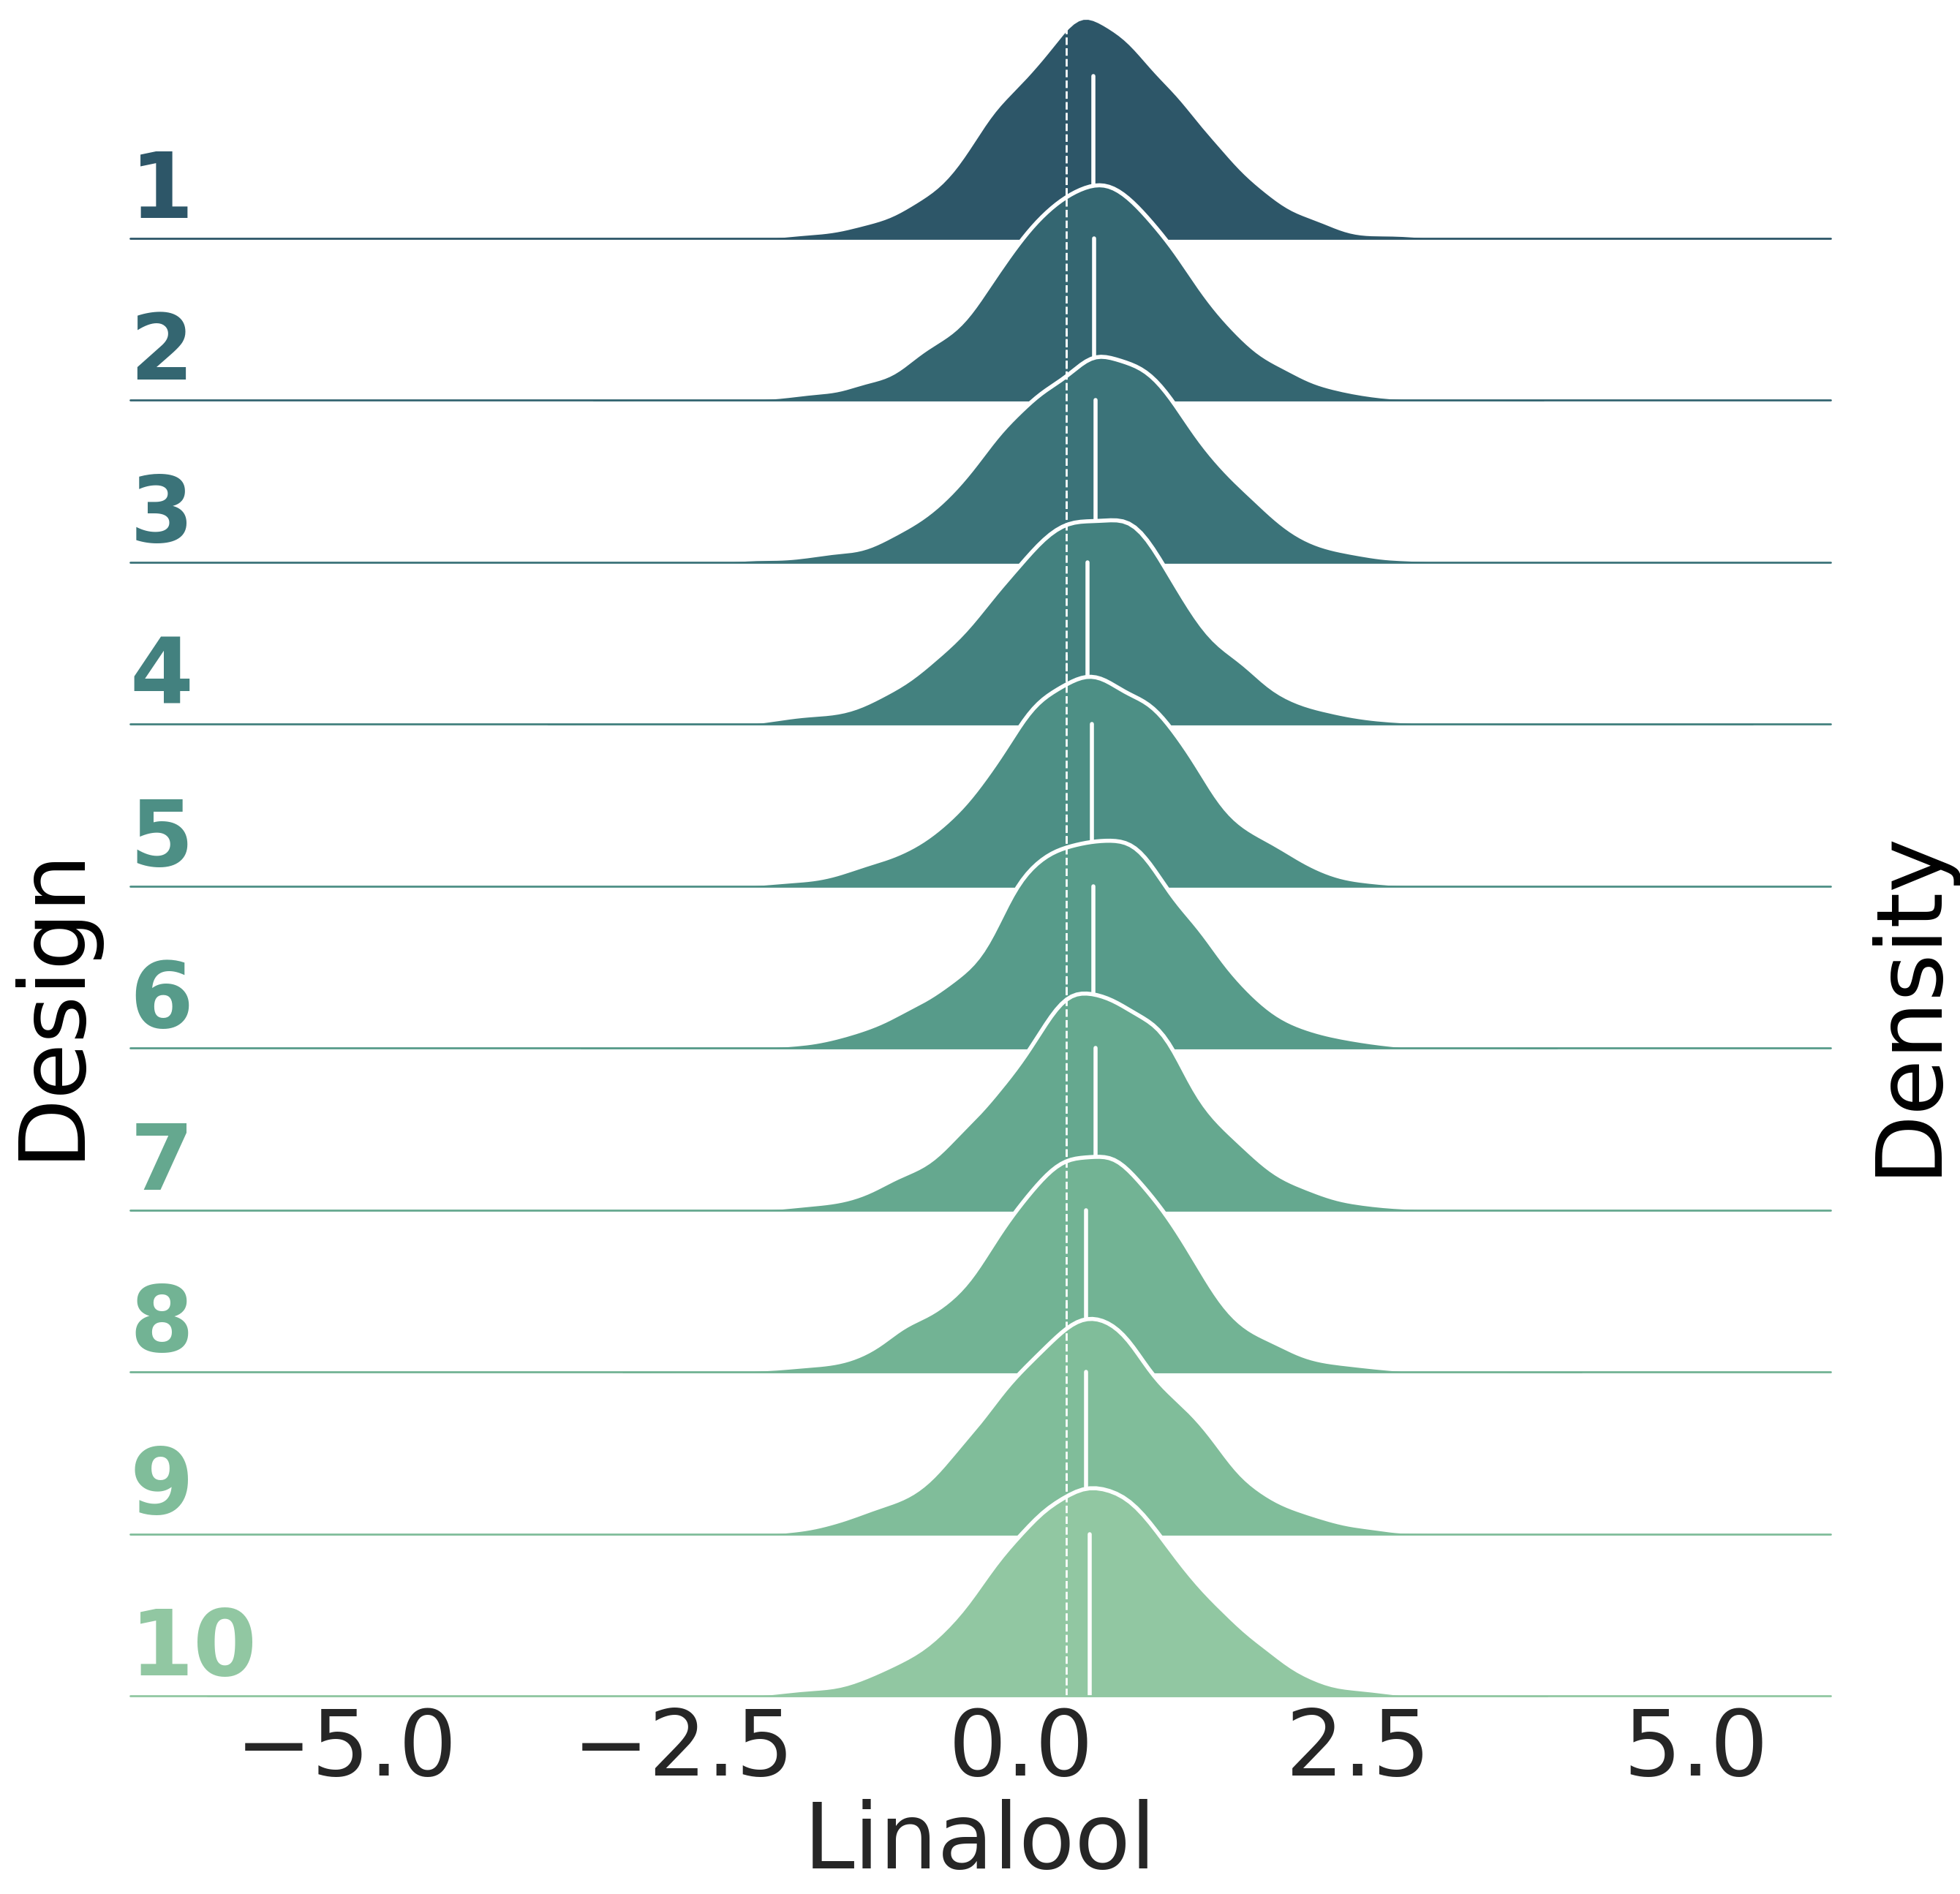

/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

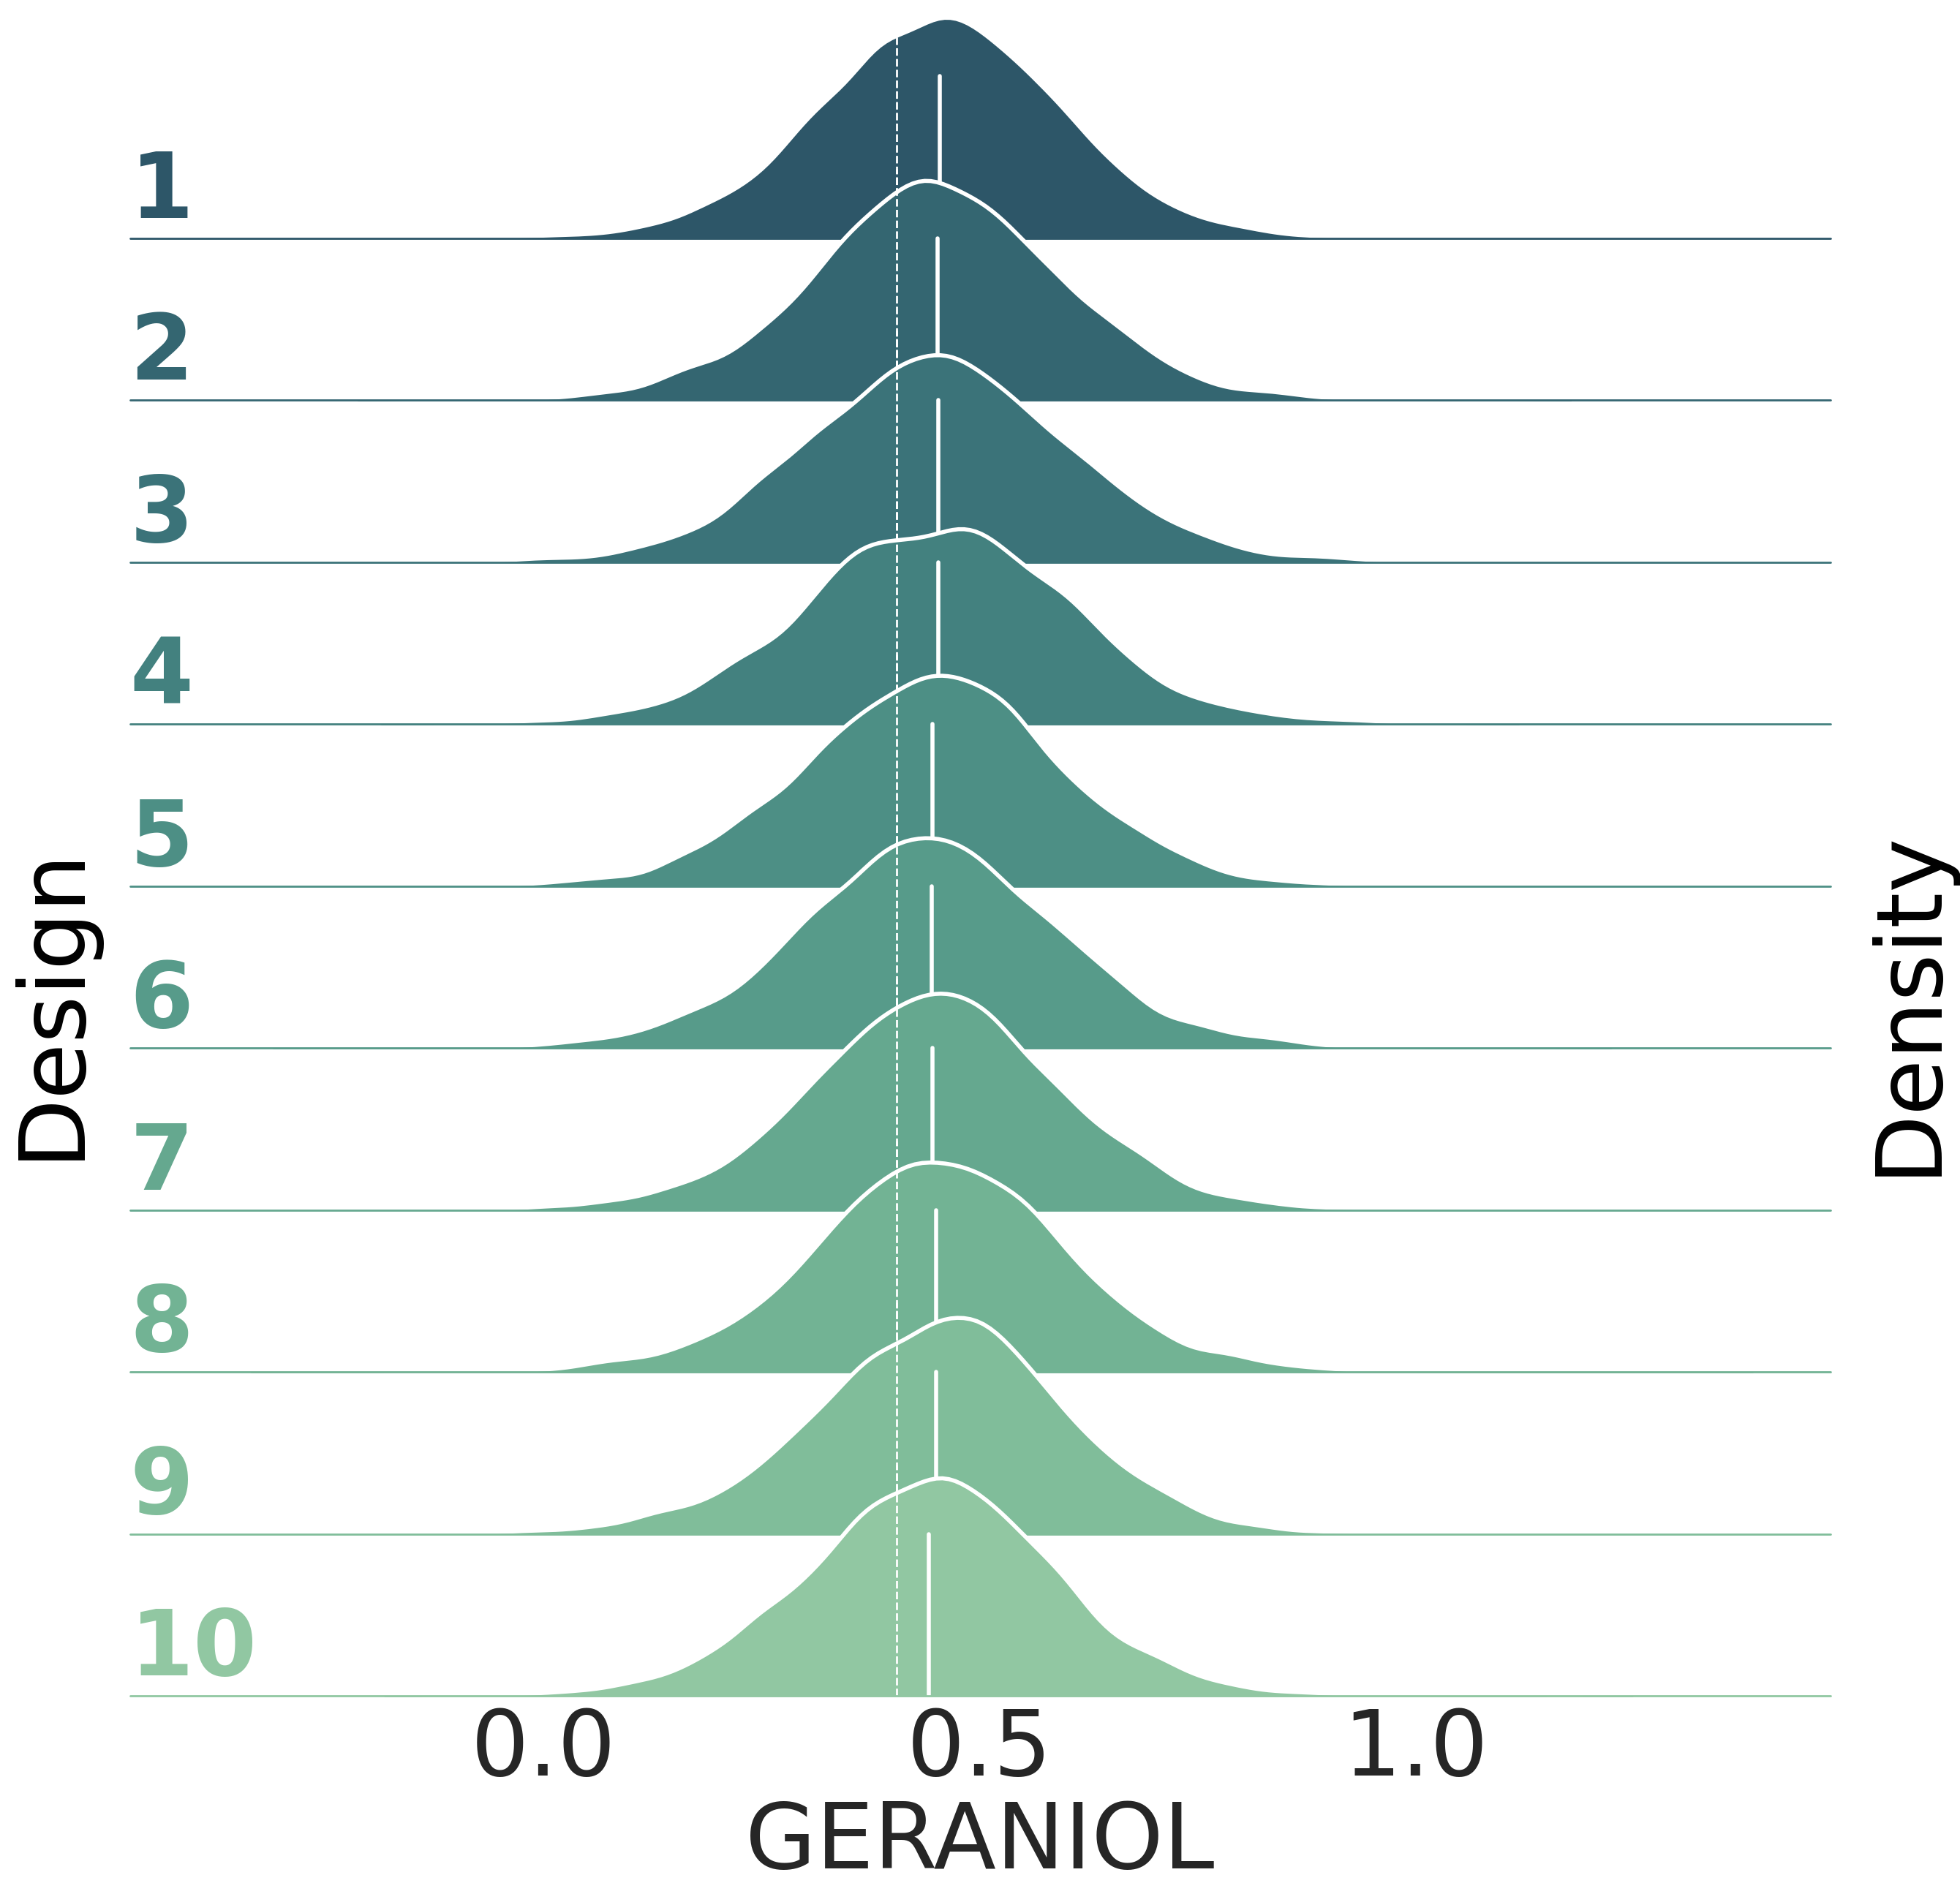

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 1.35 s
Done calculating success probabilities in 1.37 s


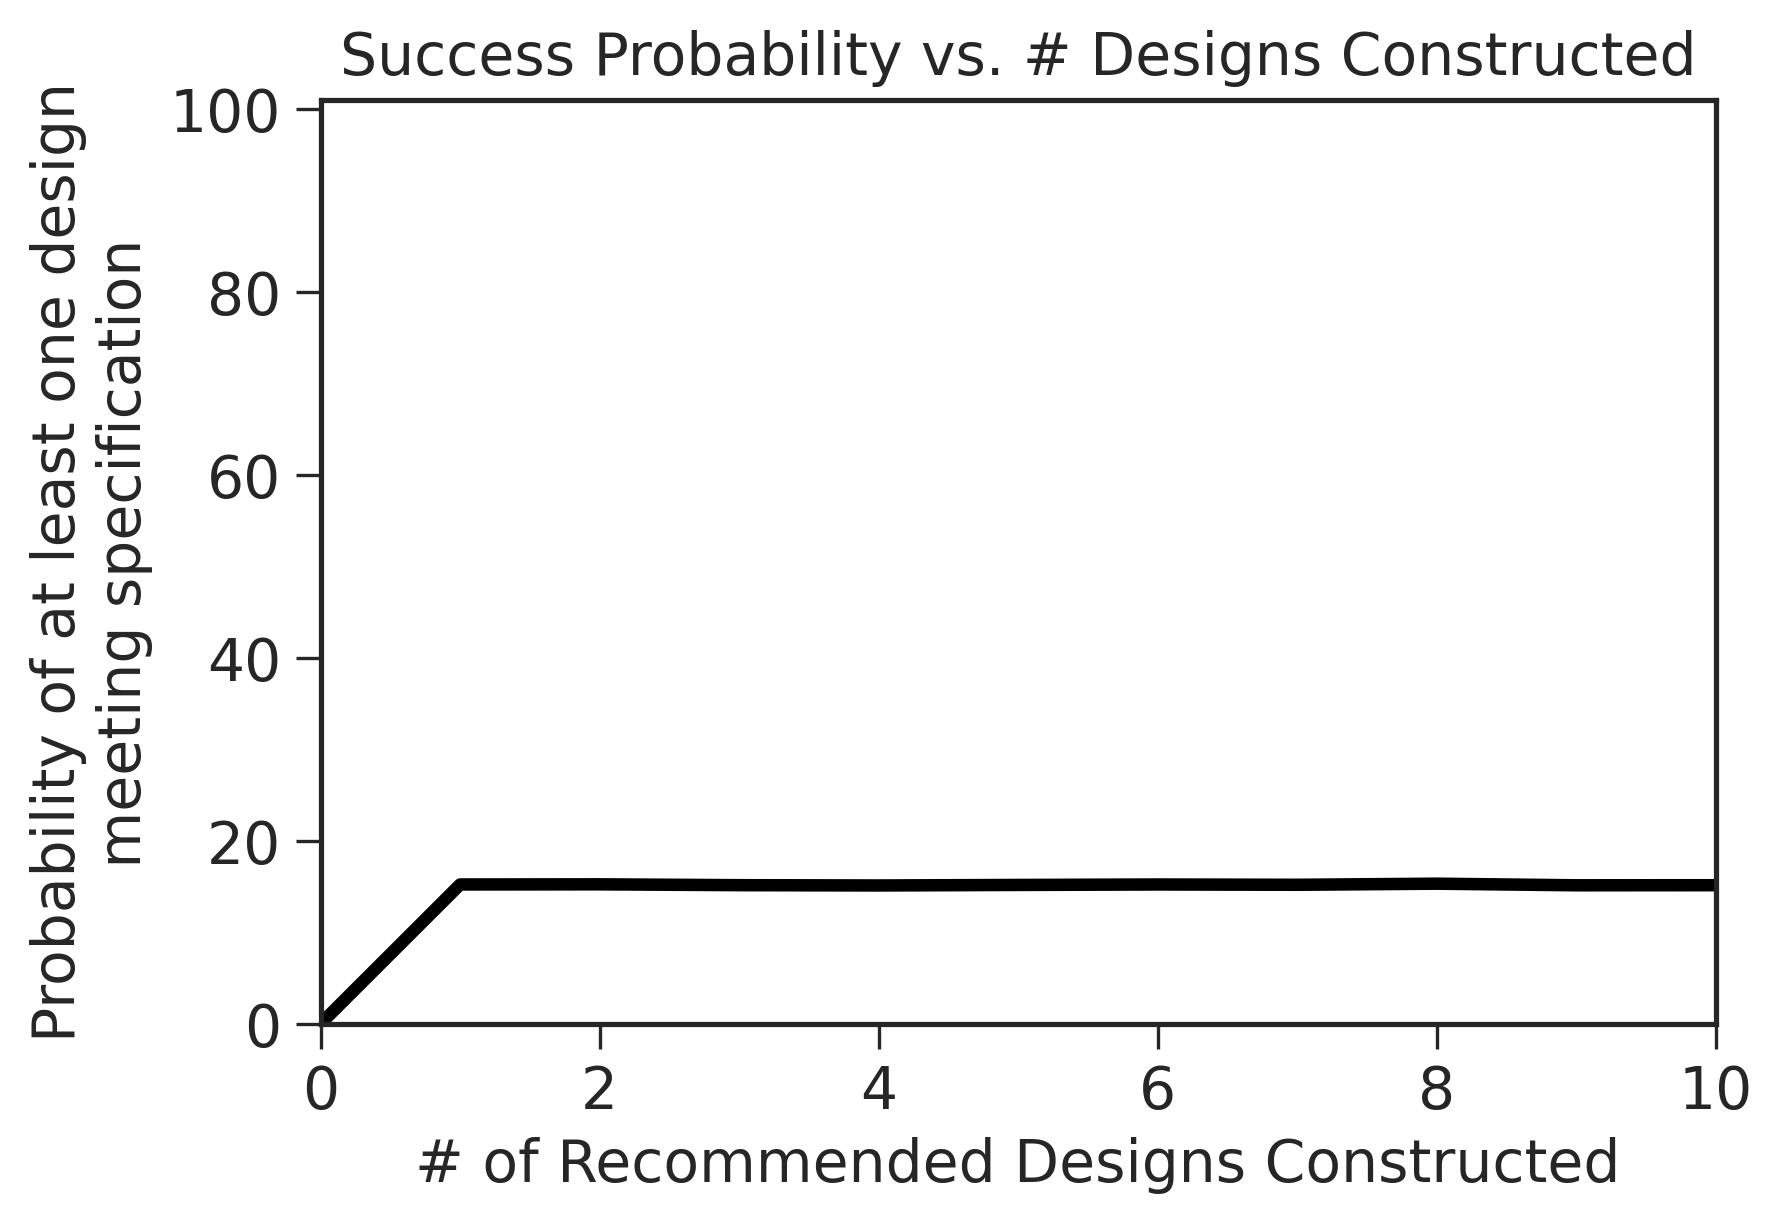

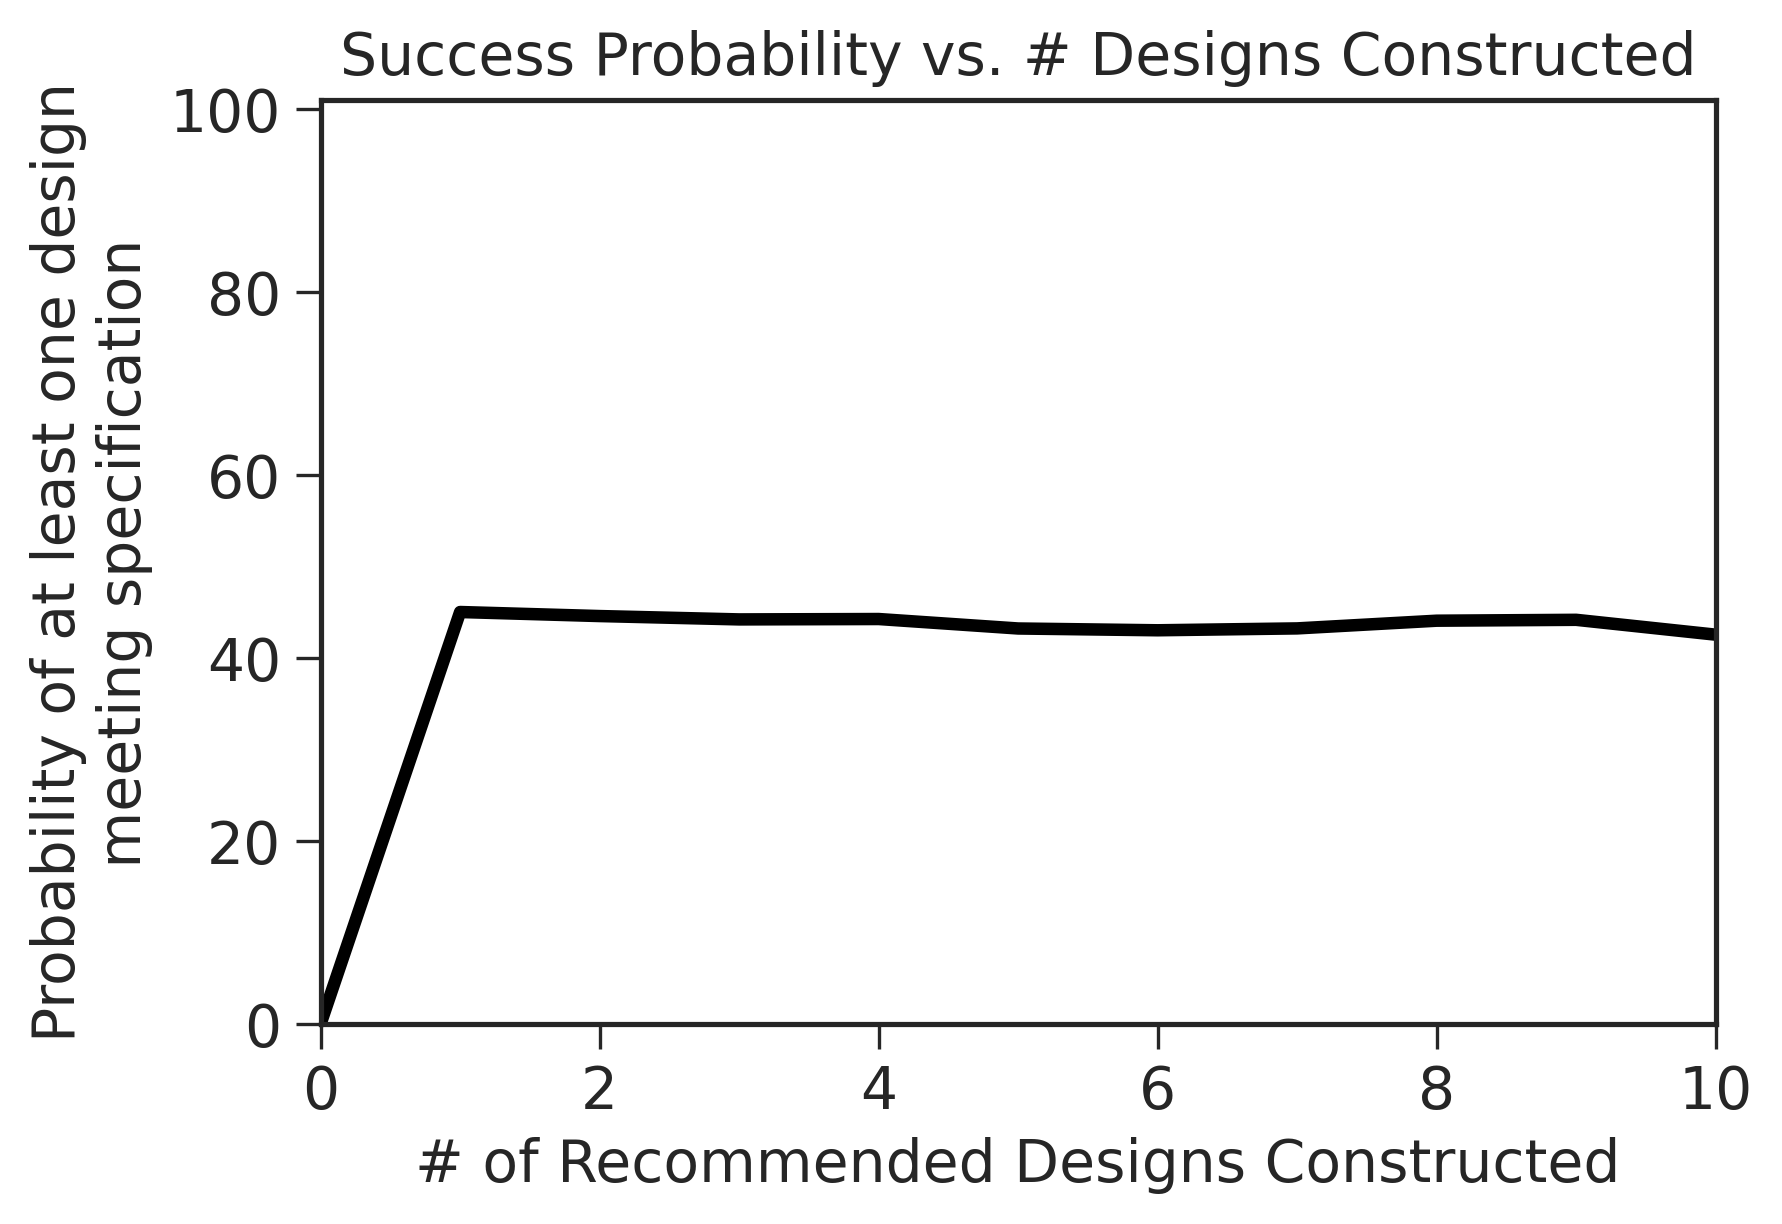

[0.531025331, 0.569713904]

In [28]:
draws = art_1.generate_recommendation_candidates()
art_1.select_recommendations(draws)
art_1.target_values

In [30]:
rec_torpedo_C1 = art_1.recommendations[['Linalool','GERANIOL']].values

In [31]:
art_1.recs = {
    'pale ale':     rec_pale_ale_C1, #Pale Ale
    'hop hunter':   rec_hop_hunter_C1, #Hop Hunter
    'torpedo':      rec_torpedo_C1,
}
art_1.result_suffix = '_C1'
art_1.save()

## Data from Cycle 1 and Cycle 2

In [34]:
# art = cloudpickle.load( open( output_dir + '/art_C2.cpkl', "rb" ) )
# art.out_dir = output_dir


ART identified 50 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: LinearSVR(input_matrix, C=1.0, dual=True, epsilon=0.001, loss=epsilon_insensitive, tol=1e-05)
Building TPOT models…


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RandomForestRegressor(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), bootstrap=False, max_features=0.8, min_samples_leaf=4, min_samples_split=9, n_estimators=100)
Done fitting L0 models in 44.91 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinea

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 30.75 s
Fitting L0 models…
Building TPOT models…
Best pipeline: RandomForestRegressor(RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.4, min_samples_leaf=14, min_samples_split=12, n_estimators=100), bootstrap=False, max_features=0.7000000000000001, min_samples_leaf=4, min_samples_split=20, n_estimators=100)
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=4, min_samples_leaf=3, min_samples_split=12)
Done fitting L0 models in 20.88 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 28.82 s
Fitting L0 models…
Building TPOT models…
Best pipeline: RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.7500000000000001, min_samples_leaf=4, min_samples_split=7, n_estimators=100)
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.9500000000000001, min_samples_leaf=4, min_samples_split=8, n_estimators=100)
Done fitting L0 models in 41.09 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 27.19 s
Fitting L0 models…
Building TPOT models…
Best pipeline: RandomForestRegressor(StandardScaler(input_matrix), bootstrap=True, max_features=0.7500000000000001, min_samples_leaf=8, min_samples_split=9, n_estimators=100)
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=1, min_samples_leaf=7, min_samples_split=20)
Done fitting L0 models in 11.09 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 30.33 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.5, max_depth=10, min_child_weight=6, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.7000000000000001, verbosity=0)
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: DecisionTreeRegressor(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), max_depth=3, min_samples_leaf=4, min_samples_split=7)
Done fitting L0 models in 12.23 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 28.51 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=3, min_child_weight=8, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.35000000000000003, verbosity=0)
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=7, min_samples_leaf=5, min_samples_split=11)
Done fitting L0 models in 13.42 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 30.13 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=1.0, verbosity=0)
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RandomForestRegressor(XGBRegressor(MaxAbsScaler(input_matrix), learning_rate=0.1, max_depth=3, min_child_weight=11, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.4, verbosity=0), bootstrap=False, max_features=0.8500000000000001, min_samples_leaf=5, min_samples_split=11, n_estimators=100)
Done fitting L0 models in 46.76 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 39.50 s
Fitting L0 models…
Building TPOT models…
Best pipeline: RandomForestRegressor(ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.6000000000000001, min_samples_leaf=8, min_samples_split=2, n_estimators=100), bootstrap=False, max_features=0.6000000000000001, min_samples_leaf=2, min_samples_split=11, n_estimators=100)
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RandomForestRegressor(input_matrix, bootstrap=False, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=100)
Done fitting L0 models in 45.05 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 31.80 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(RobustScaler(input_matrix), learning_rate=0.5, max_depth=2, min_child_weight=3, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.8, verbosity=0)
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(GradientBoostingRegressor(GradientBoostingRegressor(input_matrix, alpha=0.9, learning_rate=0.001, loss=huber, max_depth=7, max_features=0.9000000000000001, min_samples_leaf=5, min_samples_split=7, n_estimators=100, subsample=0.9000000000000001), alpha=0.9, learning_rate=0.001, loss=huber, max_depth=7, max_features=0.9000000000000001, min_samples_leaf=4, min_samples_split=7, n_estimators=100, subsample=0.9000000000000001), learning_rate=0.01, loss=exponential, n_estimators=100)
Done fitting L0 models in 58.54 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 30.62 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.5, max_depth=5, min_child_weight=5, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.8500000000000001, verbosity=0)
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: DecisionTreeRegressor(RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.1, min_samples_leaf=13, min_samples_split=10, n_estimators=100), max_depth=7, min_samples_leaf=2, min_samples_split=8)
Done fitting L0 models in 16.46 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 37.33 s


/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in double_scalars
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


MAE  MRAE(%)     StdAE       MSE     $R^2$
Name                                                                        
Neural Regressor             0.508638      inf  0.851036  0.982974 -0.827235
Random Forest Regressor      0.362606      inf  0.658726  0.565403 -0.051019
Support Vector Regressor     0.279206      inf  0.622927  0.465995  0.133770
Kernel Ridge Regressor       0.333836      inf  0.637749  0.518171  0.036780
K-NN Regressor               0.315629      inf  0.622567  0.487211  0.094331
Gaussian Process Regressor   0.313277      inf  0.656867  0.529617  0.015504
Gradient Boosting Regressor  0.387899      inf  0.759320  0.727032 -0.351468
TPOT Regressor               0.394670      inf  0.672822  0.608454 -0.131045
Ensemble Model               0.332634      inf  0.654402  0.538888 -0.001730

/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in double_scalars
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


MAE  MRAE(%)     StdAE       MSE     $R^2$
Name                                                                        
Neural Regressor             0.222447      inf  0.250423  0.112194 -0.047983
Random Forest Regressor      0.167362      inf  0.223620  0.078016  0.271270
Support Vector Regressor     0.180638      inf  0.227323  0.084306  0.212517
Kernel Ridge Regressor       0.185408      inf  0.217029  0.081478  0.238934
K-NN Regressor               0.196237      inf  0.221969  0.087779  0.180073
Gaussian Process Regressor   0.192990      inf  0.238063  0.093919  0.122723
Gradient Boosting Regressor  0.178606      inf  0.249339  0.094070  0.121313
TPOT Regressor               0.181727      inf  0.220800  0.081778  0.236134
Ensemble Model               0.170129      inf  0.221336  0.077934  0.272037

Done with 10-fold cross-validation in 1136.60 s


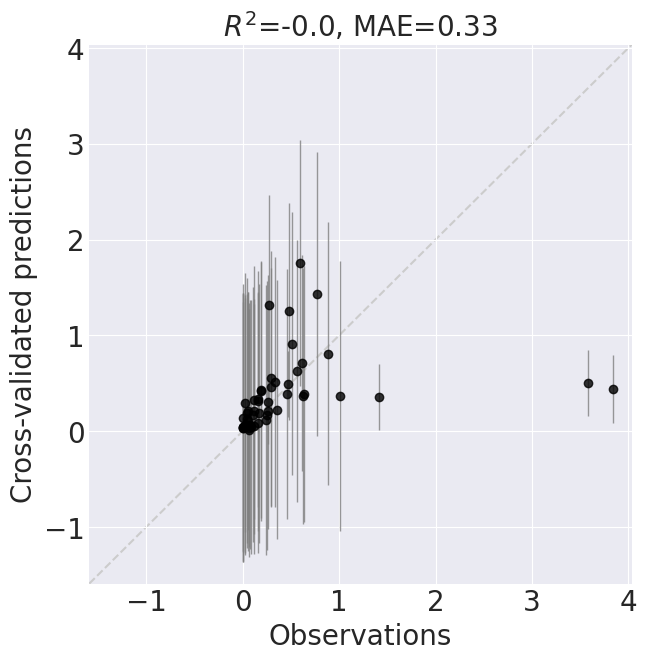

output_dir: ../../results/Hopless_beer_02_19_seed10  Exists? True
file_path: ../../results/Hopless_beer_02_19_seed10/predictions_vs_observations_cv_Linalool.png  Exists? False


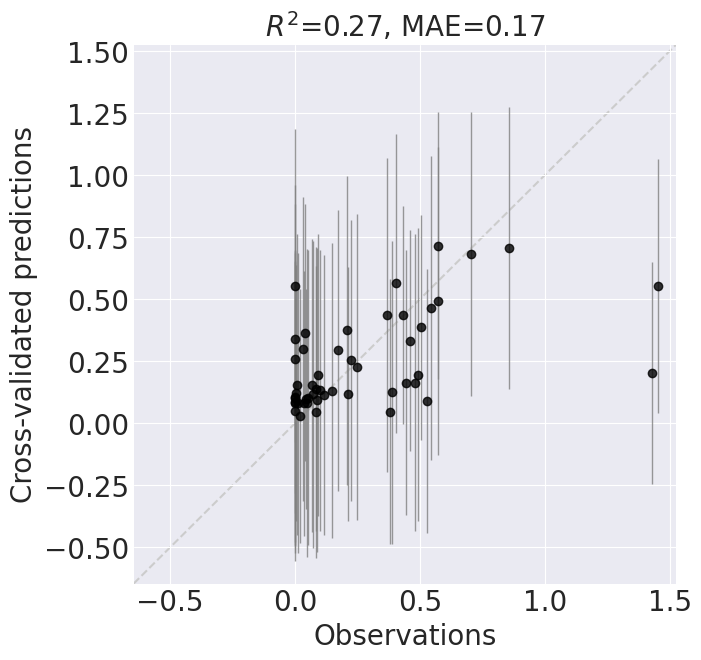

output_dir: ../../results/Hopless_beer_02_19_seed10  Exists? True
file_path: ../../results/Hopless_beer_02_19_seed10/predictions_vs_observations_cv_GERANIOL.png  Exists? True
Building models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: LinearSVR(input_matrix, C=0.0001, dual=True, epsilon=0.001, loss=epsilon_insensitive, tol=0.0001)
Building TPOT models…


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RandomForestRegressor(LassoLarsCV(input_matrix, normalize=False), bootstrap=False, max_features=0.8500000000000001, min_samples_leaf=5, min_samples_split=2, n_estimators=100)
Done fitting L0 models in 48.20 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinea

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 33.58 s


/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in double_scalars
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


MAE  MRAE(%)         StdAE  \
Name                                                               
Neural Regressor             1.032053e-01      inf  1.211963e-01   
Random Forest Regressor      1.400232e-01      inf  2.228248e-01   
Support Vector Regressor     2.077894e-01      inf  5.235662e-01   
Kernel Ridge Regressor       2.433510e-01      inf  4.246391e-01   
K-NN Regressor               2.317348e-01      inf  4.670724e-01   
Gaussian Process Regressor   8.665309e-10      inf  1.738686e-09   
Gradient Boosting Regressor  9.013941e-03      inf  7.949845e-03   
TPOT Regressor               3.815249e-01      inf  5.514368e-01   
Ensemble Model               1.349091e-01      inf  2.464106e-01   

                                      MSE     $R^2$  
Name                                                 
Neural Regressor             2.533990e-02  0.952896  
Random Forest Regressor      6.925738e-02  0.871259  
Support Vector Regressor     3.172980e-01  0.410180  
Kernel Ridge Regressor       2.395381e-01  0.554726  
K-NN Regressor               2.718577e-01  0.494648  
Gaussian Process Regressor   3.773904e-18  1.000000  
Gradient Boosting Regressor  1.444512e-04  0.999731  
TPOT Regressor               4.496439e-01  0.164164  
Ensemble Model               7.891867e-02  0.853299

/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in double_scalars
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


MAE  MRAE(%)     StdAE       MSE     $R^2$
Name                                                                        
Neural Regressor             0.151734      inf  0.200599  0.063263  0.409073
Random Forest Regressor      0.060314      inf  0.077410  0.009630  0.910048
Support Vector Regressor     0.124210      inf  0.186129  0.050072  0.532287
Kernel Ridge Regressor       0.152915      inf  0.184751  0.057516  0.462754
K-NN Regressor               0.165395      inf  0.188411  0.062854  0.412891
Gaussian Process Regressor   0.001103      inf  0.001608  0.000004  0.999964
Gradient Boosting Regressor  0.008058      inf  0.005221  0.000092  0.999139
TPOT Regressor               0.108467      inf  0.133958  0.029710  0.722485
Ensemble Model               0.085585      inf  0.112432  0.019966  0.813504

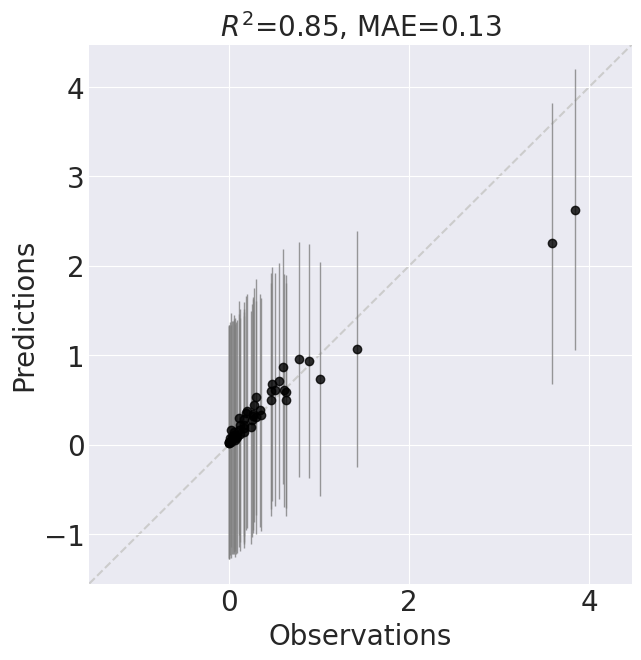

output_dir: ../../results/Hopless_beer_02_19_seed10  Exists? True
file_path: ../../results/Hopless_beer_02_19_seed10/predictions_vs_observations_Linalool.png  Exists? True


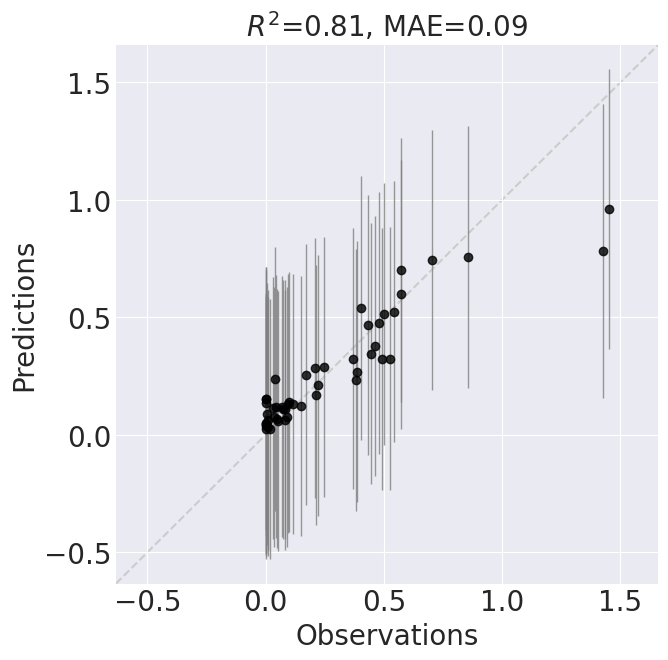

output_dir: ../../results/Hopless_beer_02_19_seed10  Exists? True
file_path: ../../results/Hopless_beer_02_19_seed10/predictions_vs_observations_GERANIOL.png  Exists? True
Done building models in 157.21 s


In [35]:
df = pd.concat((df_1, df_2))

art_params['build_model'] = True

art_2 = RecommendationEngine(df=df, result_suffix='_C2', **art_params)


In [36]:
display(HTML('Evaluation of learned predictive models:'))
art_2.evaluate_models_cv()

MAE  MRAE(%)     StdAE       MSE     $R^2$
Name                                                                        
Neural Regressor             0.508638      inf  0.851036  0.982974 -0.827235
Random Forest Regressor      0.362606      inf  0.658726  0.565403 -0.051019
Support Vector Regressor     0.279206      inf  0.622927  0.465995  0.133770
Kernel Ridge Regressor       0.333836      inf  0.637749  0.518171  0.036780
K-NN Regressor               0.315629      inf  0.622567  0.487211  0.094331
Gaussian Process Regressor   0.313277      inf  0.656867  0.529617  0.015504
Gradient Boosting Regressor  0.387899      inf  0.759320  0.727032 -0.351468
TPOT Regressor               0.394670      inf  0.672822  0.608454 -0.131045
Ensemble Model               0.332634      inf  0.654402  0.538888 -0.001730

MAE  MRAE(%)     StdAE       MSE     $R^2$
Name                                                                        
Neural Regressor             0.222447      inf  0.250423  0.112194 -0.047983
Random Forest Regressor      0.167362      inf  0.223620  0.078016  0.271270
Support Vector Regressor     0.180638      inf  0.227323  0.084306  0.212517
Kernel Ridge Regressor       0.185408      inf  0.217029  0.081478  0.238934
K-NN Regressor               0.196237      inf  0.221969  0.087779  0.180073
Gaussian Process Regressor   0.192990      inf  0.238063  0.093919  0.122723
Gradient Boosting Regressor  0.178606      inf  0.249339  0.094070  0.121313
TPOT Regressor               0.181727      inf  0.220800  0.081778  0.236134
Ensemble Model               0.170129      inf  0.221336  0.077934  0.272037

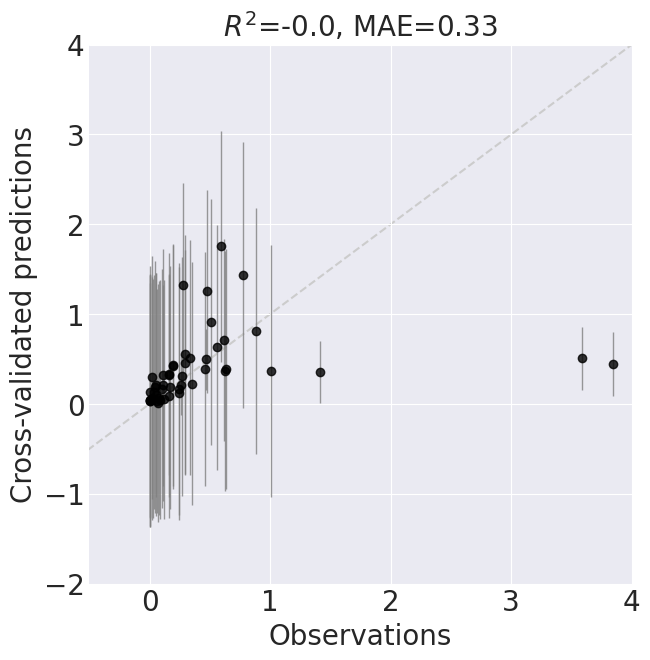

output_dir: ../../results/Hopless_beer_02_19_seed10  Exists? True
file_path: ../../results/Hopless_beer_02_19_seed10/predictions_vs_observations_cv_Linalool.png  Exists? True


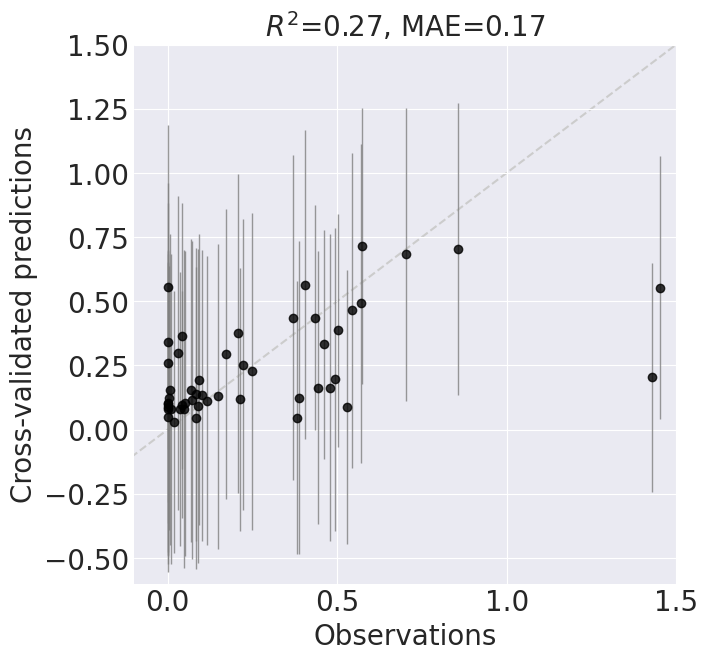

output_dir: ../../results/Hopless_beer_02_19_seed10  Exists? True
file_path: ../../results/Hopless_beer_02_19_seed10/predictions_vs_observations_cv_GERANIOL.png  Exists? True


In [37]:
plot.predictions_vs_observations(art_2, cv=True, error_bars=True,
                                 x_limits=xlim, y_limits=ylim)


In [38]:
display(HTML('Evaluation of learned predictive models:'))
art_2.evaluate_models()

/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in double_scalars
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


MAE  MRAE(%)         StdAE  \
Name                                                               
Neural Regressor             1.032053e-01      inf  1.211963e-01   
Random Forest Regressor      1.400232e-01      inf  2.228248e-01   
Support Vector Regressor     2.077894e-01      inf  5.235662e-01   
Kernel Ridge Regressor       2.433510e-01      inf  4.246391e-01   
K-NN Regressor               2.317348e-01      inf  4.670724e-01   
Gaussian Process Regressor   8.665309e-10      inf  1.738686e-09   
Gradient Boosting Regressor  9.013941e-03      inf  7.949845e-03   
TPOT Regressor               3.815249e-01      inf  5.514368e-01   
Ensemble Model               1.349091e-01      inf  2.464106e-01   

                                      MSE     $R^2$  
Name                                                 
Neural Regressor             2.533990e-02  0.952896  
Random Forest Regressor      6.925738e-02  0.871259  
Support Vector Regressor     3.172980e-01  0.410180  
Kernel Ridge Regressor       2.395381e-01  0.554726  
K-NN Regressor               2.718577e-01  0.494648  
Gaussian Process Regressor   3.773904e-18  1.000000  
Gradient Boosting Regressor  1.444512e-04  0.999731  
TPOT Regressor               4.496439e-01  0.164164  
Ensemble Model               7.891867e-02  0.853299

/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in double_scalars
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


MAE  MRAE(%)     StdAE       MSE     $R^2$
Name                                                                        
Neural Regressor             0.151734      inf  0.200599  0.063263  0.409073
Random Forest Regressor      0.060314      inf  0.077410  0.009630  0.910048
Support Vector Regressor     0.124210      inf  0.186129  0.050072  0.532287
Kernel Ridge Regressor       0.152915      inf  0.184751  0.057516  0.462754
K-NN Regressor               0.165395      inf  0.188411  0.062854  0.412891
Gaussian Process Regressor   0.001103      inf  0.001608  0.000004  0.999964
Gradient Boosting Regressor  0.008058      inf  0.005221  0.000092  0.999139
TPOT Regressor               0.108467      inf  0.133958  0.029710  0.722485
Ensemble Model               0.085585      inf  0.112432  0.019966  0.813504

### Optimize for **Pale Ale** beer.

In [41]:
art_2.target_values = target_dict['pale ale']
art_2.result_suffix = '_PA_C2'

Starting parallel tempering using 2 chains…
Done with parallel tempering in 270.66 s
Choosing recommendations (19,800 candidates)…


/code/notebooks/paper/../../art/core/recommender.py:56: RuntimeWarning: divide by zero encountered in double_scalars
  (np.abs(candidate[dimension] - point[dimension]) / np.abs(point[dimension]))


Done choosing recommendations in 0.01 s


R-linalool synthase, chloroplastic  Geraniol synthase, chloroplastic  \
0                         4206.063206                       8198.456129   
1                         3205.488070                       6055.062061   
2                         1629.162484                       6478.582171   
3                         2137.447259                       6683.545065   
4                         2372.499399                       4768.311495   
5                         3141.758799                       8145.615765   
6                         3431.717728                       7898.189712   
7                         2727.237766                       6848.258216   
8                         4773.465324                       7465.154135   
9                         4426.879915                       7948.824651   

   Farnesyl pyrophosphate synthase  Hydroxymethylglutaryl-CoA synthase  \
0                      8718.808868                        14087.139548   
1                     19491.287813                        13467.391613   
2                     21268.922632                         6226.598771   
3                     22711.774412                         8684.894435   
4                     22148.988312                        11061.648629   
5                     17338.221005                         7091.533584   
6                      5864.990371                        10748.800647   
7                      3940.104059                        10996.502881   
8                     17044.529626                        16843.925527   
9                     26321.000344                        13059.036272   

   Linalool  GERANIOL  
0  0.207205  0.313809  
1  0.206027  0.319928  
2  0.200547  0.317673  
3  0.204863  0.321998  
4  0.200749  0.305681  
5  0.206642  0.301407  
6  0.218374  0.313678  
7  0.218302  0.315040  
8  0.213488  0.303052  
9  0.215838  0.322450

Sampling: [y]


Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 1.43 s


/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

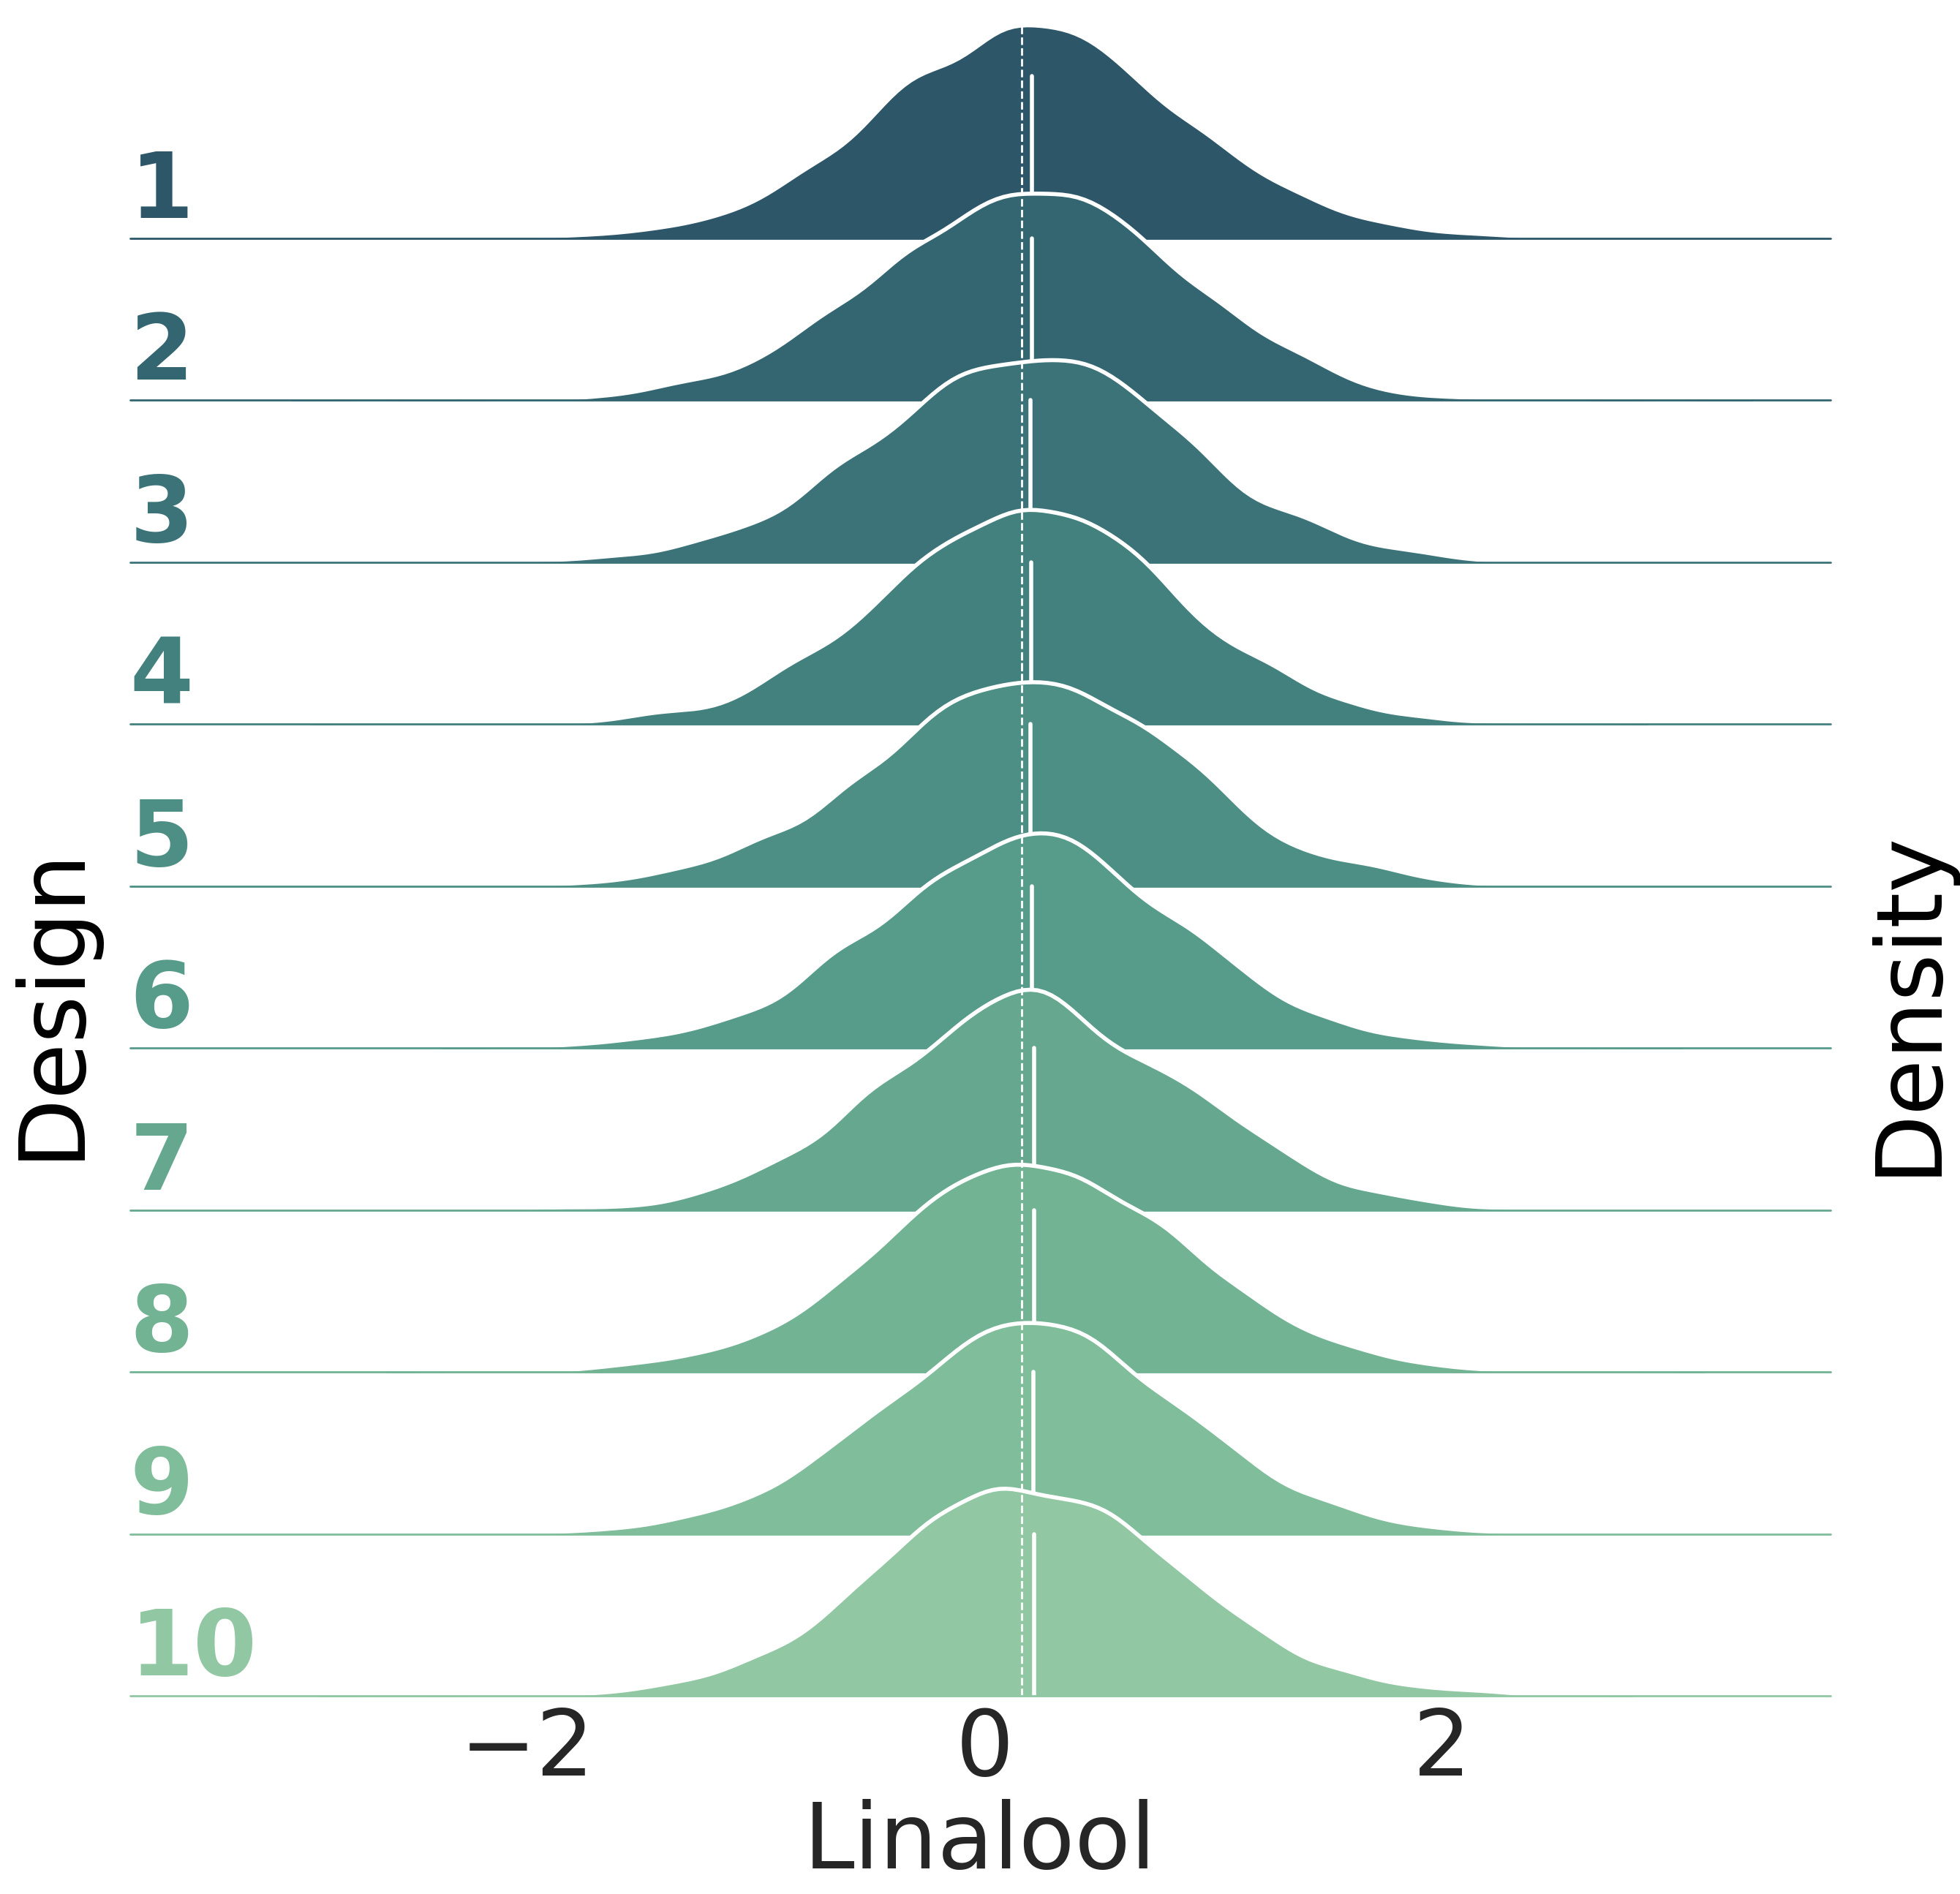

/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

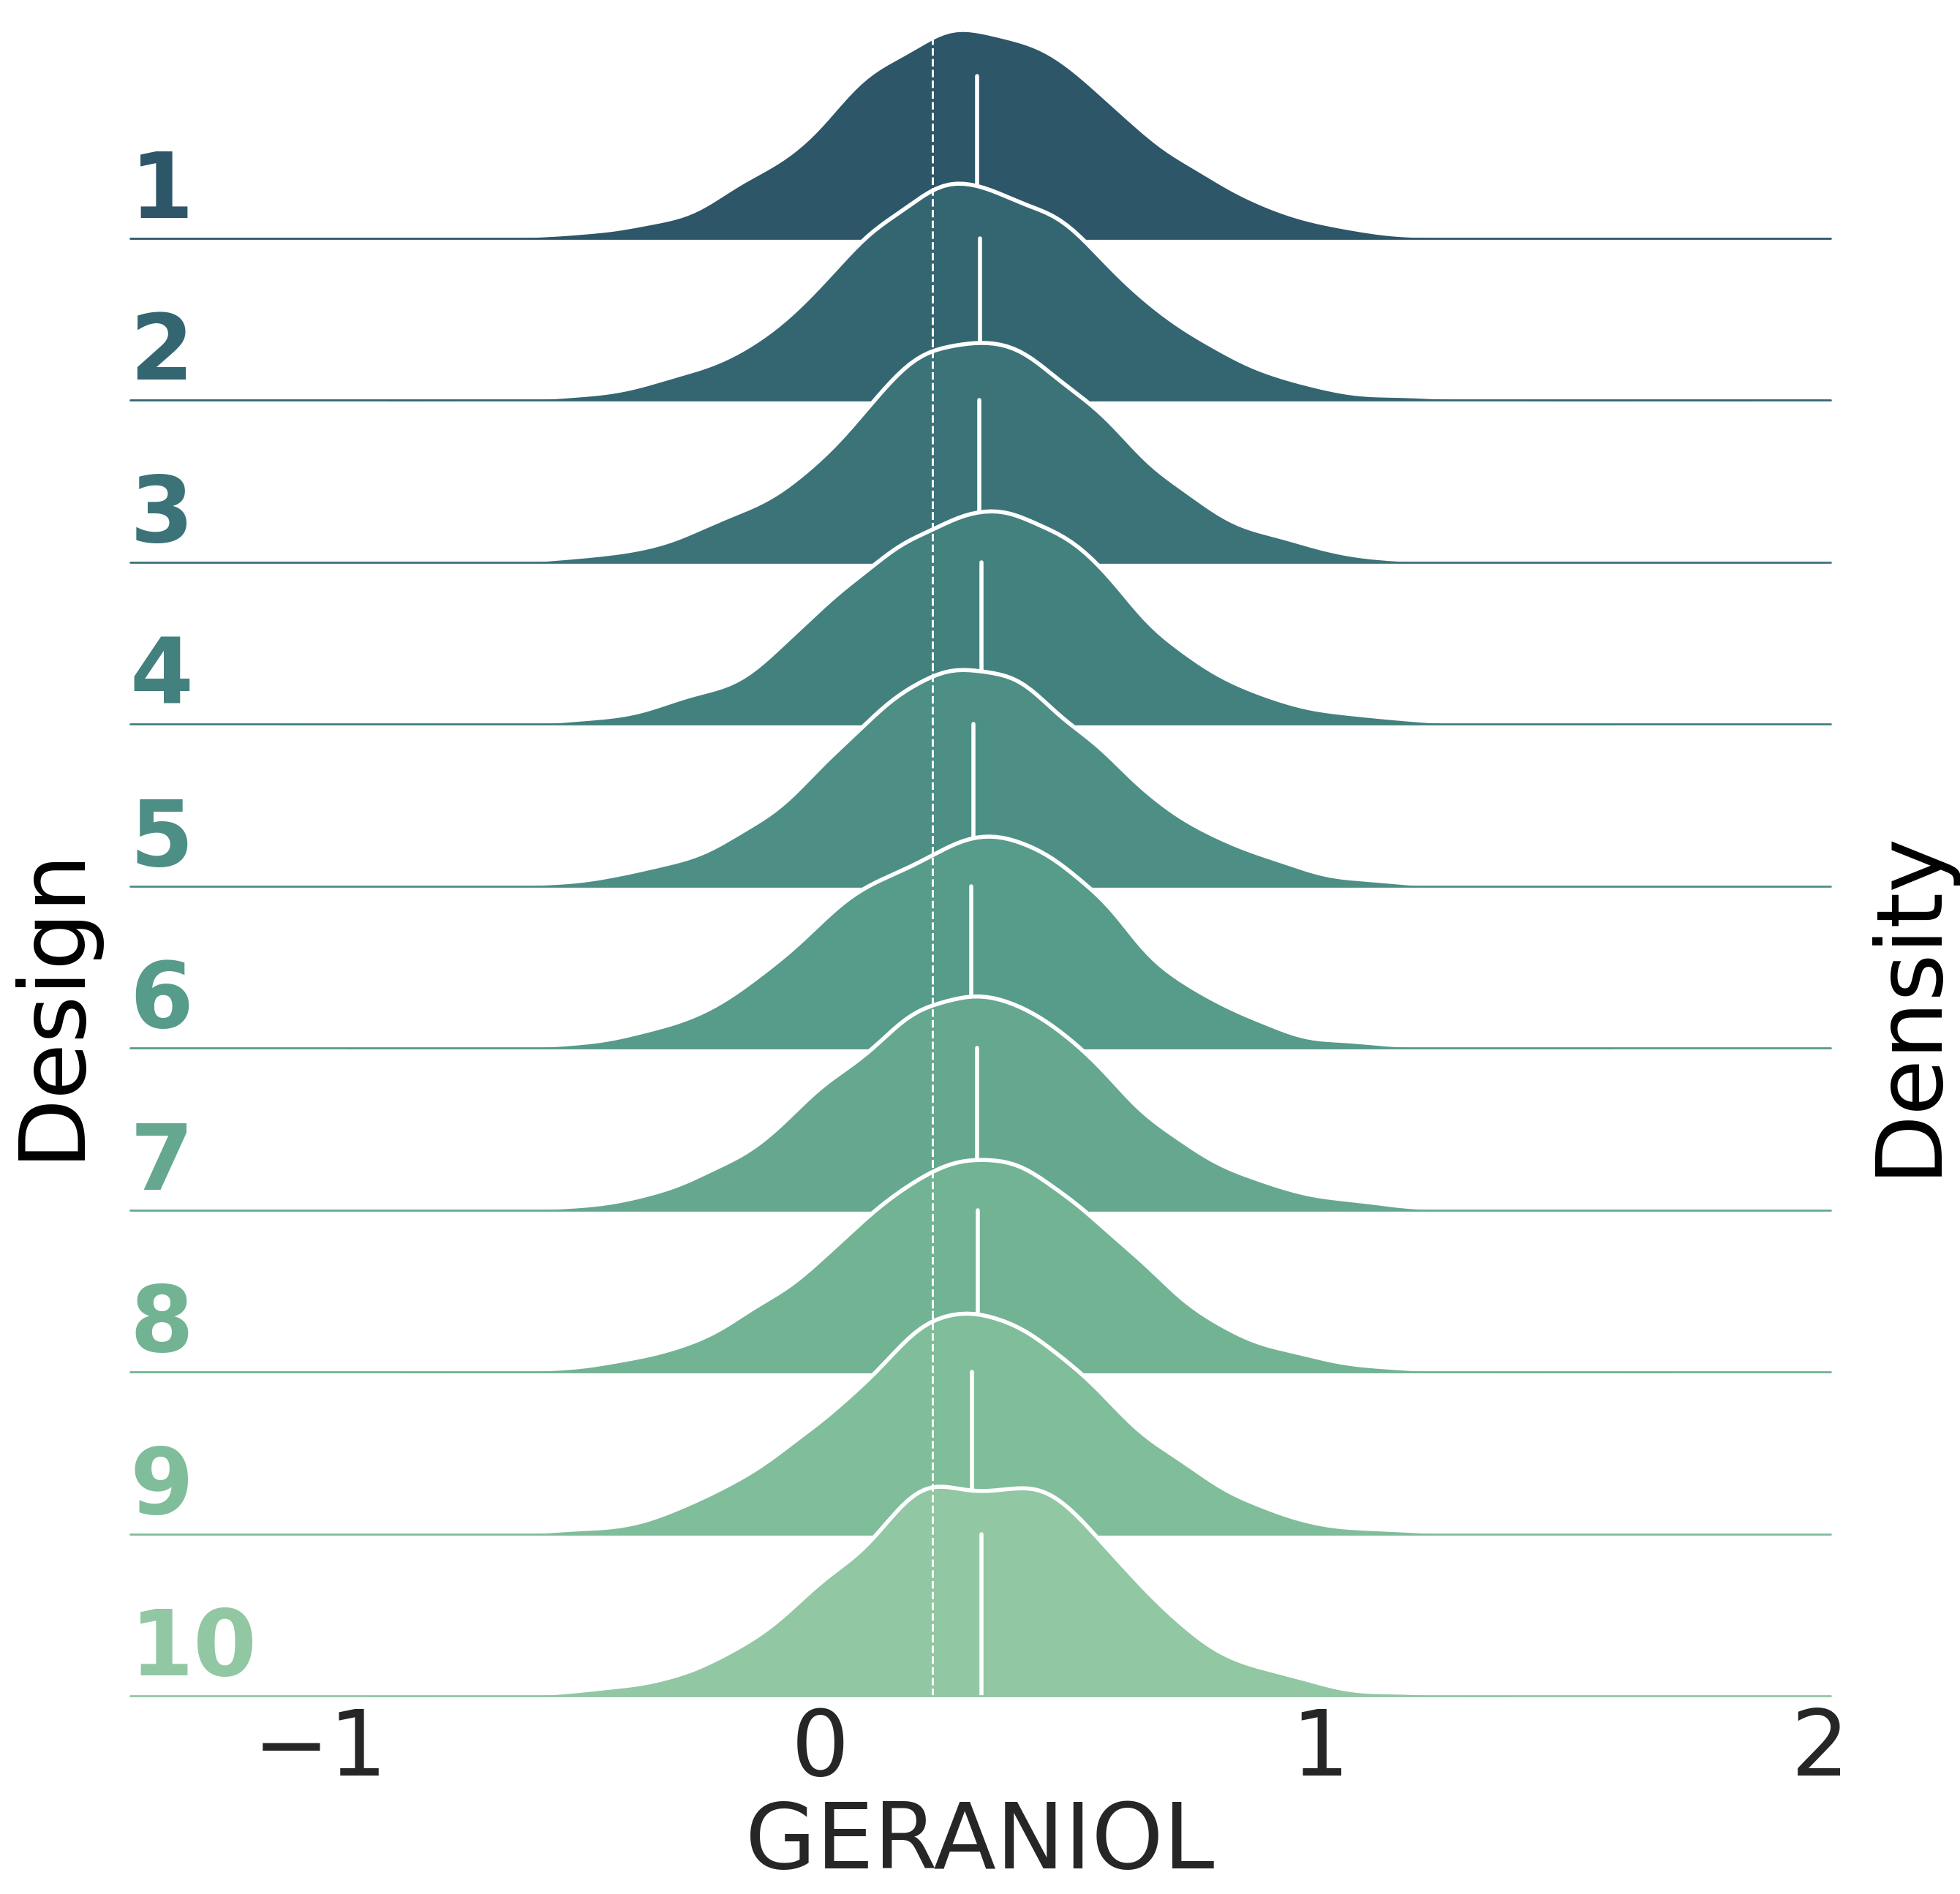

Computing success probabilities…
Sampling posterior predictive distributions…


Sampling: [y]
Sampling: [y]


Done sampling in 1.61 s
Done calculating success probabilities in 1.62 s


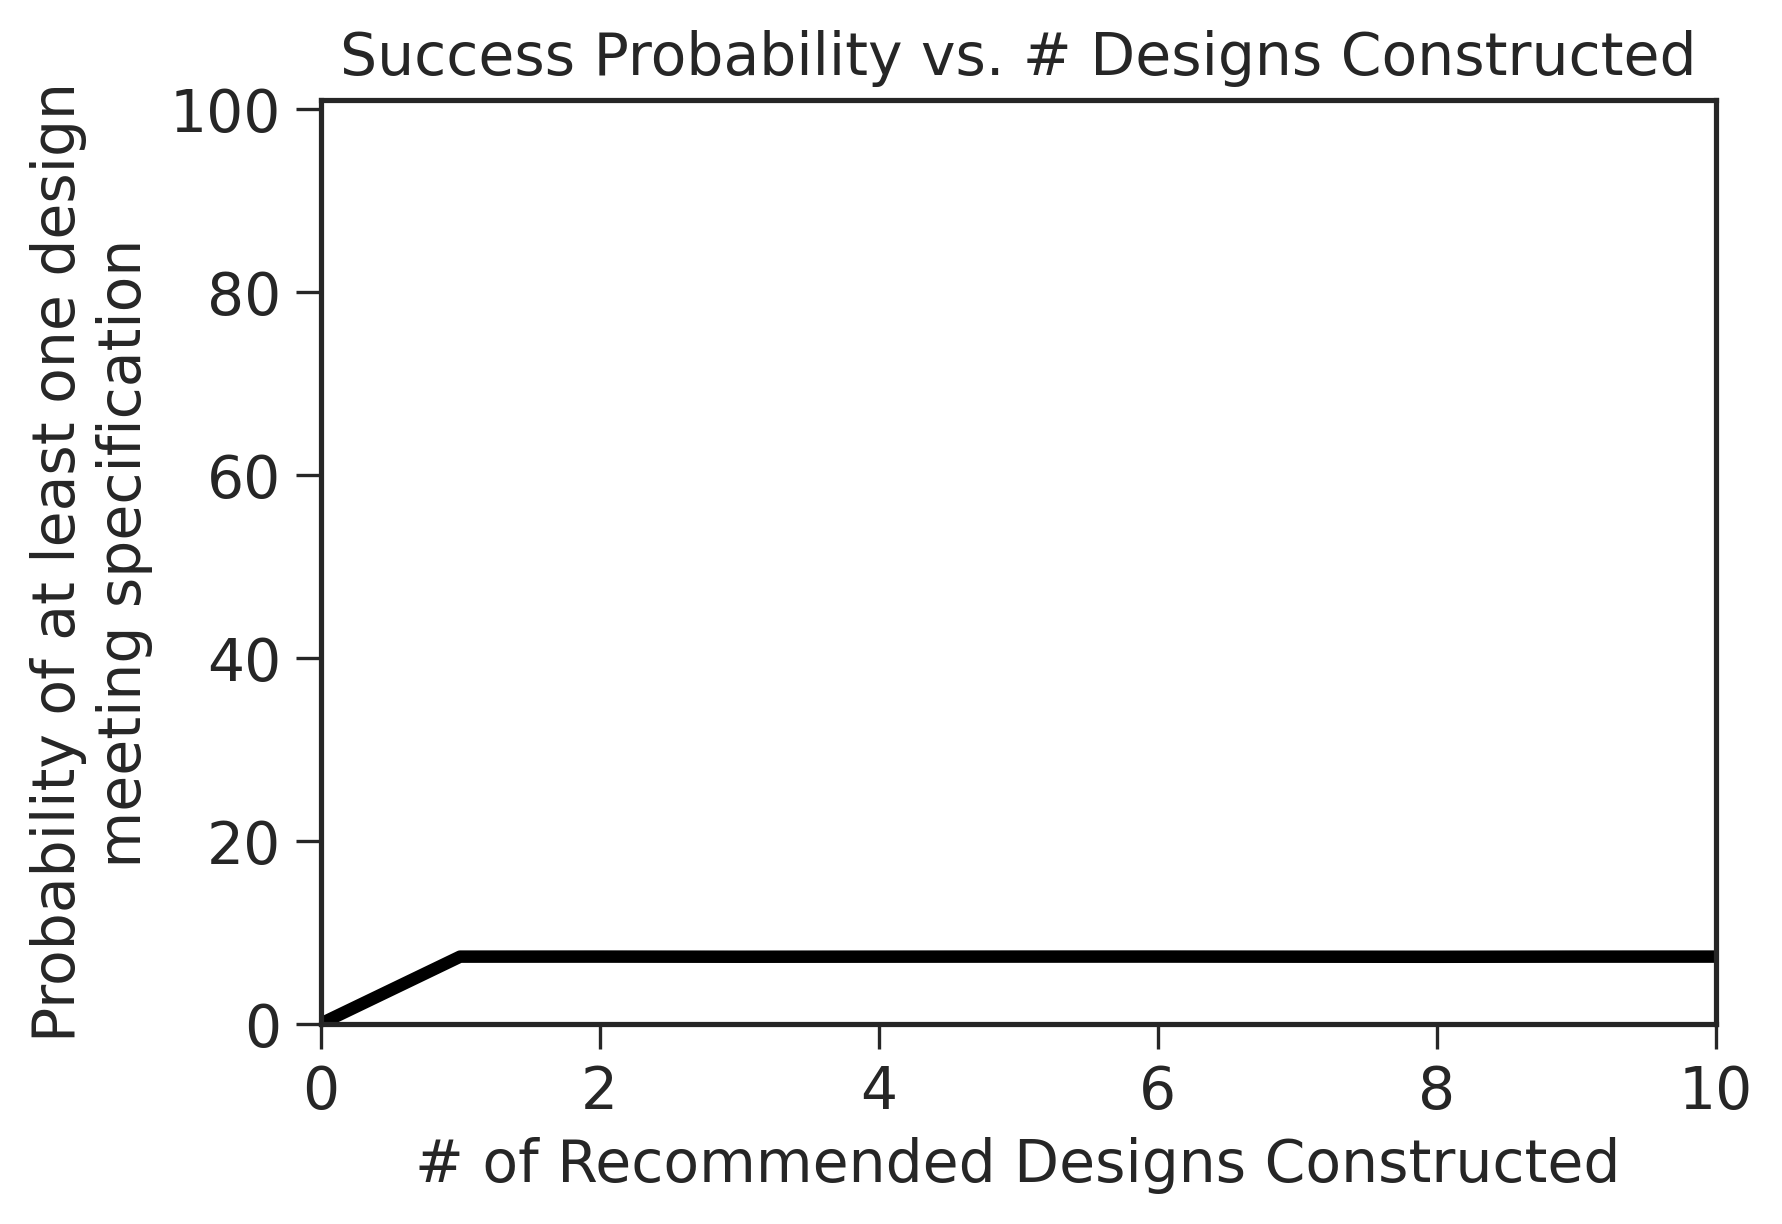

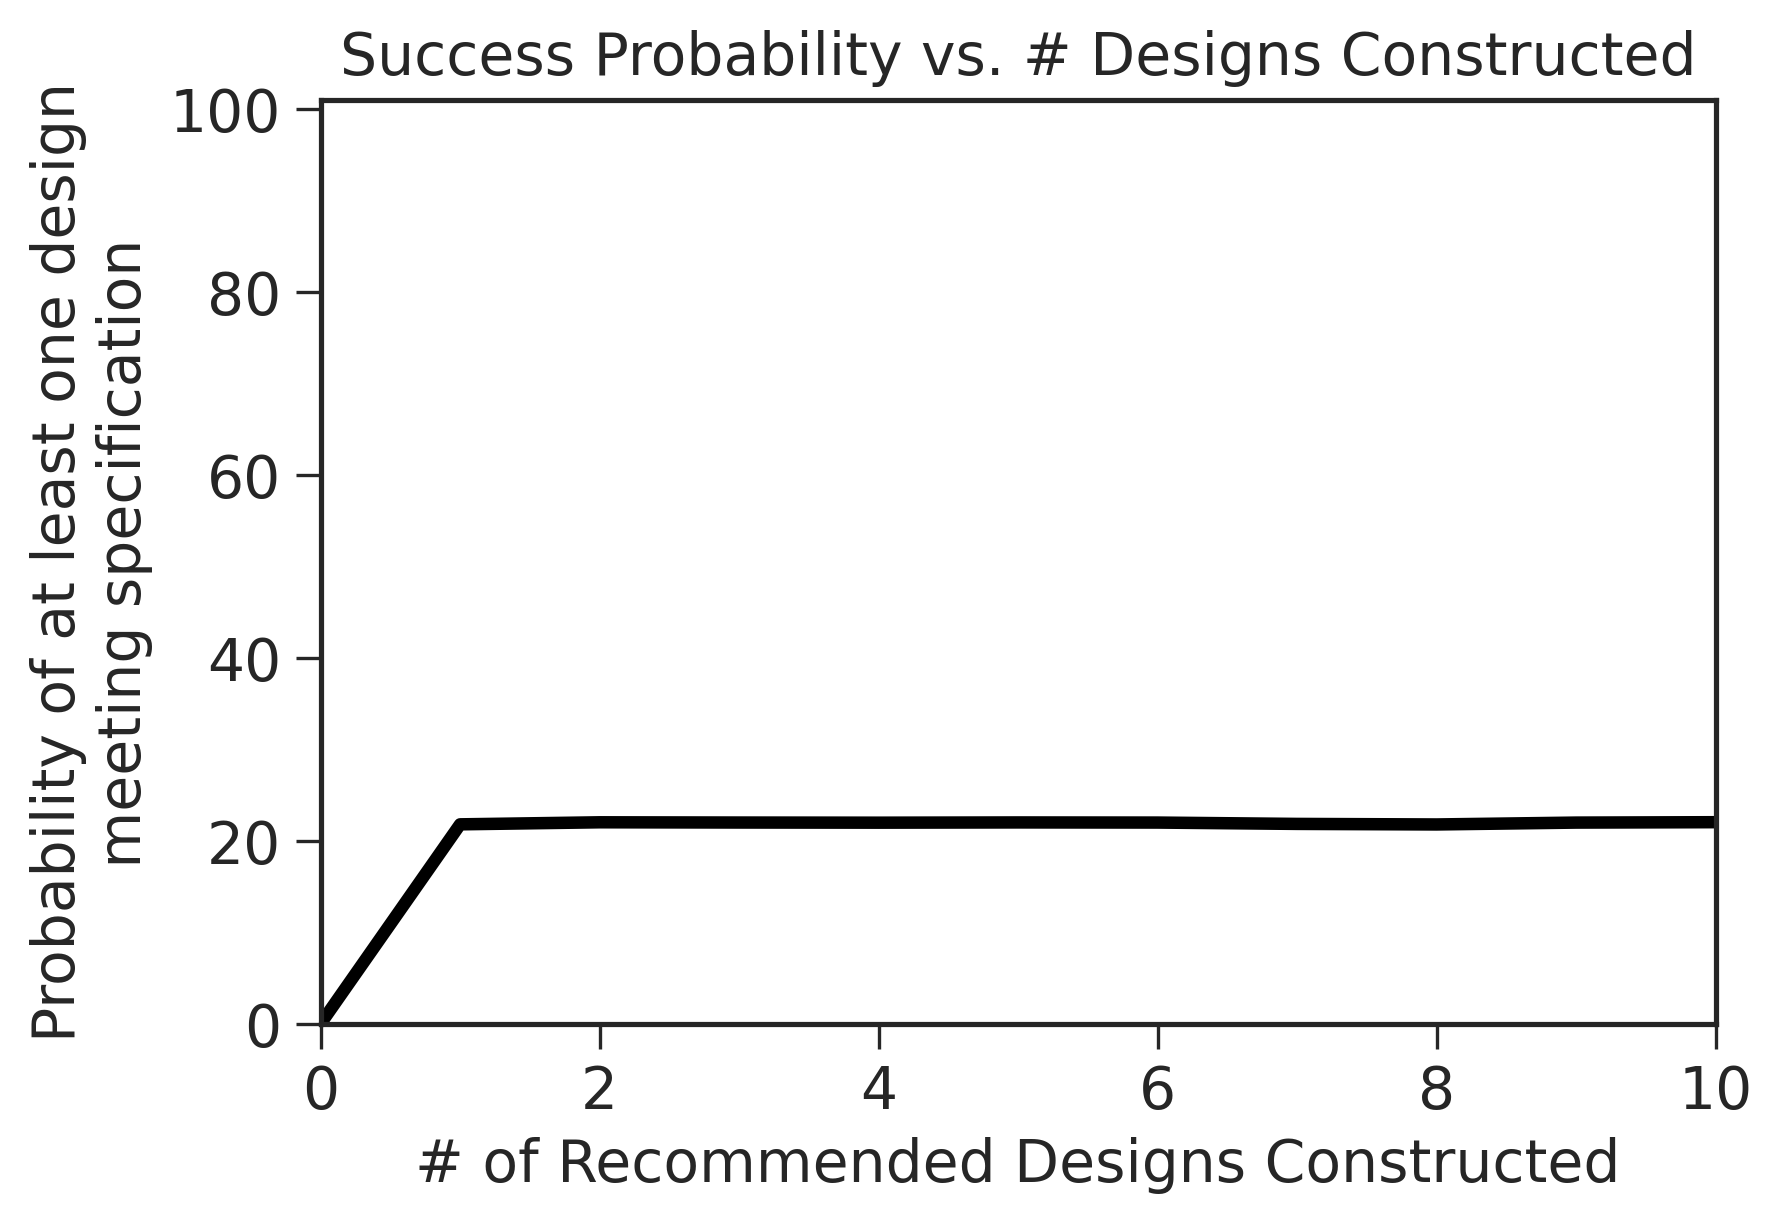

[0.205484162, 0.313515363]

In [42]:
draws = art_2.generate_recommendation_candidates()
art_2.select_recommendations(draws)
art_2.target_values


In [44]:
rec_pale_ale_C2 = art_2.recommendations[['Linalool','GERANIOL']].values

### Optimize for **Hop Hunter** beer.

In [45]:
art_2.target_values = target_dict['hop hunter']
art_2.result_suffix = '_HH_C2'

Starting parallel tempering using 2 chains…
Done with parallel tempering in 267.58 s
Choosing recommendations (19,800 candidates)…


/code/notebooks/paper/../../art/core/recommender.py:56: RuntimeWarning: divide by zero encountered in double_scalars
  (np.abs(candidate[dimension] - point[dimension]) / np.abs(point[dimension]))


Done choosing recommendations in 0.01 s


R-linalool synthase, chloroplastic  Geraniol synthase, chloroplastic  \
0                         2558.520745                       3466.720963   
1                         2795.105309                       3382.891974   
2                         5618.554768                       1858.554200   
3                         3212.119564                       3450.630524   
4                         2569.611016                       4416.832137   
5                         5831.464704                       1311.406353   
6                         1864.144655                       3295.402405   
7                         5273.750942                       1535.661452   
8                         2691.862754                       3463.852638   
9                         3937.876316                       3267.581753   

   Farnesyl pyrophosphate synthase  Hydroxymethylglutaryl-CoA synthase  \
0                     63977.502203                        14695.936870   
1                     64545.598470                        11599.323071   
2                     45814.397734                        14471.859174   
3                     63681.800765                        14474.677873   
4                     61838.405662                        16424.615009   
5                     48491.799771                        14980.559294   
6                     63159.959666                        12526.239155   
7                     49315.588597                        10594.322858   
8                     62342.175118                         8302.488119   
9                     64296.041956                        14803.105795   

   Linalool  GERANIOL  
0  1.140629  0.808161  
1  1.136975  0.799931  
2  1.194129  0.785942  
3  1.163463  0.790563  
4  1.096311  0.801062  
5  1.180340  0.769066  
6  1.094364  0.789854  
7  1.091399  0.787490  
8  1.114058  0.776530  
9  1.176110  0.760160

Sampling: [y]


Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 1.39 s


/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

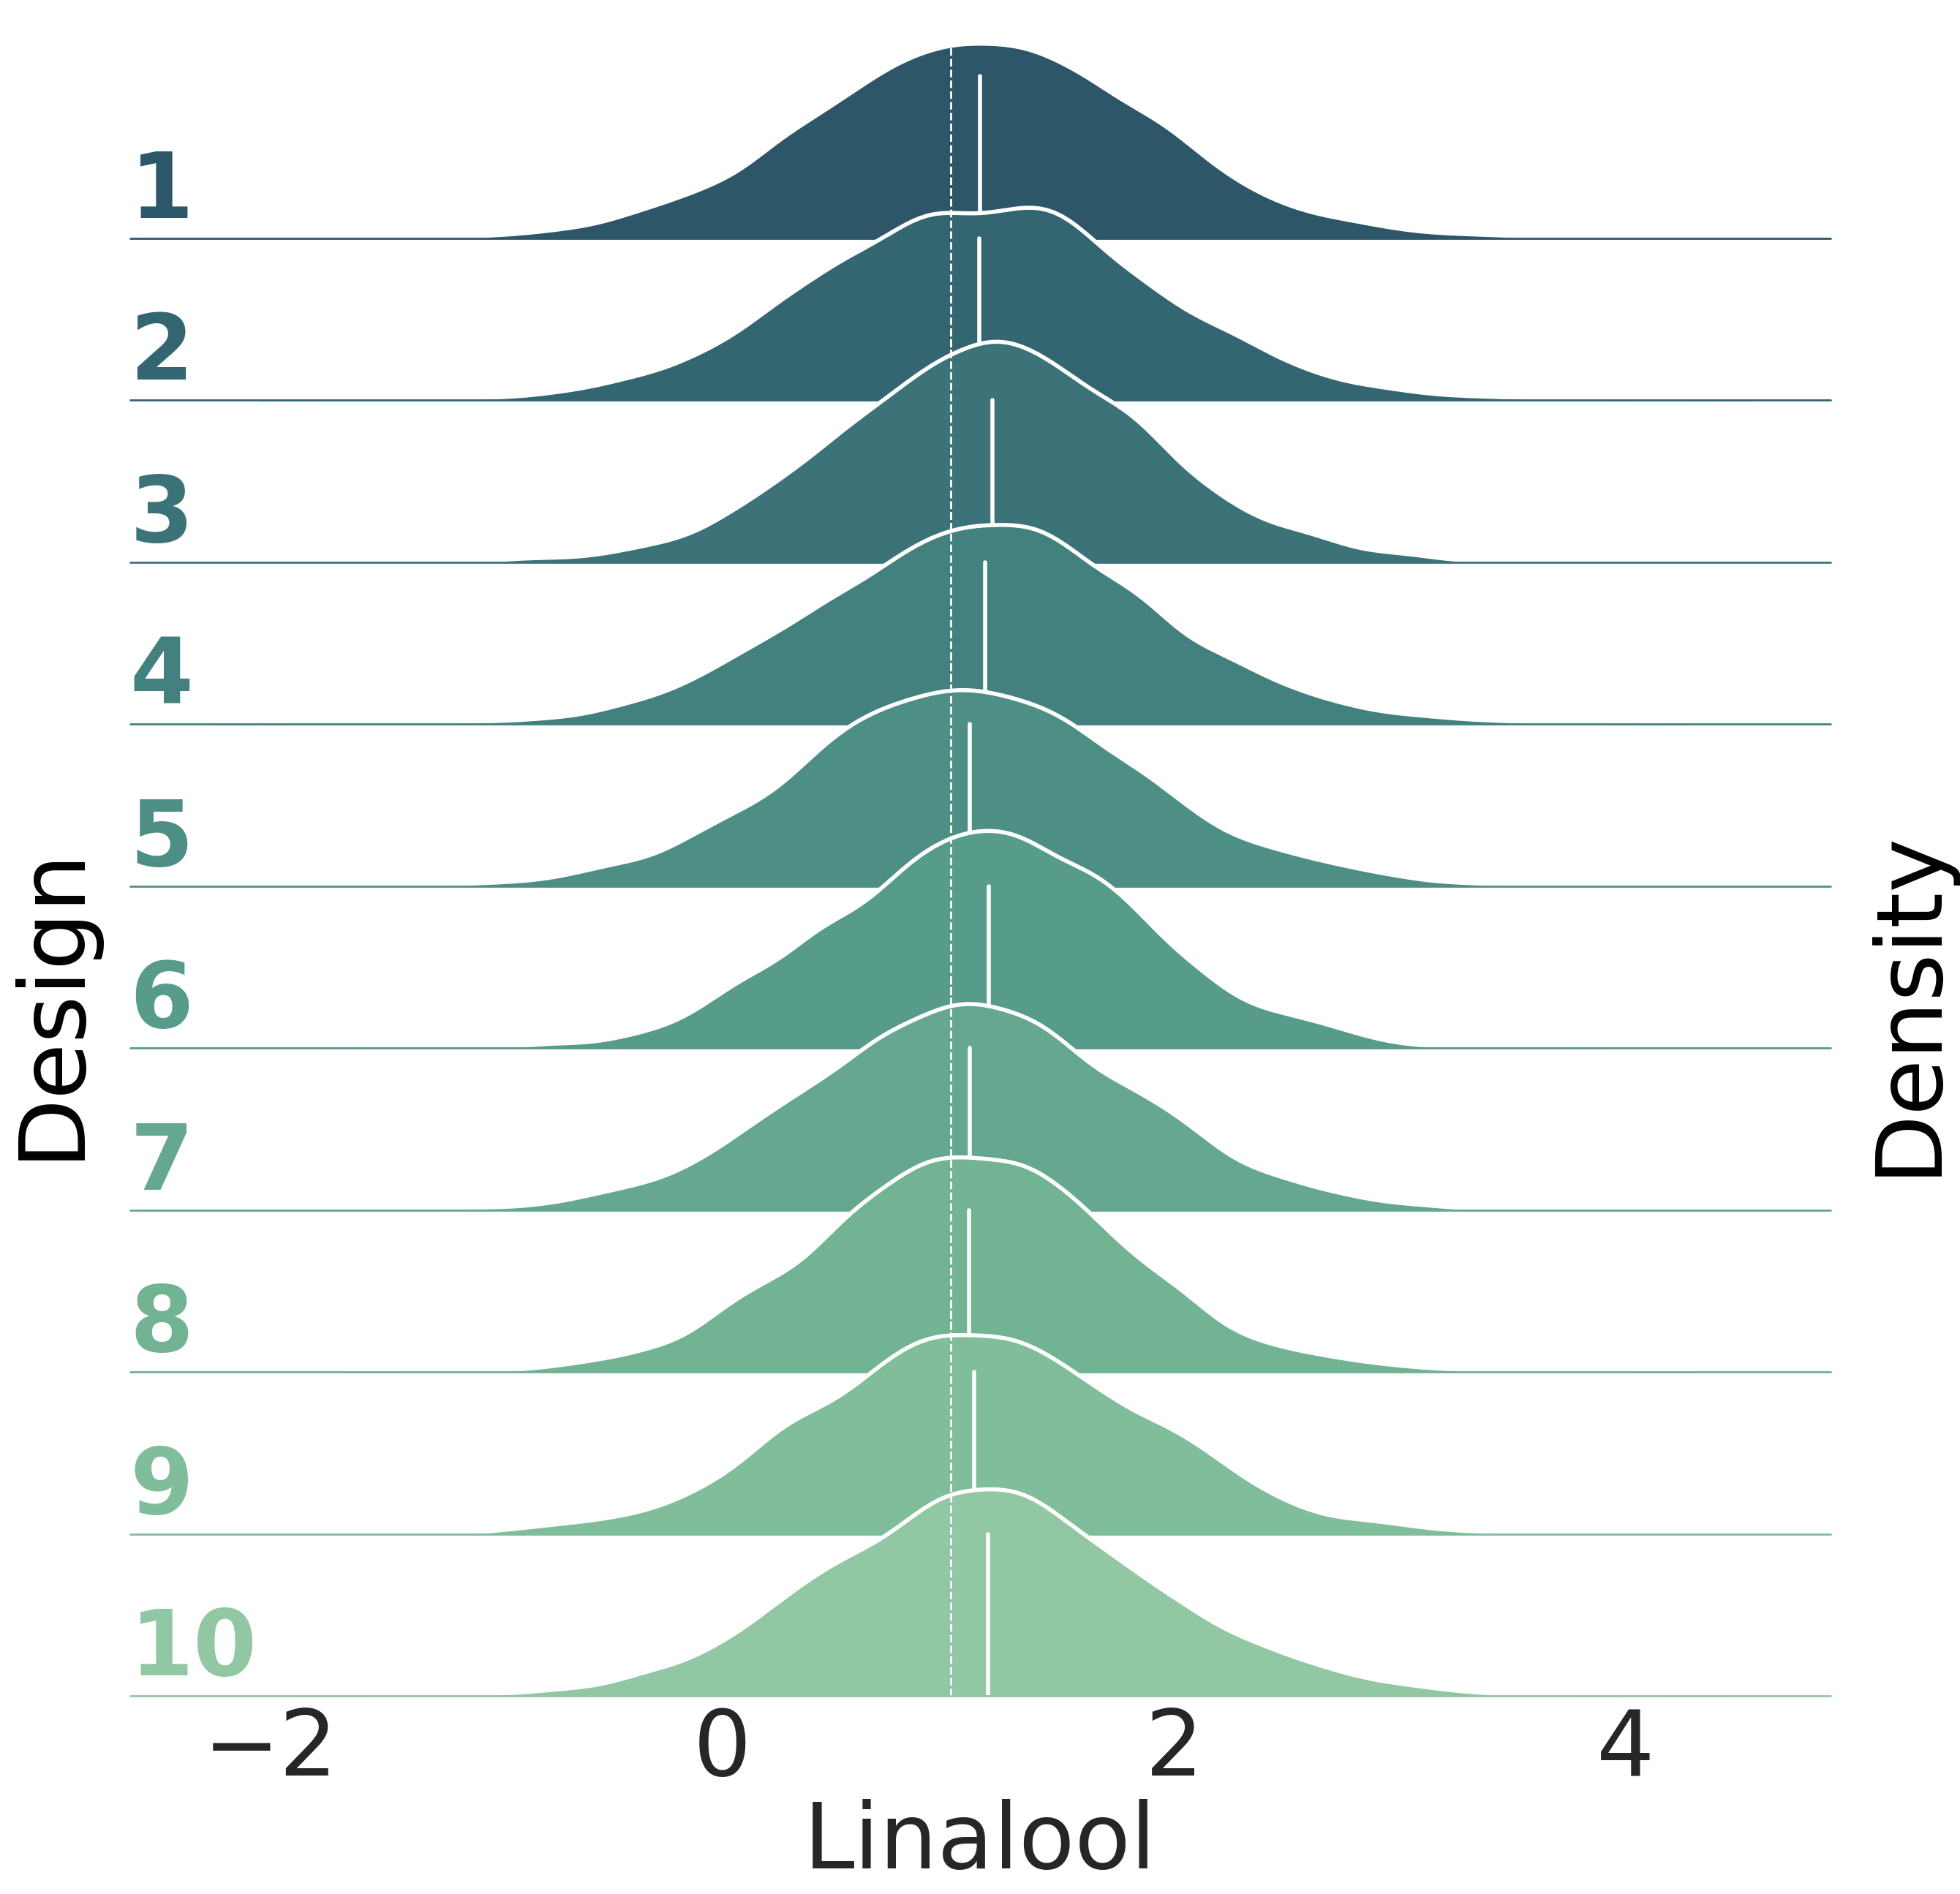

/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

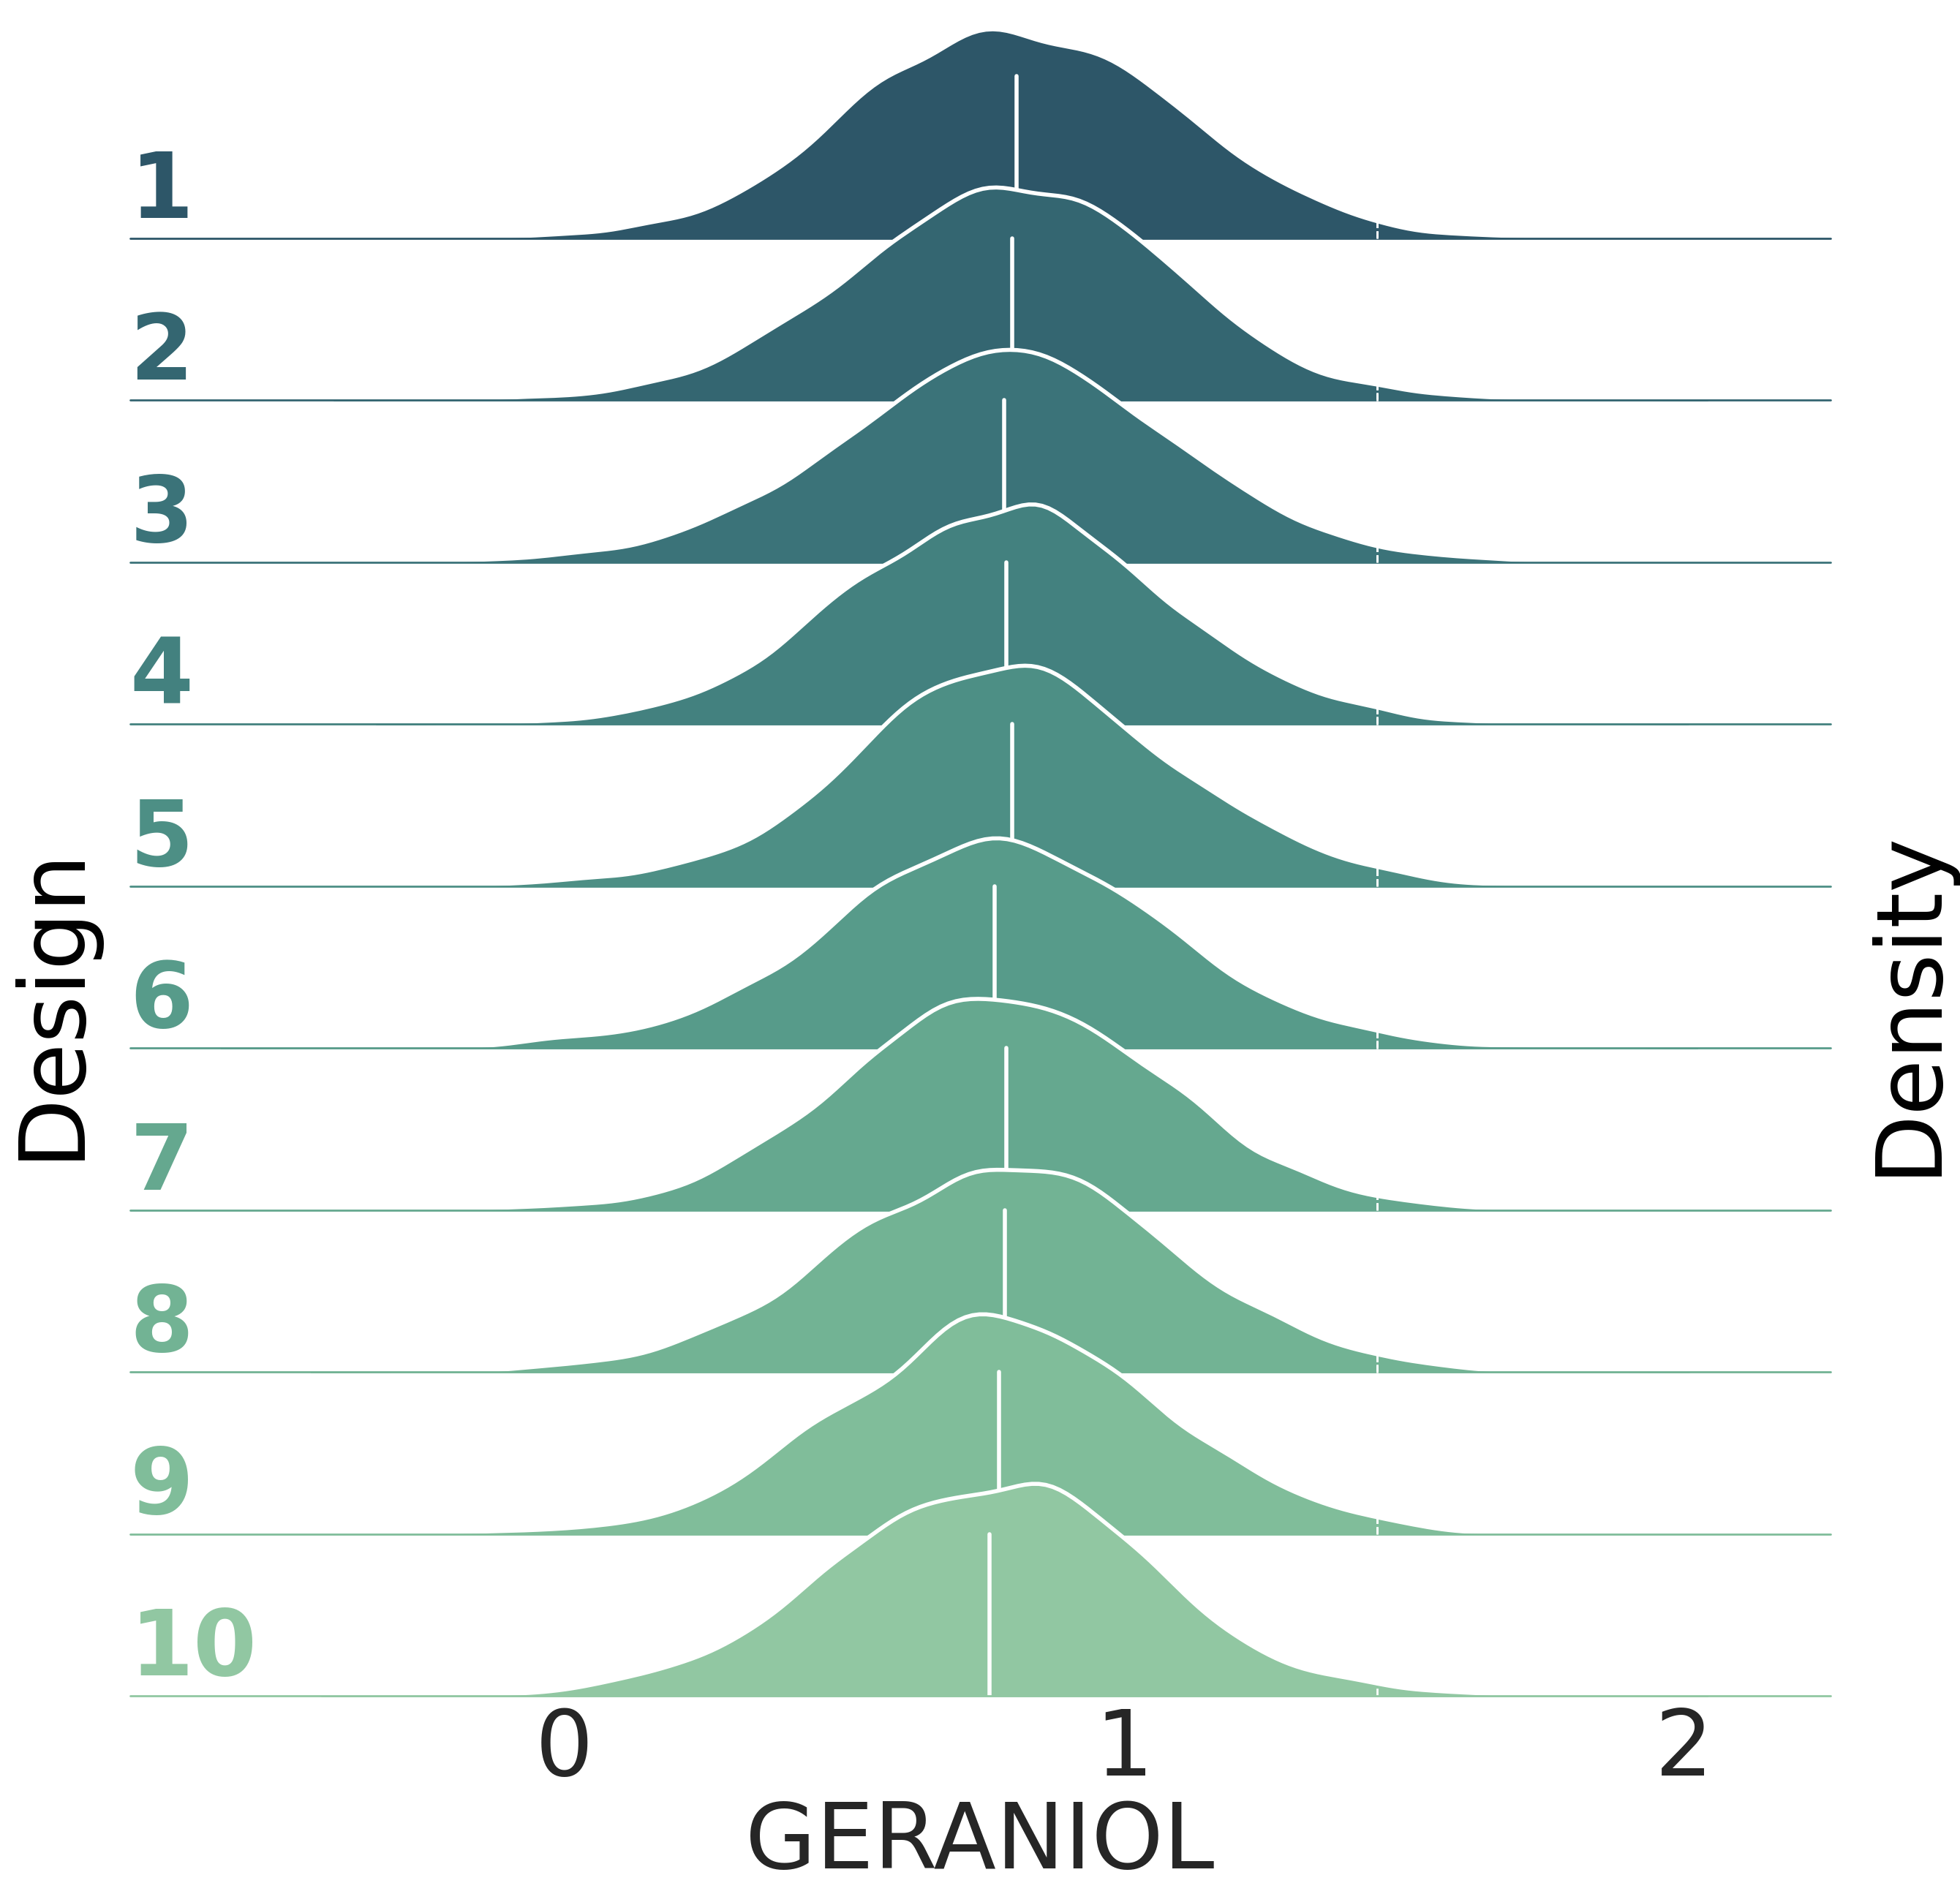

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 1.87 s
Done calculating success probabilities in 1.89 s


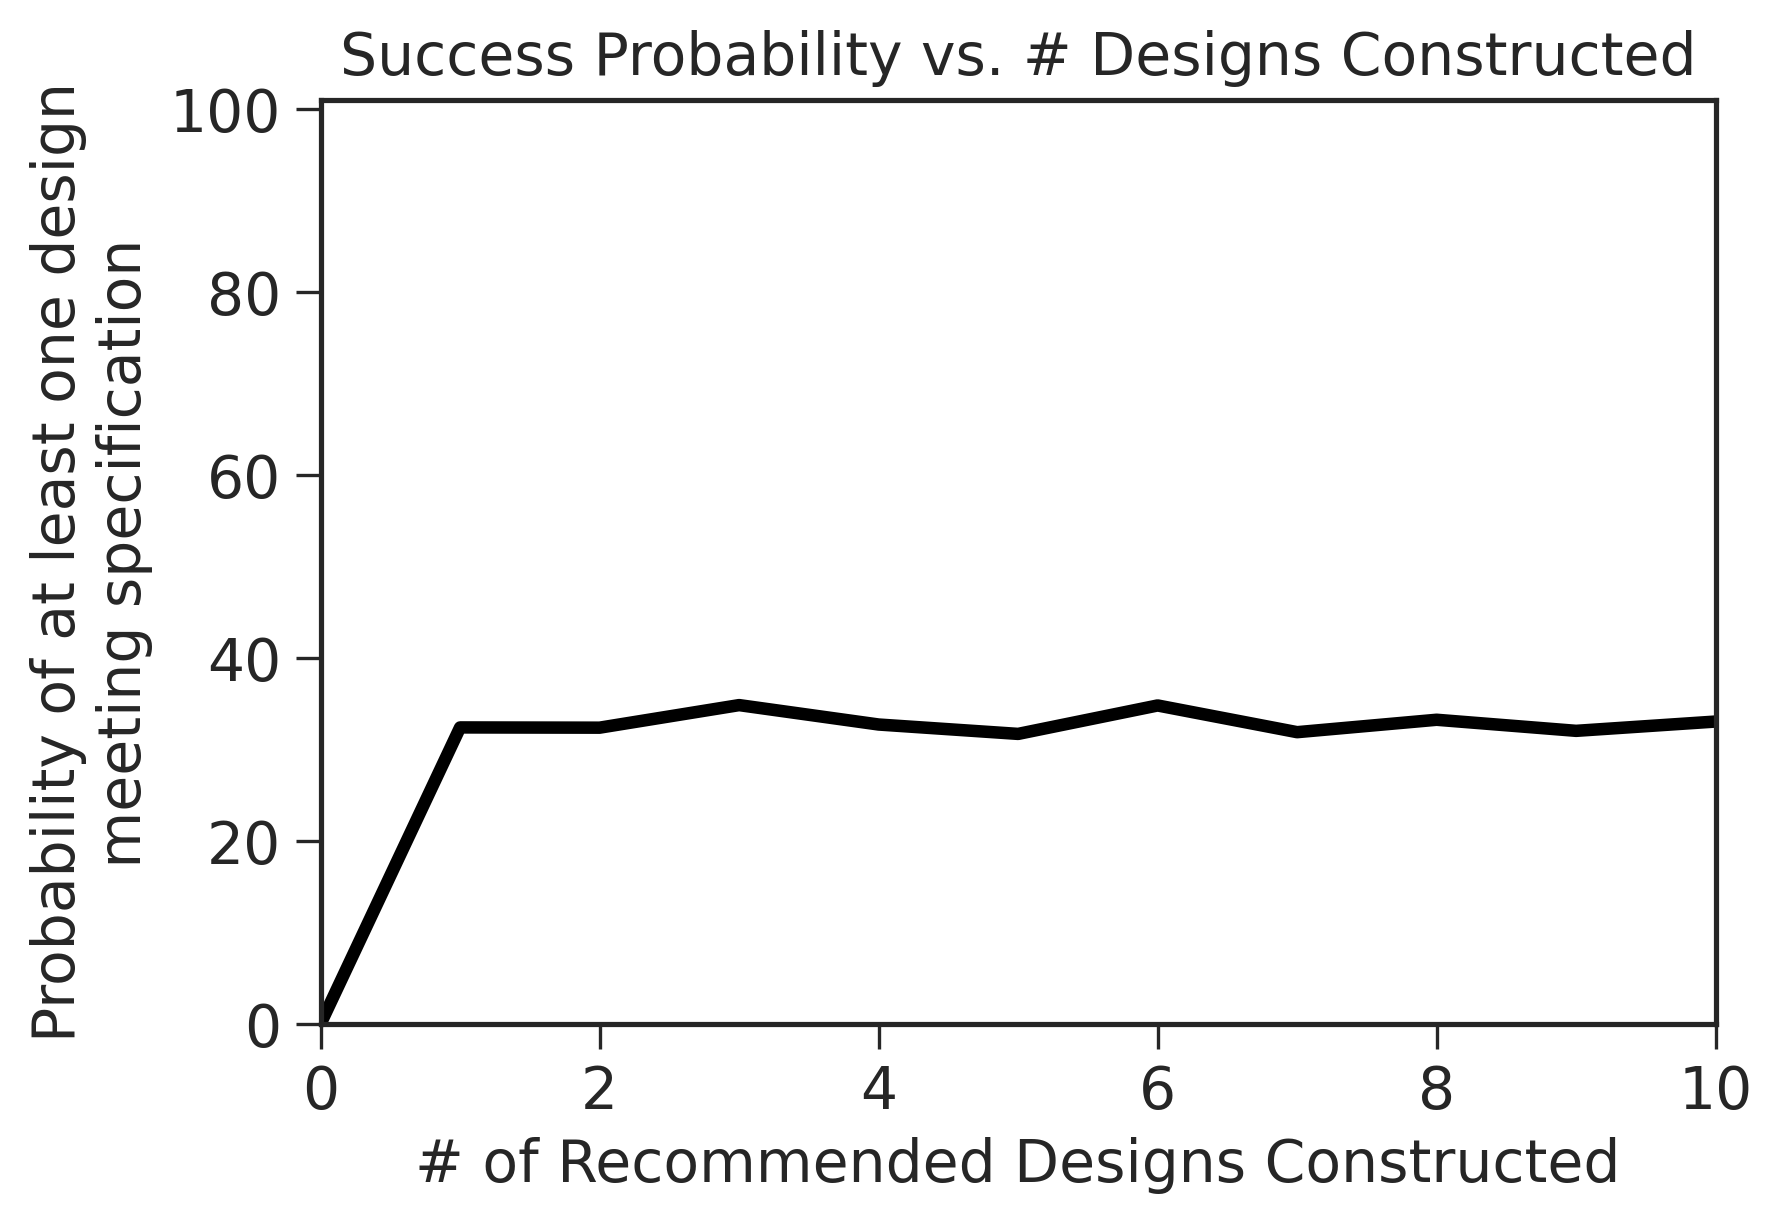

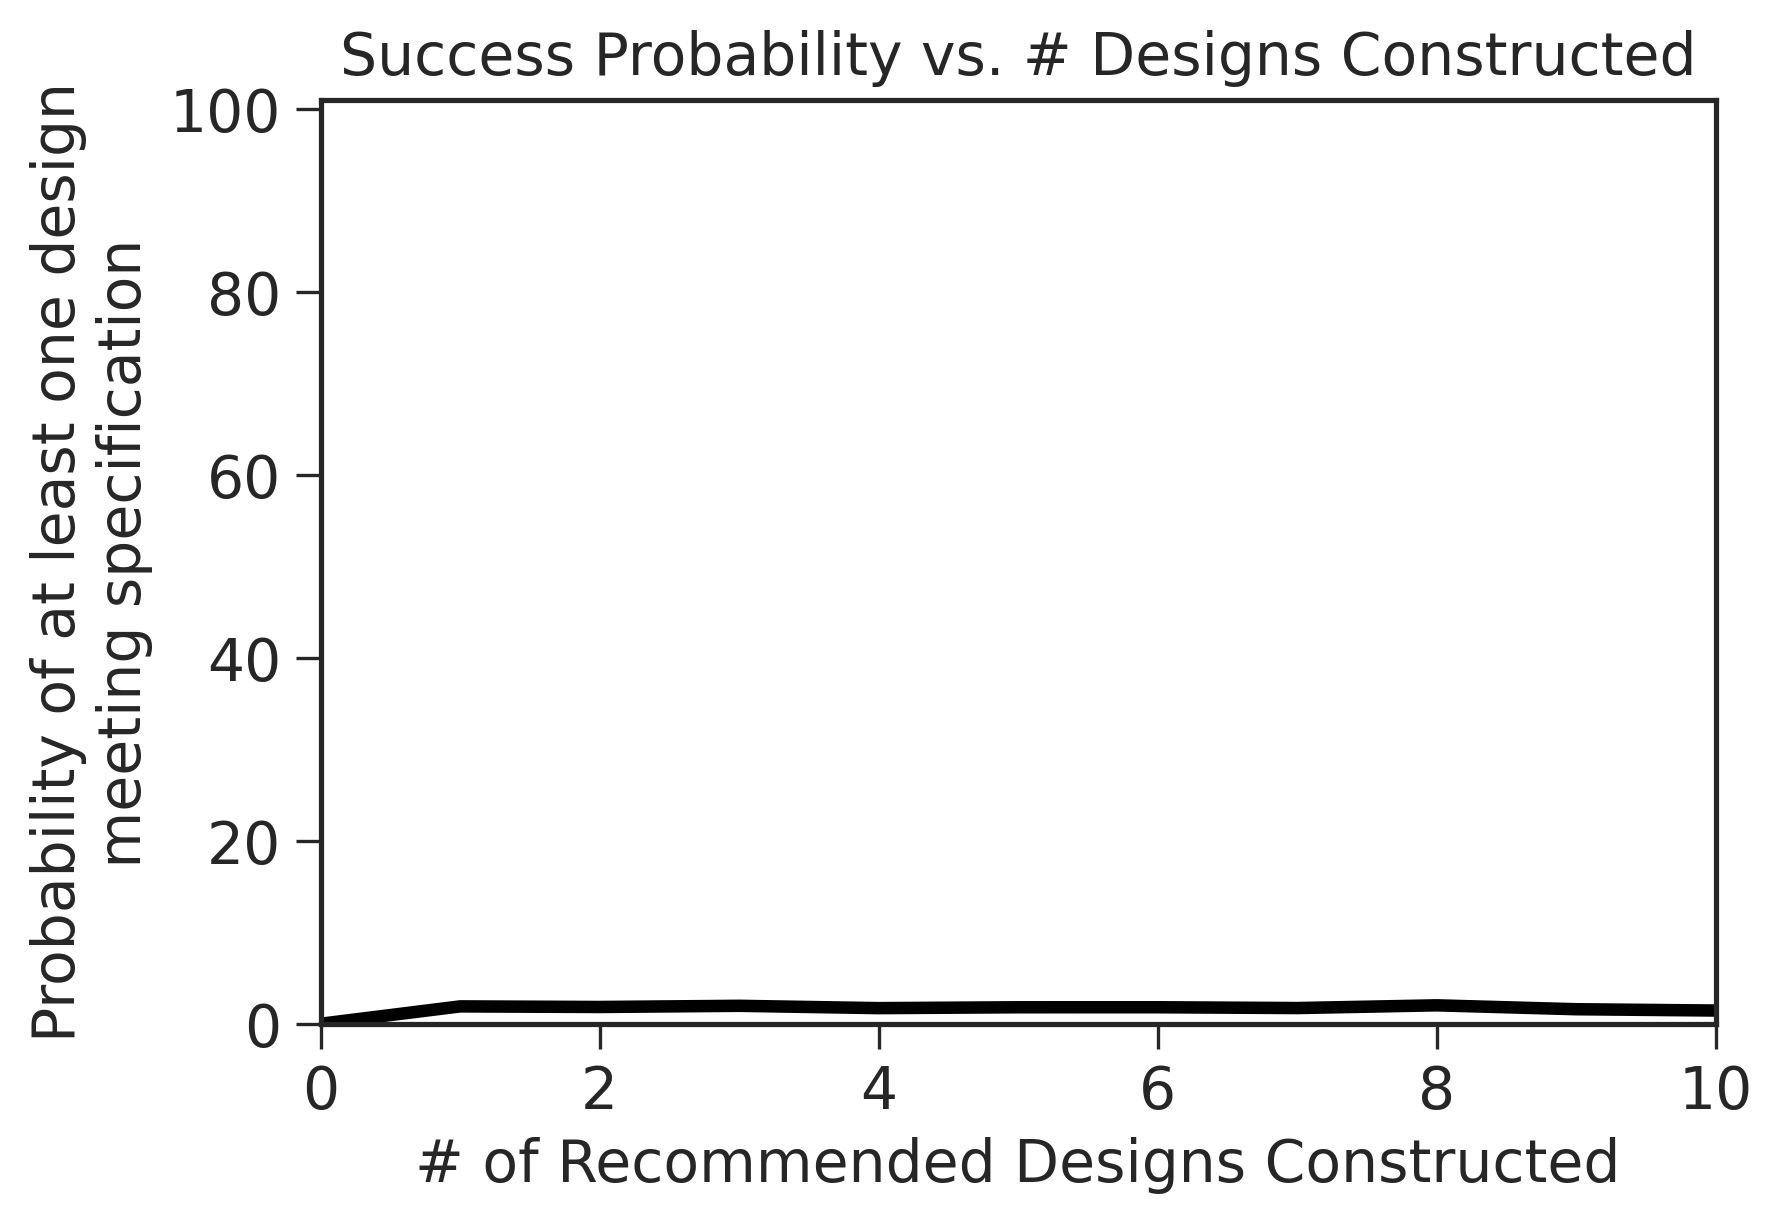

[1.425741149, 1.917484004]

In [46]:
draws = art_2.generate_recommendation_candidates()
art_2.select_recommendations(draws)
art_2.target_values


In [48]:
rec_hop_hunter_C2 = art_2.recommendations[['Linalool','GERANIOL']].values

### Optimize for **Torpedo** beer.

In [49]:
art_2.target_values = target_dict['torpedo']
art_2.result_suffix = '_T_C2'

Starting parallel tempering using 2 chains…
Done with parallel tempering in 266.86 s
Choosing recommendations (19,800 candidates)…


/code/notebooks/paper/../../art/core/recommender.py:56: RuntimeWarning: divide by zero encountered in double_scalars
  (np.abs(candidate[dimension] - point[dimension]) / np.abs(point[dimension]))


Done choosing recommendations in 0.01 s


R-linalool synthase, chloroplastic  Geraniol synthase, chloroplastic  \
0                         3130.087547                       2513.032281   
1                         4958.061000                       5369.169607   
2                         5451.327862                      10374.900617   
3                         5083.946031                       8013.378029   
4                         7031.283942                      10271.102732   
5                         5163.175213                       9247.270554   
6                         5671.486843                       5046.201003   
7                         7305.615011                      11449.457387   
8                         5379.343961                      10258.109146   
9                         6341.928890                       7514.189012   

   Farnesyl pyrophosphate synthase  Hydroxymethylglutaryl-CoA synthase  \
0                     31056.190619                         9699.120527   
1                     45337.260394                        24953.329126   
2                     55934.971546                        33946.678847   
3                     31077.188381                        10885.644480   
4                     60244.530424                         7584.825057   
5                     61262.662942                        23915.684878   
6                     34256.008846                        15616.399219   
7                     49370.605092                        19011.541066   
8                     31009.093640                        10887.840654   
9                     38374.542138                         7506.306109   

   Linalool  GERANIOL  
0  0.534305  0.570126  
1  0.529806  0.573039  
2  0.530435  0.566225  
3  0.528430  0.573170  
4  0.532267  0.565202  
5  0.535198  0.565613  
6  0.527515  0.576176  
7  0.536153  0.577754  
8  0.537279  0.577686  
9  0.522705  0.563775

Sampling: [y]


Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 1.37 s


/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

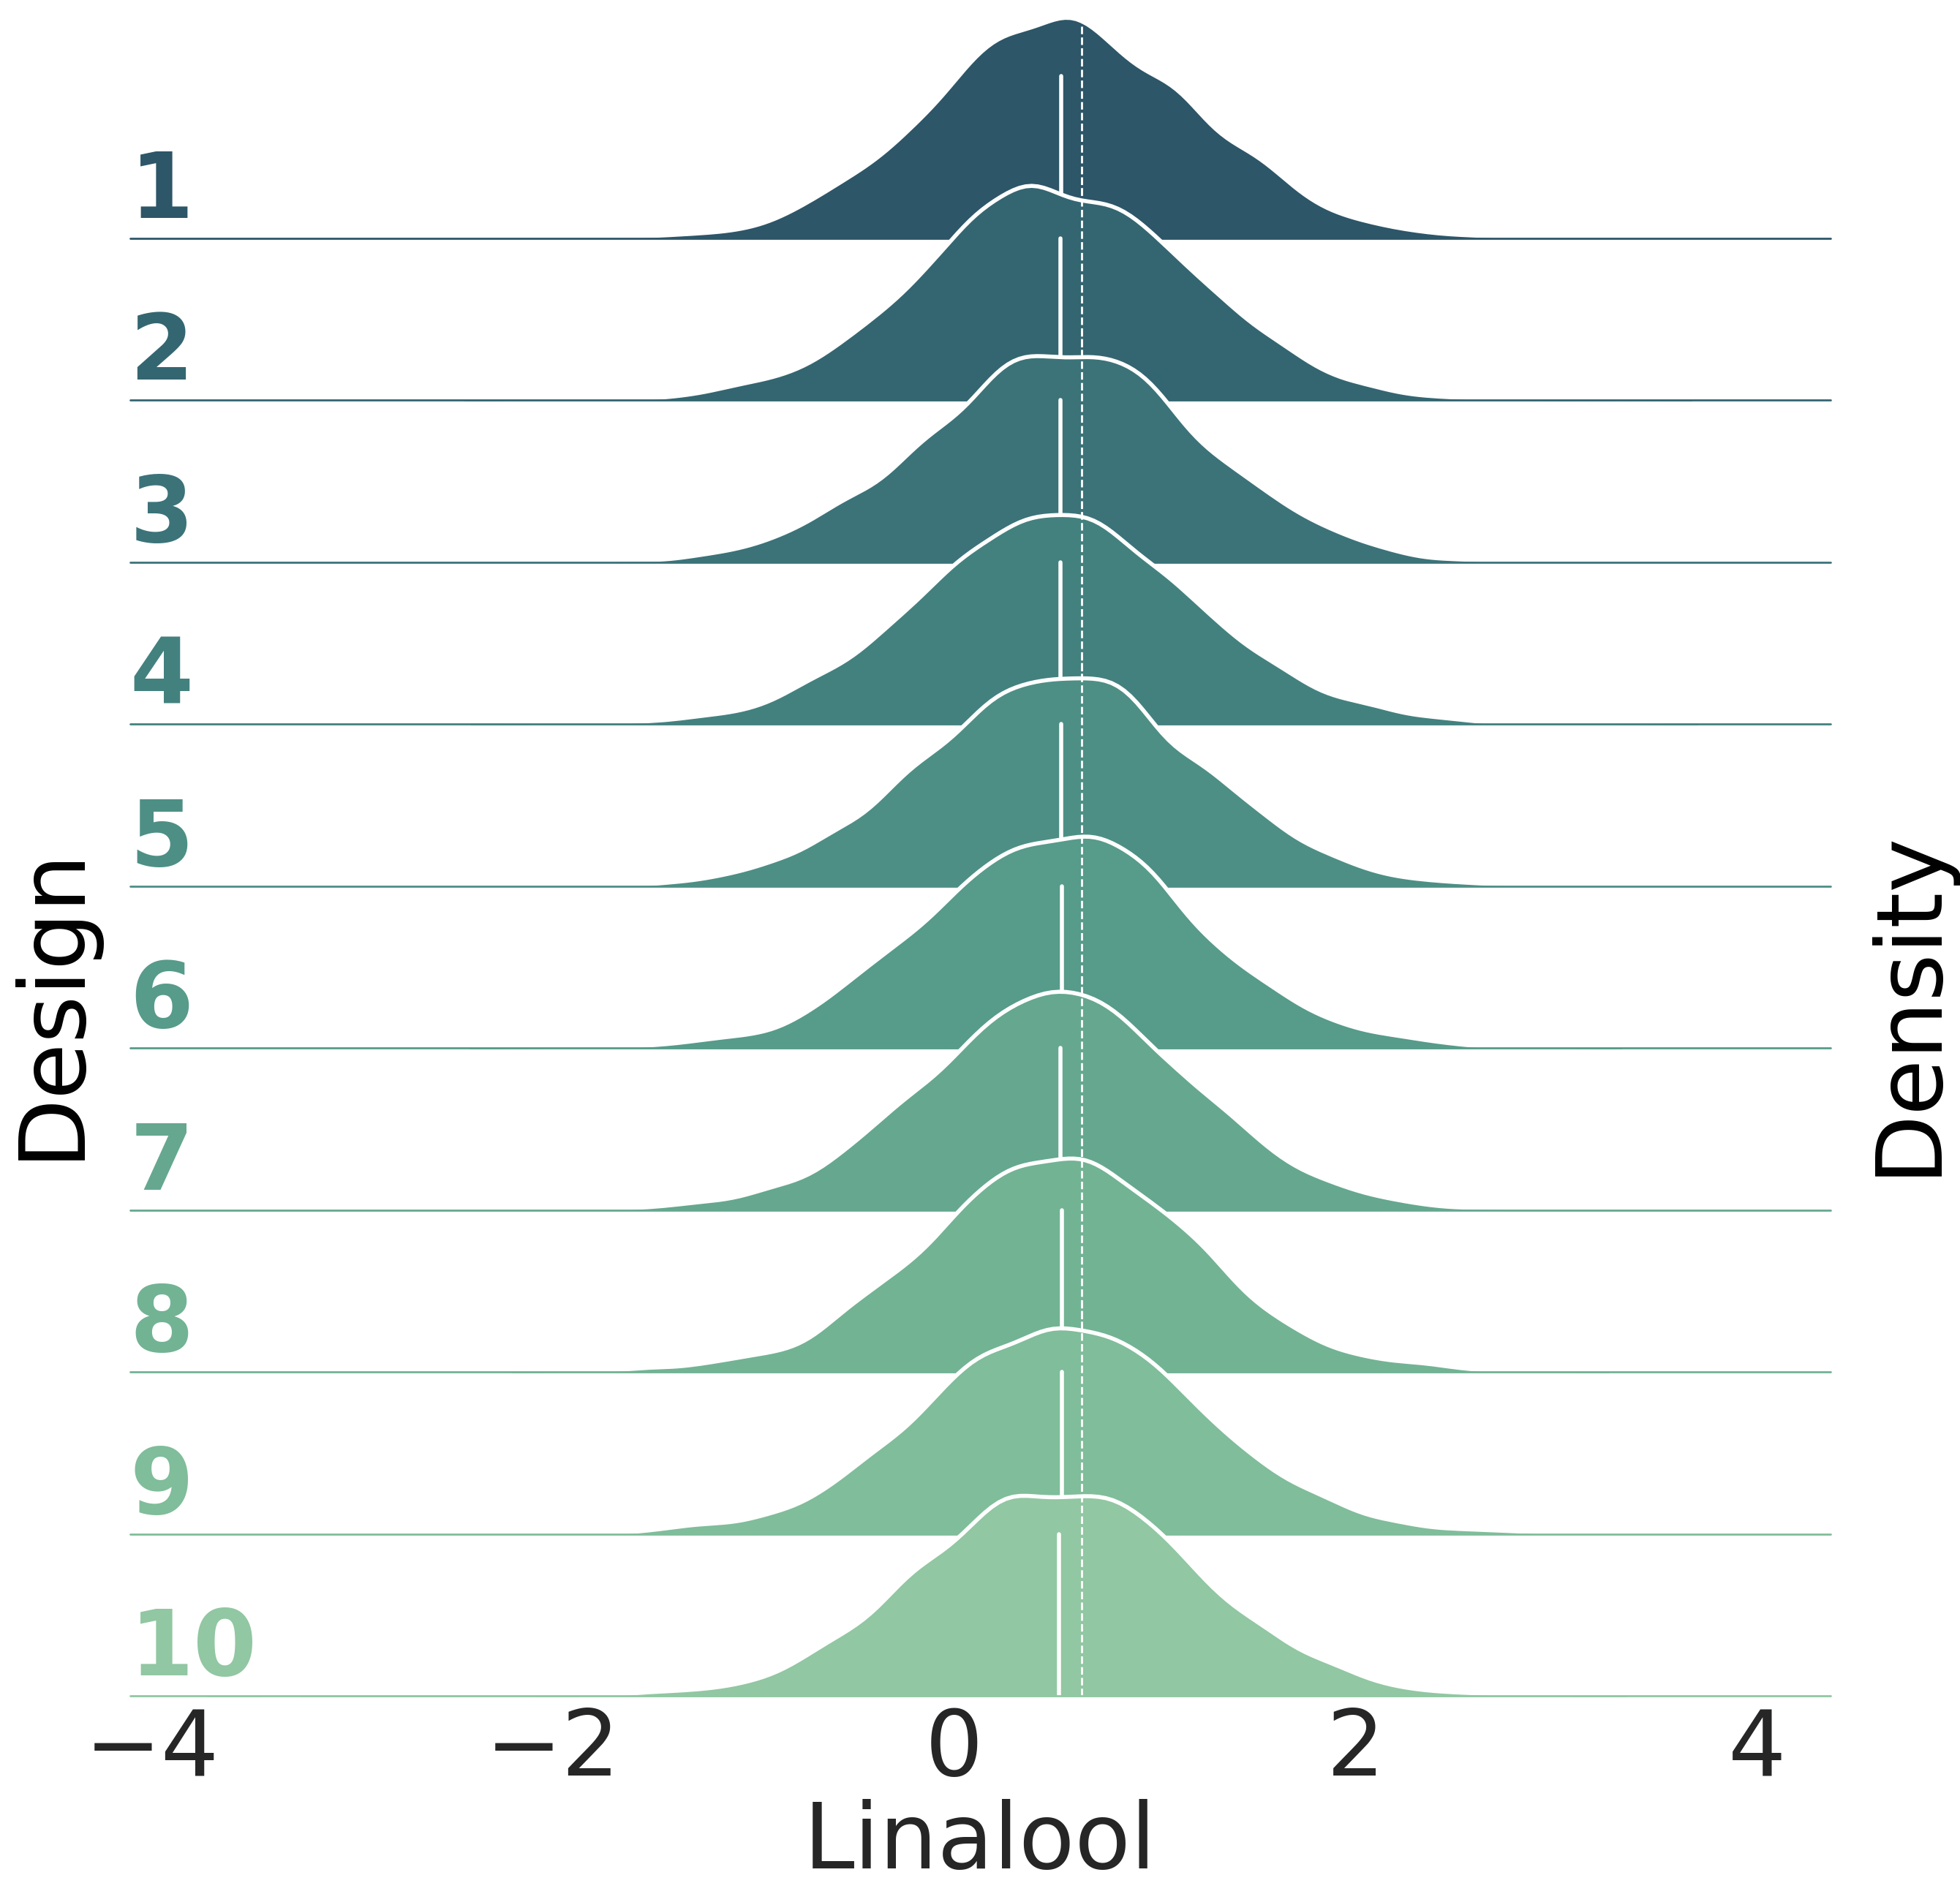

/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

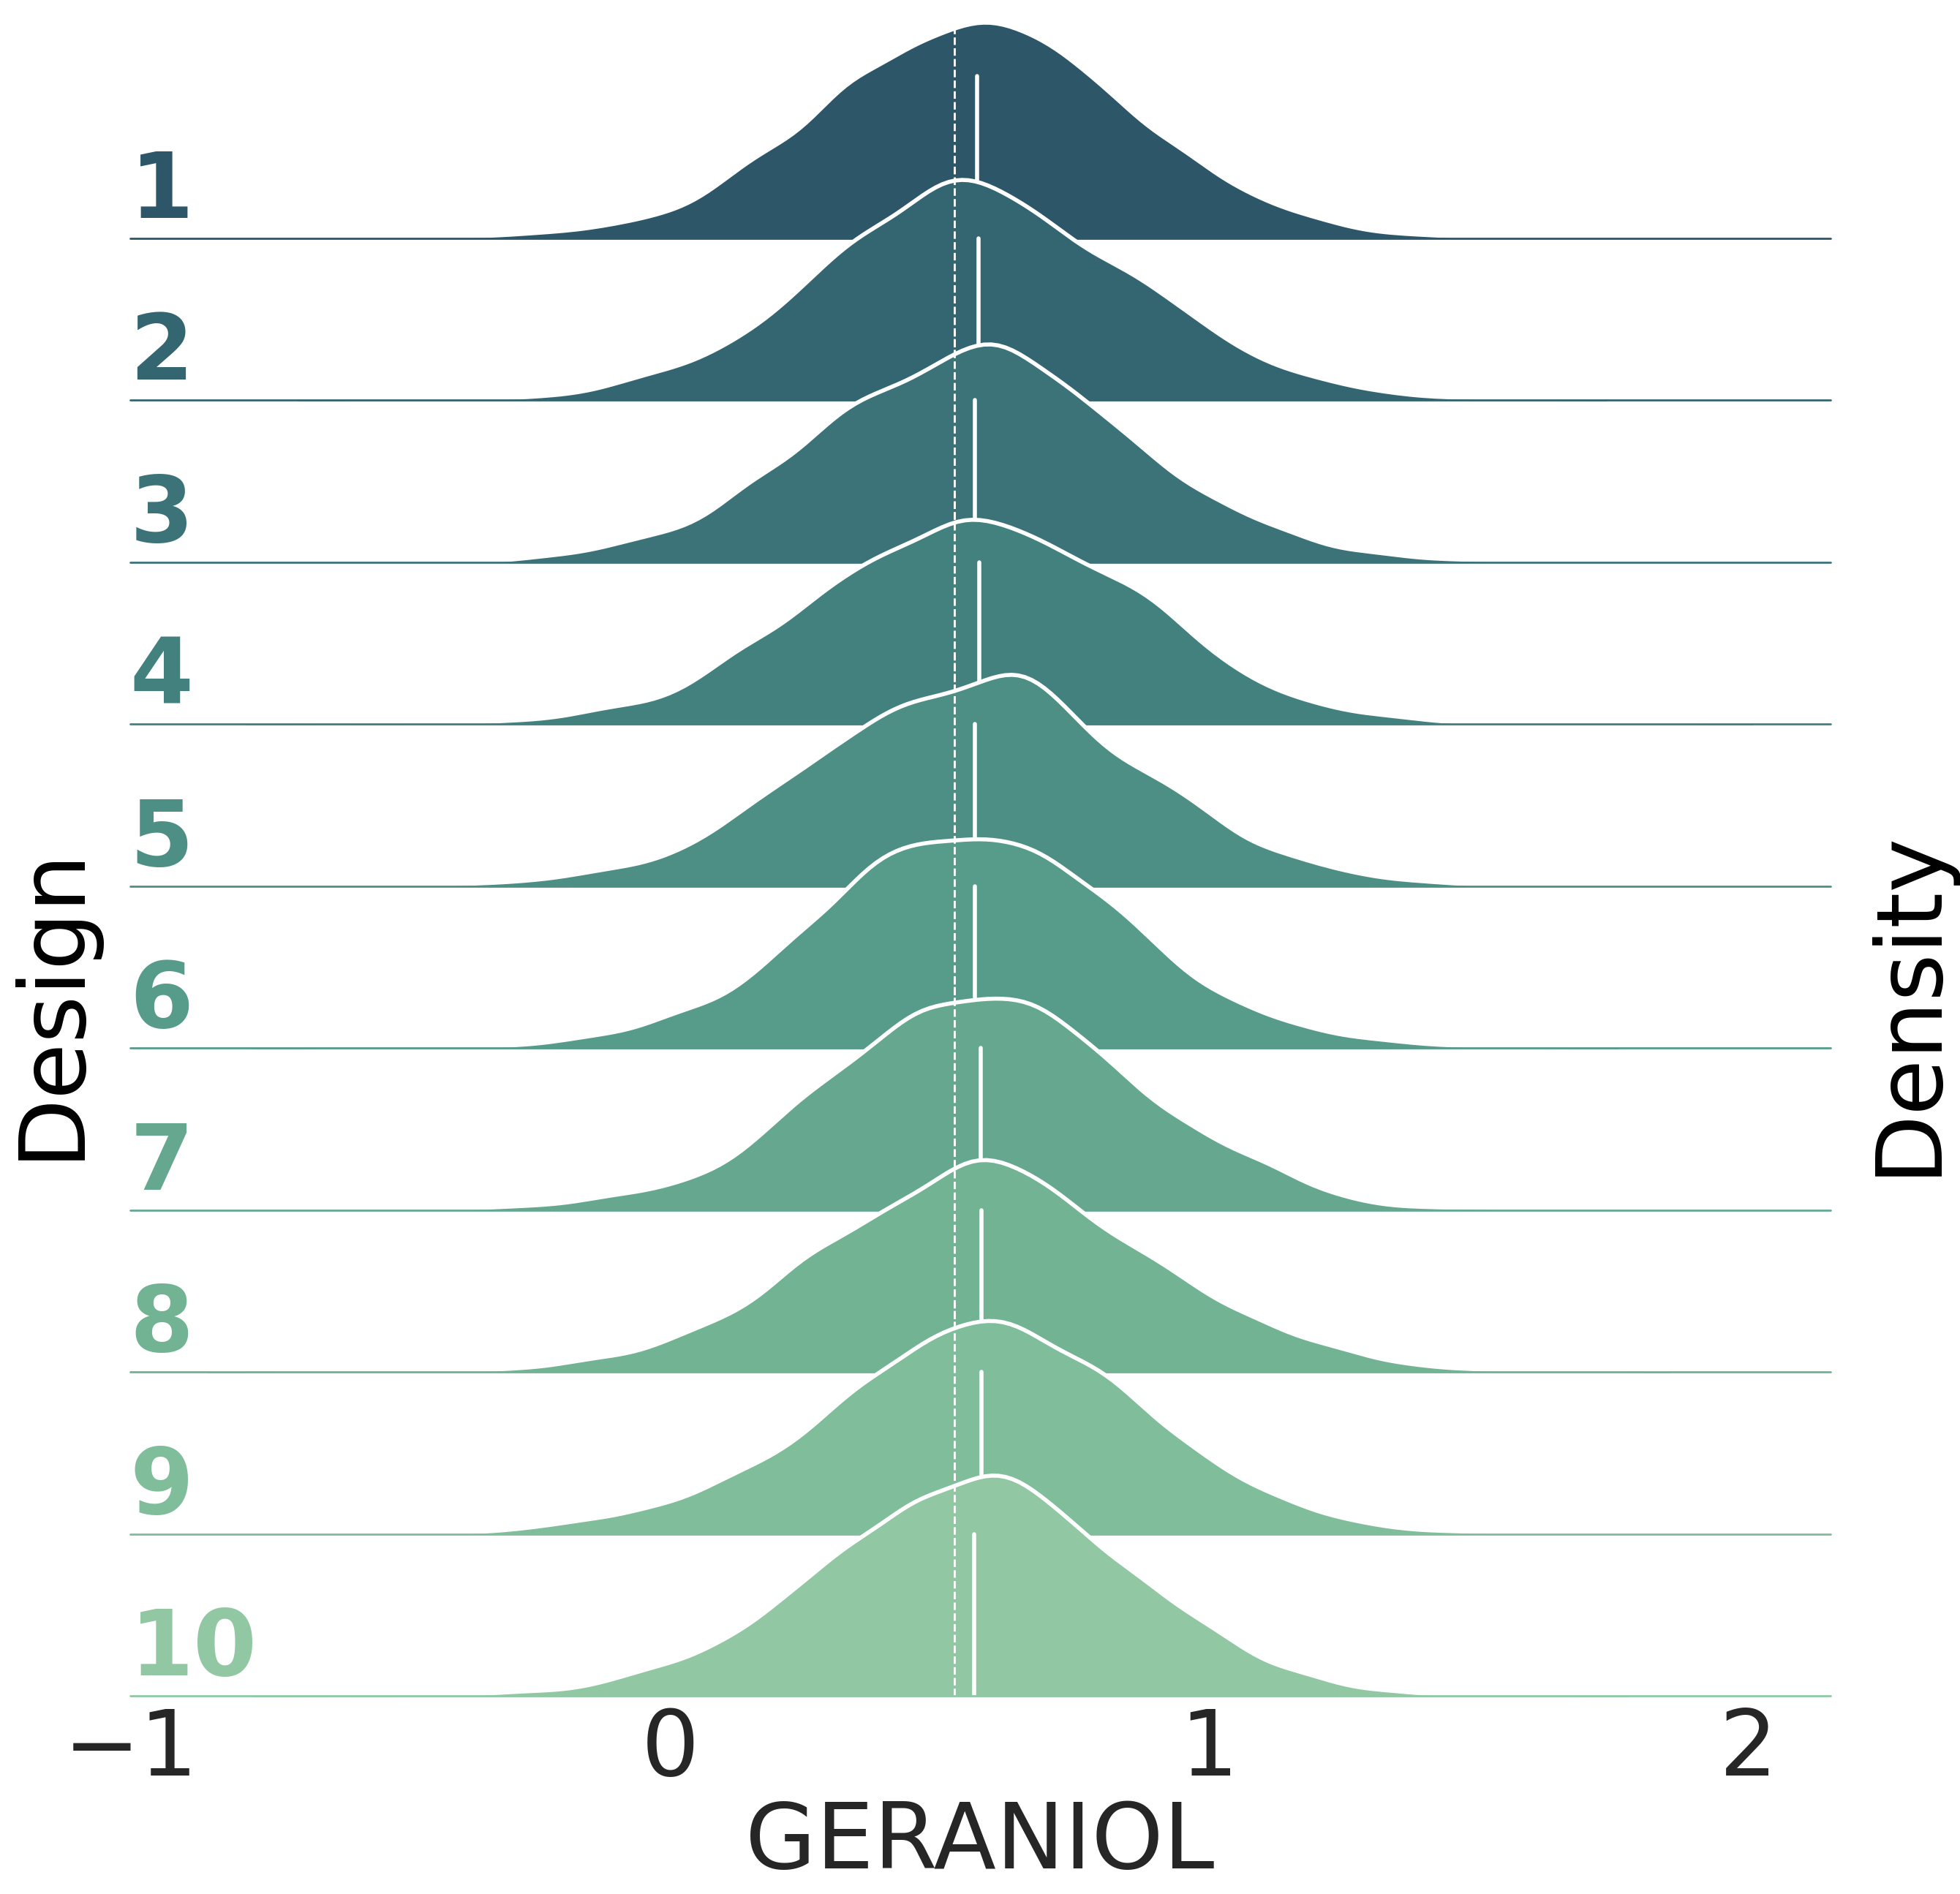

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 1.39 s
Done calculating success probabilities in 1.40 s


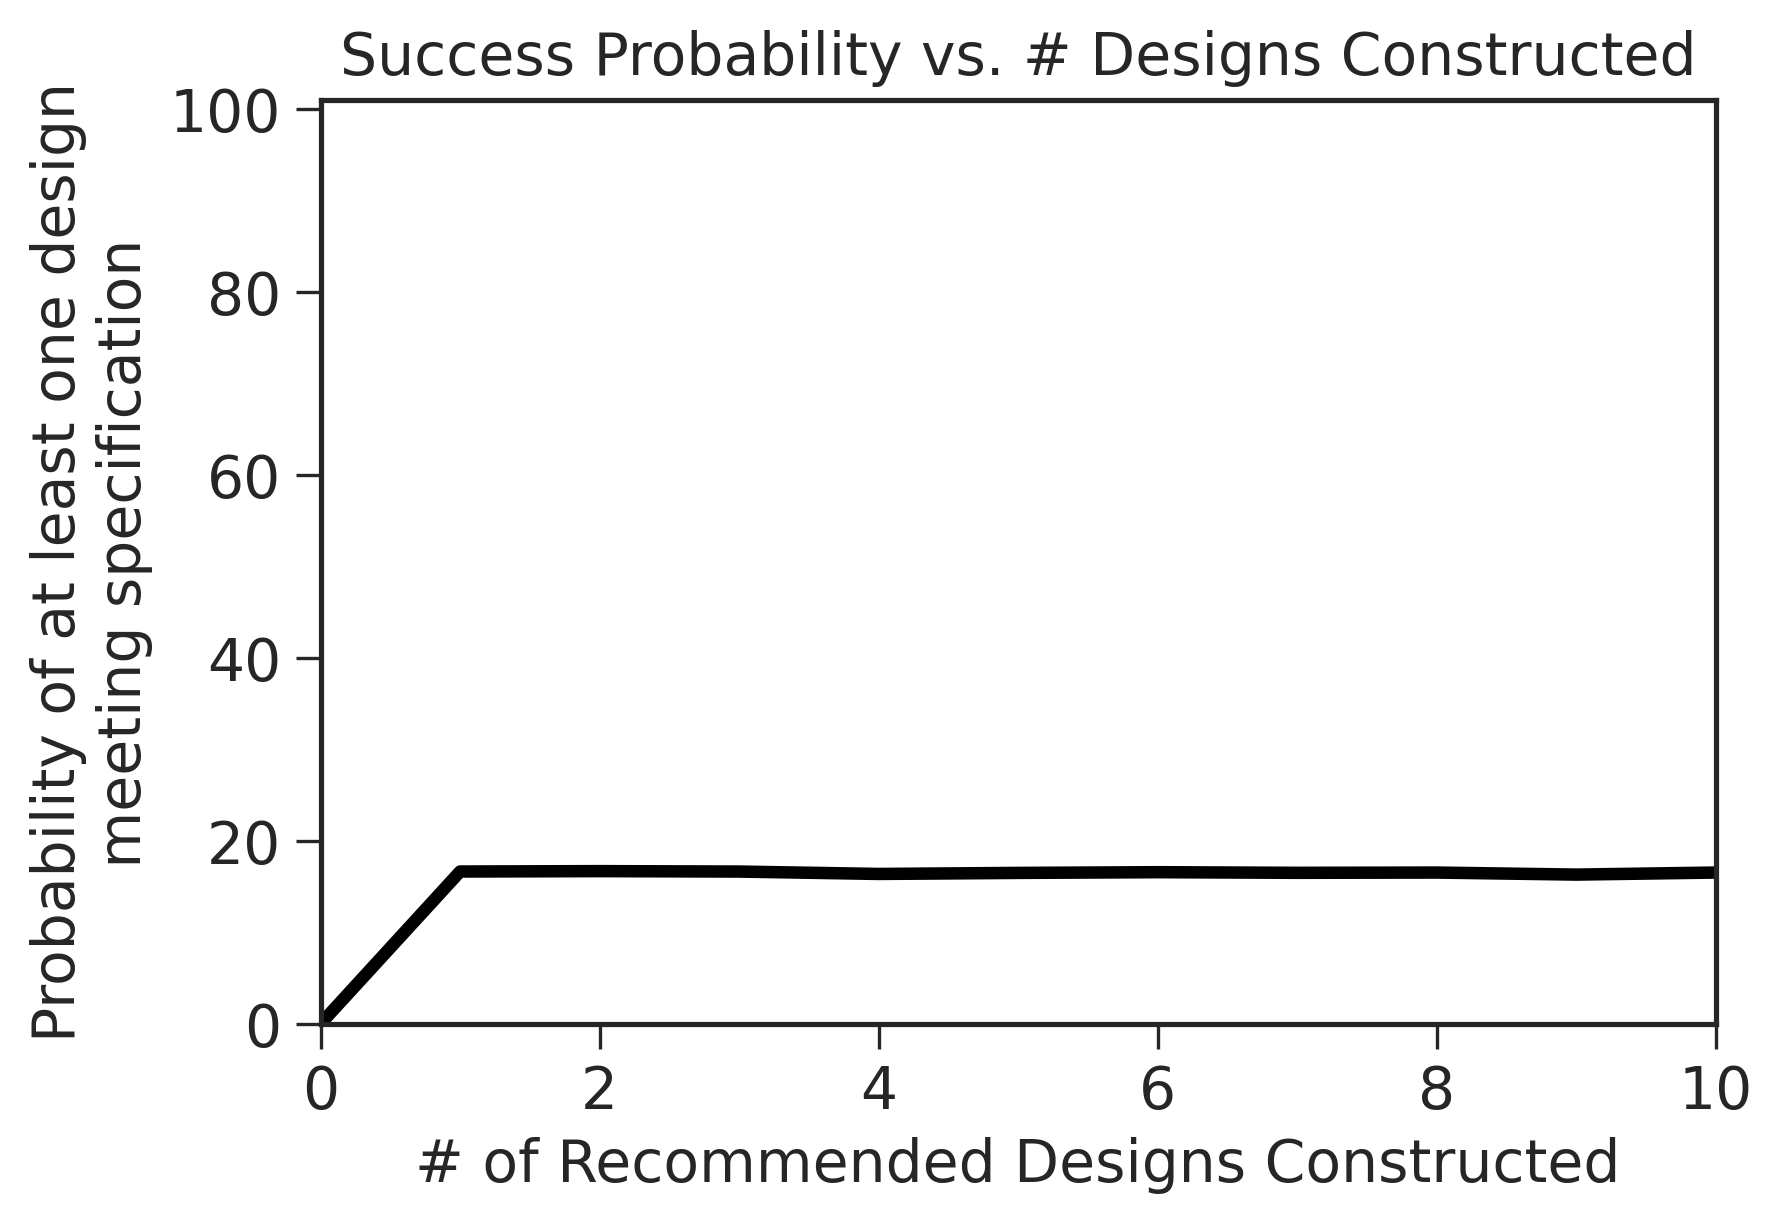

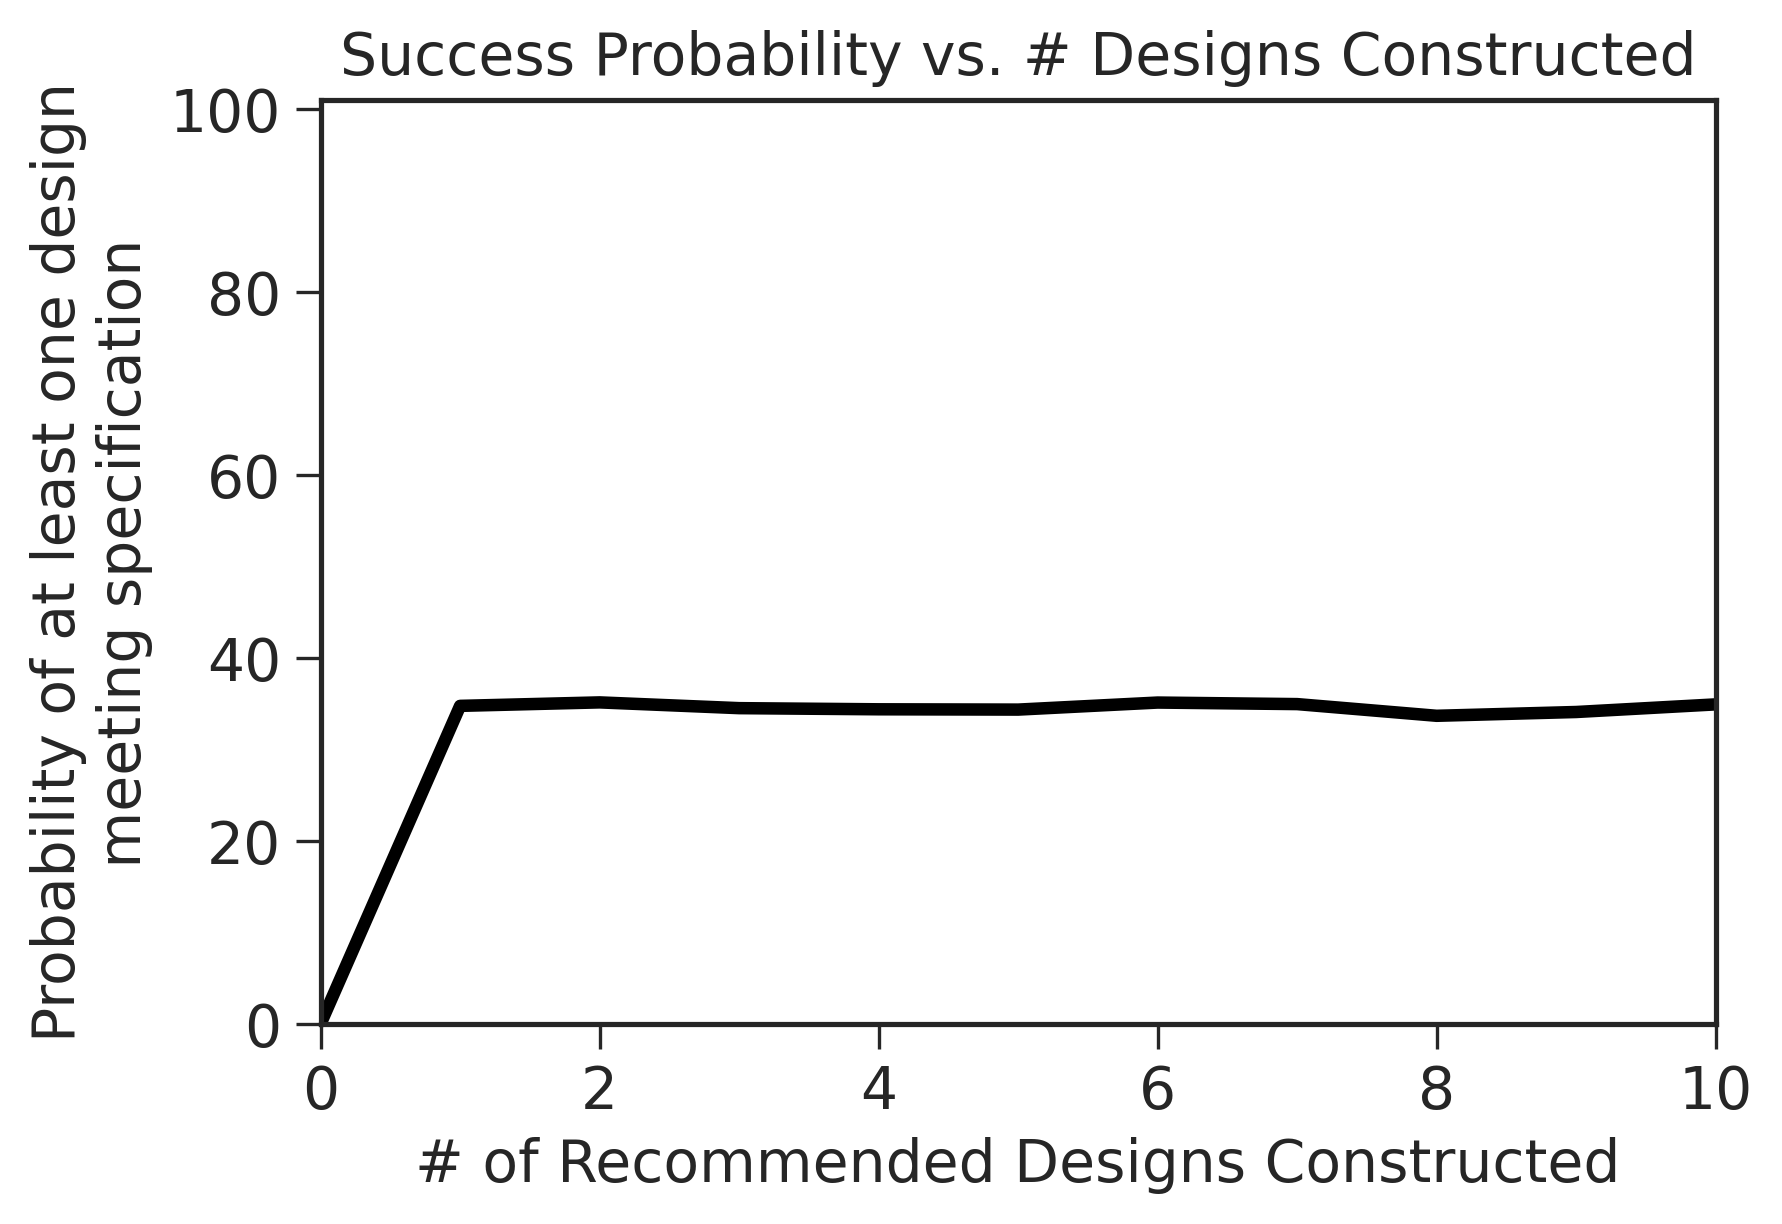

[0.531025331, 0.569713904]

In [50]:
draws = art_2.generate_recommendation_candidates()
art_2.select_recommendations(draws)
art_2.target_values


In [52]:
rec_torpedo_C2 = art_2.recommendations[['Linalool','GERANIOL']].values

In [53]:
art_2.recs = {
    'pale ale':     rec_pale_ale_C2, #Pale Ale
    'hop hunter':   rec_hop_hunter_C2, #Hop Hunter
    'torpedo':      rec_torpedo_C2
}
art_2.result_suffix = "_C2"
art_2.save()

In [57]:
def plot_target_value(data, rec1, rec2, rec3, draws1=None, draws2=None, draws3=None,
                      dist=False, xlim=None, ylim=None, target_value=False, result_suffix=''):
    """Plot input data and recommendations in the target molecules plane.
    Corresponding to hopless beer study."""

    import matplotlib.gridspec as gridspec

    def set_axeslim(xlim=None, ylim=None):
        if xlim is not None:
            plt.xlim(left=xlim[0], right=xlim[1])
        if ylim is not None:
            plt.ylim(bottom=ylim[0], top=ylim[1])

    fig = plt.figure(figsize=(8, 5.5), tight_layout=True)
    sns.set(style="ticks", color_codes=True)
    lw = 2
    fontsize = 15

    color1 = '#339966'
    color2 = '#1E593B'
    color3 = '#4CE599'

    gs = gridspec.GridSpec(nrows=5, ncols=5,left=0.0, right=0.5, wspace=0.0, hspace=0)

    if dist:
        # Plot Linalool pdf
        ax1 = fig.add_subplot(gs[0, :-1])
        ax1 = sns.kdeplot(draws1[0][:,0], color=color3, shade=True)
        ax1 = sns.kdeplot(draws2[0][:,0], color=color2, shade=True)
        ax1 = sns.kdeplot(draws3[0][:,0], color=color1, shade=True)
        plt.axis('off')

        set_axeslim(xlim=xlim)

    with sns.axes_style("darkgrid"):
        # Plot input data and recommendations
        ax2 = fig.add_subplot(gs[1:, :-1])
        ax2.set_xlabel('Linalool (L)', fontsize=fontsize)
        ax2.set_ylabel('Geraniol (G)', fontsize=fontsize)

        ax2 = plt.scatter(data[:, 0], data[:, 1], s=70., c='r', marker='+', alpha=0.8, lw=lw, label='Data')

        ax2 = plt.scatter(rec1[:, 0], rec1[:, 1], s=80., c='None',
                    marker='*', edgecolors=color3, alpha=1, lw=lw, label='PA recommendations')
        ax2 = plt.scatter(rec3[:, 0], rec3[:, 1], s=70., c="None",
                    marker='s', edgecolors=color1, alpha=1, lw=lw, label='T recommendations')
        ax2 = plt.scatter(rec2[:, 0], rec2[:, 1], s=70., c="None",
                    marker='o', edgecolors=color2, alpha=1, lw=lw, label='HH recommendations')

        if target_value:
            ax2 = plt.scatter(target_dict['pale ale'][0], target_dict['pale ale'][1], s=70., c='k', marker='*', alpha=1,
                        edgecolors='k', lw=lw, label='PA target')
            ax2 = plt.scatter(target_dict['torpedo'][0], target_dict['torpedo'][1], s=20., c='k', marker='s', alpha=1,
                        edgecolors='k', lw=lw, label='T target')
            ax2 = plt.scatter(target_dict['hop hunter'][0], target_dict['hop hunter'][1], s=20., c='k', marker='o', alpha=1,
                        edgecolors='k', lw=lw, label='HH target')

        set_axeslim(xlim=xlim, ylim=ylim)

        plt.tick_params(axis='both', which='major', labelsize=fontsize)

    lgd = plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5), fontsize=fontsize, shadow=True)

    if dist:
        # Plot Geraniol pdf
        ax3 = fig.add_subplot(gs[1:, -1])
        ax3 = sns.kdeplot(draws1[1][:,0], color=color3, shade=True, vertical=True)
        ax3 = sns.kdeplot(draws2[1][:,0], color=color2, shade=True, vertical=True)
        ax3 = sns.kdeplot(draws3[1][:,0], color=color1, shade=True, vertical=True)
    #     plt.xticks([]),plt.yticks([])
    #     plt.tick_params(axis='both', which='both', bottom='off', top='off',
    #                     labelbottom='off', right='off', left='off', labelleft='off')
        plt.axis('off')

        set_axeslim(ylim=ylim)

    fig.savefig(output_dir + f'/target_values{result_suffix}.png', bbox_inches='tight',
                bbox_extra_artists=(lgd,), transparent=False, dpi=150)


/tmp/ipykernel_10508/3482025377.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(output_dir +'/target_values.png', bbox_inches='tight',
/usr/local/art/.venv/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/art/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


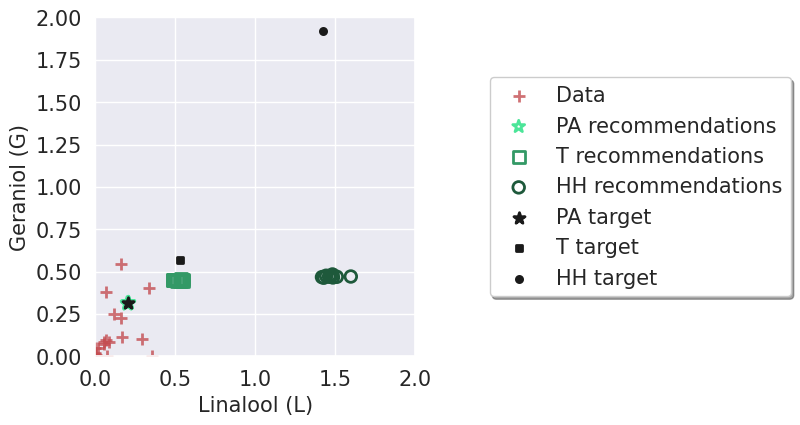

In [59]:
plot_target_value(art_1.y, art_1.recs['pale ale'], art_1.recs['hop hunter'], art_1.recs['torpedo'],
                  xlim=[0,2], ylim=[0,2], target_value=True, result_suffix='_C1')

/tmp/ipykernel_10508/3482025377.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(output_dir +'/target_values.png', bbox_inches='tight',


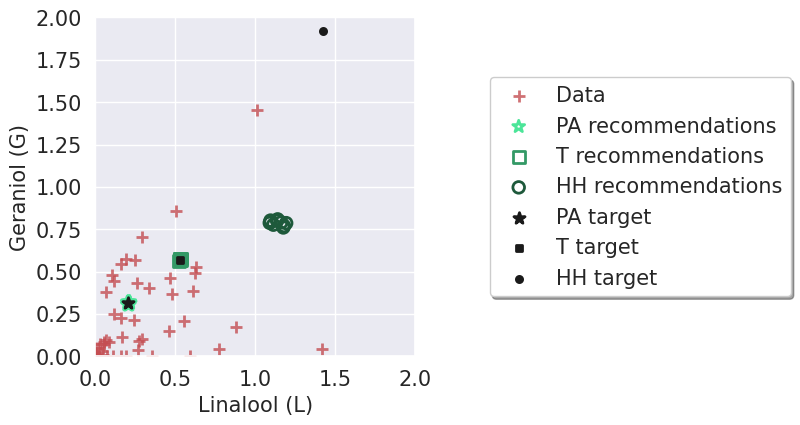

In [60]:
plot_target_value(art_2.y, art_2.recs['pale ale'], art_2.recs['hop hunter'], art_2.recs['torpedo'],
                  xlim=[0,2], ylim=[0,2], target_value=True, result_suffix='_C2')

In [62]:
plot_target_value(art_2.y, art_2.recs['pale ale'], art_2.recs['hop hunter'], art_2.recs['torpedo'],
                  draws_pa_C2, draws_hh_C2, draws_t_C2, dist=True,
                  xlim=[0,2], ylim=[0,2], target_value=True, result_suffix='_C1')

NameError: name 'draws_pa_C2' is not defined